In [1447]:
from __future__ import division
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import scipy.stats as sstat
import scipy.signal as ssig
import h5py
from mpl_toolkits.mplot3d import Axes3D
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as sklearnPCA
import re
import ephys_unit_analysis as ena
import fnmatch
# from PyPDF2 import PdfFileMerger, PdfFileReader
import seaborn as sns
%matplotlib inline
mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams['font.sans-serif']=['Arial', 'Helvetica','Bitstream Vera Sans', 'DejaVu Sans', 'Lucida Grande', 
                                 'Verdana', 'Geneva', 'Lucid', 'Avant Garde', 'sans-serif']  

%load_ext autoreload
%autoreload 2
# pal=sns.blend_palette(["black", "crimson"], 2)
sns.despine()
# current_palette = sns.color_palette("colorblind", 10)
# sns.set_palette(current_palette)

# for publication quality plots, not bar graphs, use this: 




#%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def set_pub_plots(pal=sns.blend_palette(["gray","crimson", 'cyan', 'magenta', 'purple'  ],5)):
    sns.set_style("white")
    sns.set_palette(pal)
    sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5, "axes.linewidth":2.5, 'figure.facecolor': 'white'}) 
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    # optional, makes markers bigger, too, axes.linewidth doesn't seem to work
    plt.rcParams['axes.linewidth'] = 2.5

rc_pub={'font.size': 25, 'axes.labelsize': 25, 'legend.fontsize': 25.0, 
    'axes.titlesize': 25, 'xtick.labelsize': 25, 'ytick.labelsize': 25, 
    #'axes.color_cycle':pal, # image.cmap - rewritesd the default colormap
    'axes.linewidth':2.5, 'lines.linewidth': 2.5,
    'xtick.color': 'black', 'ytick.color': 'black', 'axes.edgecolor': 'black','axes.labelcolor':'black','text.color':'black'}
# to restore the defaults, call plt.rcdefaults() 

#set_pub_bargraphs()
set_pub_plots()

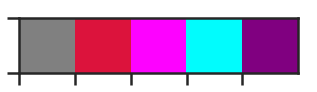

In [3]:
pal = sns.blend_palette(["gray","crimson", 'magenta','cyan',  'purple'  ],5)
sns.palplot(pal)
sns.set_palette(pal)
groups = { '002': 'ko', '003': 'ko', '005': 'wt', '006': 'het', '007':'het', '008': 'het', '009':'ko', '010': 'ko', 
            '367': 'wt', '369': 'ko', '377': 'het', '378': 'ko', '380': 'ko', '488': 'wt', '489': 'ko', 
           '930': 'ko', '931': 'het', '936': 'het', '937': 'ko', '942': 'wt', '944': 'het', '958': 'ko', '959': 'het'
}  

In [4]:
dir12_seq = np.array([10, 7, 3, 2, 4, 8, 9, 5, 7, 3, 4, 8, 3, 2, 1, 8, 0, 4, 9, 11, 
10, 9, 1, 11, 4, 0, 7, 1, 2, 8, 2, 9, 11, 9, 6, 5, 10, 4, 9, 0, 7, 11, 9, 
5, 9, 10, 11, 6, 8, 9, 5, 4, 2, 8, 11, 2, 10, 3, 5, 1, 7, 0, 4, 9, 1, 5, 
11, 3, 5, 10, 1, 2, 9, 6, 2, 2, 11, 5, 10, 7, 3, 7, 4, 6, 8, 4, 1, 8, 0, 
11, 0, 6, 2, 11, 1, 10, 3, 8, 3, 1, 2, 10, 5, 3, 11, 1, 7, 3, 4, 7, 8, 4, 6, 
7, 11, 7, 0, 8, 6, 10, 4, 5, 7, 2, 10, 3, 5, 9, 8, 6, 3, 2, 0, 11, 0, 6, 10, 
0, 7, 4, 5, 0, 10, 6, 8, 10, 3, 11, 9, 0, 5, 1, 3, 7, 0, 6, 9, 1, 6, 10, 5, 
6, 11, 7, 0, 5, 1, 4, 1, 6, 8, 2, 9, 2, 8, 3, 0, 4, 6, 1])

dir8_seq = np.array([2, 0, 7, 5, 6, 3, 3, 1, 4, 5, 4, 7, 4, 7, 5, 2, 2, 2, 2, 1, 1, 7,
       5, 3, 1, 1, 3, 4, 2, 3, 6, 6, 0, 5, 1, 2, 7, 6, 5, 3, 5, 4, 5, 6,
       5, 4, 4, 6, 6, 4, 0, 2, 7, 7, 0, 4, 5, 1, 2, 4, 3, 3, 4, 5, 7, 5,
       4, 7, 2, 4, 5, 7, 0, 1, 2, 2, 3, 6, 1, 3, 5, 1, 5, 1, 2, 6, 0, 1,
       7, 1, 0, 6, 7, 6, 5, 3, 3, 2, 5, 7, 0, 4, 3, 0, 1, 4, 1, 3, 5, 2,
       0, 1, 6, 0, 5, 7, 1, 7, 3, 0, 6, 7, 0, 2, 5, 2, 3, 7, 4, 3, 3, 6,
       3, 1, 2, 1, 5, 7, 6, 0, 3, 3, 0, 4, 0, 7, 1, 2, 0, 3, 0, 0, 6, 5,
       2, 5, 4, 2, 7, 0, 1, 3, 2, 7, 6, 6, 1, 0, 1, 5, 6, 0, 3, 2, 6, 4,
       7, 0, 7, 4, 6, 5, 4, 1, 6, 2, 4, 4, 2, 4, 7, 6, 0, 4, 3, 1, 6, 6,
       0, 7])

contrast_seq = np.array([1, 0.25, 0.125, 1, 0.0625, 1, 1, 0.5, 0.0625, 0.125, 0.5, 
0.125, 0.5, 0.5, 0.125, 0.125, 0.5, 0.25, 0.5, 0.0625, 1, 0.0625, 0.5, 1, 
1, 0.125, 1, 0.125, 0.125, 0.25, 0.0625, 0.0625, 0.125, 0.5, 0.125, 0.5, 
0.0625, 1, 1, 0.25, 0.25, 1, 1, 0.25, 0.125, 1, 0.25, 0.5, 0.0625, 0.5, 
0.125, 0.0625, 0.25, 0.0625, 0.25, 0.5, 0.25, 0.5, 0.125, 0.125, 1, 1, 
0.5, 0.5, 0.125, 1, 0.25, 0.0625, 0.25, 0.25, 1, 1, 0.25, 0.5, 0.5, 0.125, 
1, 0.125, 0.0625, 0.125, 0.25, 0.0625, 0.25, 0.0625, 0.0625, 0.0625, 0.5, 
0.125, 0.25, 0.5, 0.0625, 0.25, 0.5, 0.0625, 0.25, 1, 0.0625, 0.0625, 0.25, 0.125])

sf_seq = np.array([2, 0, 0, 4, 3, 3, 0, 4, 4, 3, 2, 5, 3, 2, 0, 4, 1, 0, 5, 2, 0, 
1, 0, 1, 3, 5, 2, 5, 1, 2, 0, 5, 2, 3, 5, 1, 0, 4, 3, 2, 5, 5, 3, 5, 
2, 0, 3, 3, 0, 3, 4, 5, 4, 1, 4, 0, 1, 5, 4, 1, 5, 3, 3, 5, 3, 3, 2, 
3, 2, 1, 1, 5, 1, 4, 1, 2, 3, 2, 4, 2, 1, 0, 5, 5, 2, 2, 4, 1, 4, 1, 
3, 1, 0, 4, 4, 4, 4, 0, 5, 4, 4, 0, 3, 5, 5, 2, 1, 3, 4, 1, 5, 0, 2, 
2, 0, 0, 0, 1, 2, 1])

d_dir12 = {}
d_dir8 = {}
d_contrast = {}
d_sf = {}

for i, v in enumerate(dir12_seq):
    d_dir12[i] = v 
for i, v in enumerate(dir8_seq):
    d_dir8[i] = v 
for i, v in enumerate(contrast_seq):
    d_contrast[i] = v 
for i, v in enumerate(sf_seq):
    d_sf[i] = v 

probe = '64DA'
channel_groups = ena.get_channel_depth(probe)
ch_map = ena.get_channel_depth(probe)

In [5]:
contrast_seq.shape

(100L,)

In [32]:
colors_group = ['k', 'violet', 'blue']
colors_training = ['gray', 'crimson']

In [1484]:
matches = [] # list of experiment folders
source_folder = r"U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training"
for root, dirnames, filenames in os.walk(source_folder):
    for dirname in fnmatch.filter(dirnames, '*conc'):
        if 'atch' in dirname or 'bad' in dirname:
            continue
        matches.append(os.path.join(root, dirname)) 
print matches[:5]
print len(matches)

['U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Fenales\\set1\\959 pre\\conc', 'U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Fenales\\set1\\958 post\\conc', 'U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Fenales\\set1\\959 post\\conc', 'U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Fenales\\set1\\958 pre\\conc', 'U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Fenales\\set2\\944 pre\\conc']
28


In [1492]:
for path in matches[:]:

    training = 'no'
    if 'bad' in path or '489 post' in path:
        continue
    print path
    if 'Male' in path:
        sex = 'M'
    else:
        sex = 'F'
    et = path.split('\\')[-2].split()[0][:3]
    training = path.split('\\')[-2].split()[-1]
    if 'pre' in training or 'right' in training:
        training = 'pre'
    else:
        training = 'post'
    print et, training, sex

U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set1\959 pre\conc
959 pre F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set1\958 post\conc
958 post F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set1\959 post\conc
959 post F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set1\958 pre\conc
958 pre F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set2\944 pre\conc
944 pre F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set2\942 post\conc
942 post F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set2\942 pre\conc
942 pre F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set2\944 post\conc
944 post F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set3\931 pre\conc
931 pre F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set3\931 post\conc
931 post F


## Load spikes

In [1493]:
#Receptive field mapping
ls_psth = []
ls_spikes = []
ls_tmt = []

for path in matches[:]:
    df = 0
    training = 'no'
    if 'bad' in path or '489 post' in path:
        continue
    print path
    if 'Male' in path:
        sex = 'M'
    else:
        sex = 'F'
    et = path.split('\\')[-2].split()[0][:3]
    training = path.split('\\')[-2].split()[-1]
    if 'pre' in training or 'right' in training:
        training = 'pre'
    else:
        training = 'post'
    print et, training, sex
    
    path_cluster_groups = os.path.join(path, 'cluster_groups.csv')
    cluster_groups = pd.read_csv(path_cluster_groups, sep = '\t')
    # good_units = cluster_groups[cluster_groups.group != 'noise'].cluster_id.values
    noise_units = cluster_groups[(cluster_groups['group'] == 'noise') | 
                                 (cluster_groups['group'] == 'mua') ].cluster_id.values
    spike_times = np.load(os.path.join(path, 'spike_times.npy'))
    spike_clusters = np.load(os.path.join(path, 'spike_clusters.npy'))
    templates = np.load(os.path.join(path, 'templates.npy'))
    spike_templates = np.load(os.path.join(path, 'spike_templates.npy'))
    df = pd.DataFrame({'times':spike_times.flatten()/30000.0, 
                       'unit_id':spike_clusters.flatten(), 
                       'templates':spike_templates.flatten() })

    df = df[~df.unit_id.isin(noise_units)]
    df.loc[:,'et'] = et
    df.loc[:,'training'] = training
    df.loc[:,'cluster_id'] = df.loc[:,'unit_id'].astype('str') + 'et' + df.loc[:,'et'] + training
    df.loc[:,'sex'] = sex
    df.loc[:,'path'] = path
#     df.loc[:,'trial_n'] = df.loc[:,'times']//1.0

    ls_spikes.append(df)

# df_tmt = pd.concat(ls_tmt)
df_spikes = pd.concat(ls_spikes)

# master_kic.head()

U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set1\959 pre\conc
959 pre F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set1\958 post\conc
958 post F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set1\959 post\conc
959 post F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set1\958 pre\conc
958 pre F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set2\944 pre\conc
944 pre F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set2\942 post\conc
942 post F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set2\942 pre\conc
942 pre F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set2\944 post\conc
944 post F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set3\931 pre\conc
931 pre F
U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim-1-only-training\Fenales\set3\931 post\conc
931 post F


In [1460]:
df_spikes.templates

1          16
2         162
4         241
6         162
7          16
10         16
11        186
13         30
14         48
15        162
16         16
18        162
19        162
22        162
23         16
26        229
27         69
29         69
30        162
31         16
34        162
35        162
37         16
39        162
40         16
45         22
46         69
48        229
49         69
50         16
         ... 
633120     34
633121    193
633122    174
633123    127
633124    141
633126    111
633127    240
633132     98
633133     99
633135     76
633138     94
633139    240
633143     99
633144    238
633145     94
633147     34
633148     61
633149    250
633150    257
633153     61
633154    141
633161    238
633163     99
633167    227
633168    248
633173    193
633177    258
633183    258
633184     39
633185    262
Name: templates, Length: 1428452, dtype: uint32

In [1053]:
df_spikes.to_pickle('sert_wt_spikes_probe64da.pkl')

In [4]:
path = r"U:\Data_Analysis\pak6\Analysis of units\sert_ko_master_spikes.pkl"
df_spikes = pd.read_pickle(path)

In [1494]:
# recs with 8 drifitng instead of 12 drifting, 25 trials 8 directions (45 deg)
# rec_dir8 = df_spikes[df_spikes.times > 560].path.unique()

# tmp = df_spikes[~df_spikes.path.isin(rec_dir8)]
# tmp2 = df_spikes[df_spikes.path.isin(rec_dir8)]
tmp = df_spikes

# 20 trials, 4s trial length
df1 = df_spikes[(df_spikes.loc[:, 'times'] < 80)] #sf-tuning
df1.loc[:, 'trial_n'] = df1.loc[:, 'times'] //1.0
df1.loc[:,'paradigm'] = 'G-1'
df1.loc[:,'stim1'] = 'G-1'
# 20 trials, 4s trial length
df2 = df_spikes[(df_spikes.loc[:, 'times'] > 80) & (df_spikes.loc[:, 'times'] < 160)] 
df2.times = df2.times - 80
df2.loc[:, 'trial_n'] = df2.loc[:, 'times'] //1.0
df2.loc[:,'paradigm'] = 'G-N'
df2.loc[:,'stim1'] = 'G-N'

# 15 trials, 12 directions, 1s trial length
df3 = tmp[(tmp.loc[:, 'times'] > 160) & (tmp.loc[:, 'times'] < 340)] 
df3.times = df3.times - 160
df3.loc[:, 'trial_n'] = df3.loc[:, 'times'] //1.0
df3.loc[:,'paradigm'] = '12-drifting'
df3.loc[:,'stim1'] = df3.trial_n.map(d_dir12)

# 25 trials, 8 directions, 1s trial length
# df4 = tmp2[(tmp2.loc[:, 'times'] > 160) & (tmp2.loc[:, 'times'] < 360)] 
# df4.times = df4.times - 160
# df4.loc[:, 'trial_n'] = df4.loc[:, 'times'] //1.0
# df4.loc[:,'paradigm'] = '8-drifting'
# df4.loc[:,'stim1'] = df4.trial_n.map(d_dir8)

# 20 trials, 6 sf, 1s trial length
df5 = tmp[(tmp.loc[:, 'times'] > 340) & (tmp.loc[:, 'times'] < 460)] 
df5.times = df5.times - 340
df5.loc[:, 'trial_n'] = df5.loc[:, 'times'] //1.0
df5.loc[:,'paradigm'] = 'sf-tuning'
df5.loc[:,'stim1'] = df5.trial_n.map(d_sf)

# df6 = tmp2[(tmp2.loc[:, 'times'] > 360) & (tmp2.loc[:, 'times'] < 480)] 
# df6.times = df6.times - 360
# df6.loc[:, 'trial_n'] = df6.loc[:, 'times'] //1.0
# df6.loc[:,'paradigm'] = 'sf-tuning'
# df6.loc[:,'stim1'] = df6.trial_n.map(d_sf)
# df6 = pd.concat([df5, df6])

# 20 trials, 5 contasrts, 1s trial length
df7 = tmp[(tmp.loc[:, 'times'] > 460) & (tmp.loc[:, 'times'] < 560)] 
df7.times = df7.times - 460
df7.loc[:, 'trial_n'] = df7.loc[:, 'times'] //1.0
df7.loc[:,'paradigm'] = 'contrast-tuning'
df7.loc[:,'stim1'] = df7.trial_n.map(d_contrast)

# df8 = tmp2[(tmp2.loc[:, 'times'] > 480) & (tmp2.loc[:, 'times'] < 580)] 
# df8.times = df8.times - 480
# df8.loc[:, 'trial_n'] = df8.loc[:, 'times'] //1.0
# df8.loc[:,'paradigm'] = 'contrast-tuning'
# df8.loc[:,'stim1'] = df8.trial_n.map(d_contrast)
# df8 = pd.concat([df7, df8])

In [1055]:
print df1.shape, df2.shape, df3.shape, df5.shape, df7.shape


(156380, 11) (179483, 11) (513088, 11) (350730, 11) (228771, 11)


In [1059]:
df_conc.to_pickle('sert_wt_spikes_mapped.pkl')

In [1461]:
d_psth = {}

## PSTH

In [248]:
#generate psth for vmmn data
trial_length = 1.0
th_bin = 0.01
trials_number = 20.0
ls_psth = []
ls_tmt = []

data = df1
# data['opto'] = 1
paradigm = data.paradigm.unique()[0]
if 'G' in paradigm:
    trial_length = 4.0
elif '12' in paradigm:
    trials_number = 15
elif '8' in paradigm:
    trials_number = 25
print paradigm, trials_number, trial_length
for idx_train, train in enumerate(sorted(data.training.unique())):
    print train
    tmp = data[data.training == train]
    for idx_stim1, stim1 in enumerate(sorted(tmp['stim1'].unique())):
        print stim1

        tmp2 = tmp[ (tmp.stim1 == stim1)]

        for unit in tmp2['cluster_id'].unique():
            tmp3 = tmp2[(tmp2.cluster_id == unit)]
  
            et = tmp3.et.unique()[0]
            sex = tmp3.sex.unique()[0]
            path = tmp3.path.unique()[0]
            try:
                tmt, depth, ch_idx = ena.ksort_get_tmt(tmp3, unit, templates, channel_groups)
            except:
                depth = np.nan
            cuid =  str(unit) + 'et' + str(et) + str(stim1) + str(paradigm) + train
            
            df = ena.getRaster_kilosort(tmp3, unit, trial_length) 
            # check the reliability of the neuron, spike in 0.8 of trials
#             if df.trial.unique().size < 0.5*trials_number:
#                 continue
            h, ttr = ena.PSTH(df.times, th_bin, trial_length, trials_number) # all times rescaled to 0-4 this is why trias number 1.0
            zscore = sstat.mstats.zscore(h)
#             mean = np.mean(h[:30])
#             std = np.std(h[:30])
#             if mean==0:
#                 std=1
#             ztc = (h - mean)/std

            df_psth_tmp = pd.DataFrame({     'times':ttr,    'Hz':h,      'cuid': cuid, 'depth':depth,  
                                        'path': path, 'stim1': str(stim1), 'training': train, 'sex':sex,
                               'abs_times': idx_stim1*trial_length+ttr, 'paradigm':paradigm, 
                                    'zscore':zscore,  'et': et, 'cluster_id': unit  })

            ls_psth.append(df_psth_tmp)
#         df_tmt_tmp = pd.DataFrame({'tmt':tmt,  'cluster_id' : unit,  'depth': depth, 'path': path })
#         ls_tmt.append(df_tmt_tmp)
#     break
d_psth[paradigm] = pd.concat(ls_psth)
# df_tmt = pd.concat(ls_tmt)

contrast-tuning 20.0 1.0
post
0.0625
0.125
0.25
0.5
1.0
pre
0.0625
0.125
0.25
0.5
1.0


## Templates

In [1495]:
#generate psth for vmmn data
ls_tmt = []

data = df1
# data['opto'] = 1
paradigm = data.paradigm.unique()[0]

for idx_train, train in enumerate(sorted(data.training.unique())):
    print train
    tmp = data[data.training == train]
    for idx_stim1, stim1 in enumerate(sorted(tmp['stim1'].unique()[:5])):
        

        tmp2 = tmp[ (tmp.stim1 == stim1)]

        for unit in tmp2['cluster_id'].unique():
            
            tmp3 = tmp2[(tmp2.cluster_id == unit)]
  
            et = tmp3.et.unique()[0]
            sex = tmp3.sex.unique()[0]
            path = tmp3.path.unique()[0]
            try:
                tmt, depth, ch_idx = ena.ksort_get_tmt(tmp3, unit, templates, channel_groups)
            except:
                depth = np.nan
#             cuid =  str(unit) + 'et' + str(et) + str(stim1) + str(paradigm) + train

            df_tmt_tmp = pd.DataFrame({'tmt':tmt,  'cluster_id' : unit,  'depth': depth, 'path': path, 'et':et })
            ls_tmt.append(df_tmt_tmp)

df_tmt_db = pd.concat(ls_tmt)
df_tmt_db.head()

post
pre


cluster_id  depth   et                                               path  \
0  75et958post  900.0  958  U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim...   
1  75et958post  900.0  958  U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim...   
2  75et958post  900.0  958  U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim...   
3  75et958post  900.0  958  U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim...   
4  75et958post  900.0  958  U:\Data\pak6\OpenEphys\probe_64DB\SERT KO\stim...   

   tmt  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0

In [1503]:
df_tmt_ms.to_pickle('sert_paper_tmt_master.pkl')

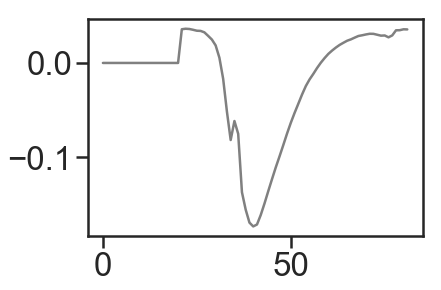

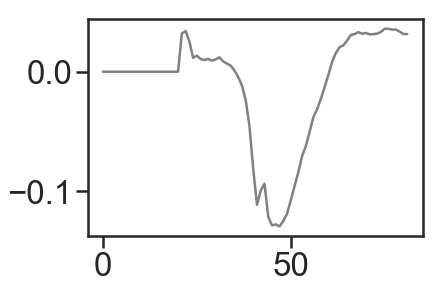

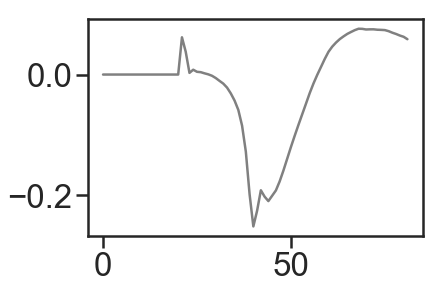

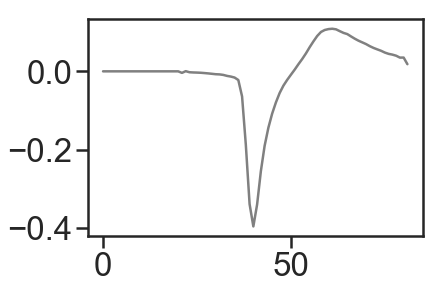

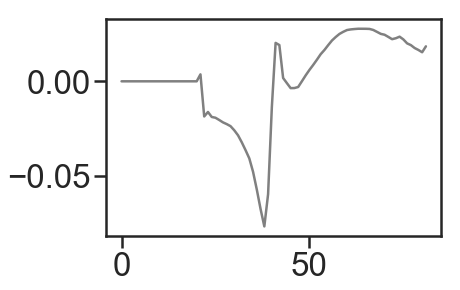

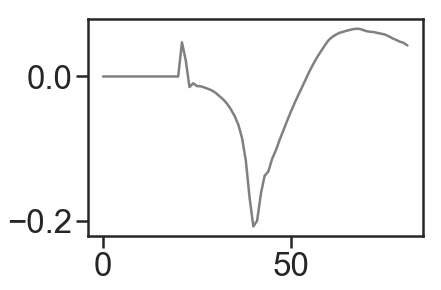

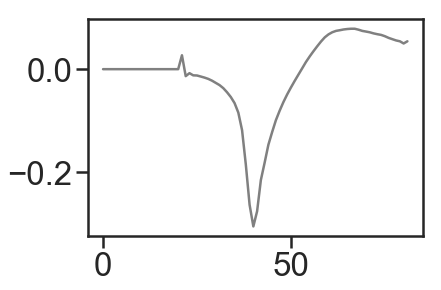

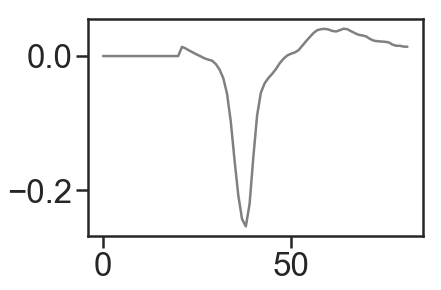

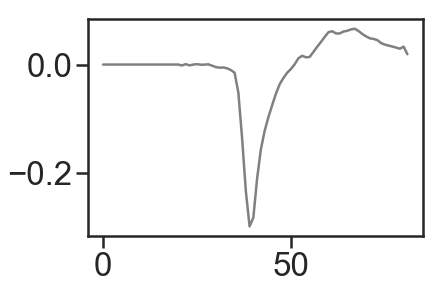

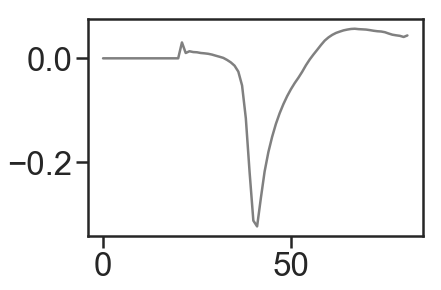

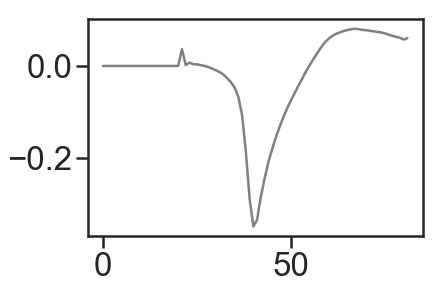

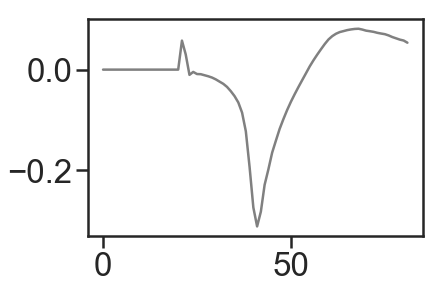

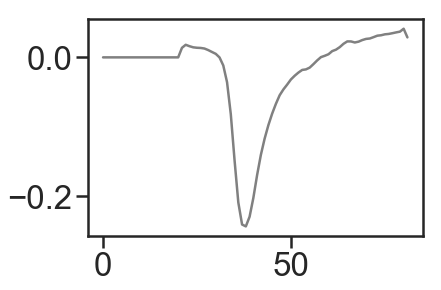

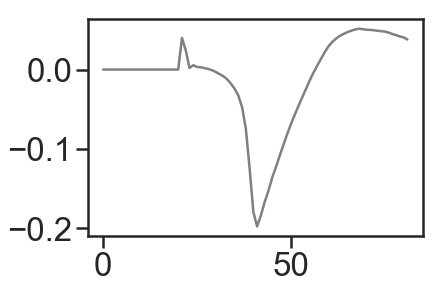

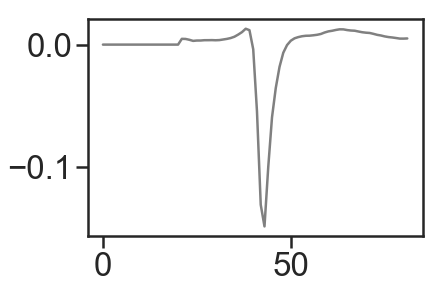

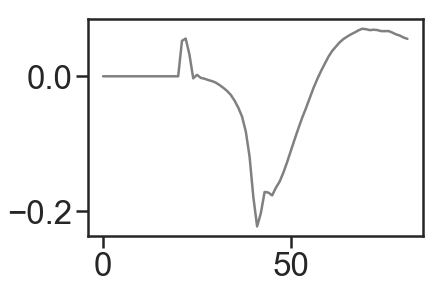

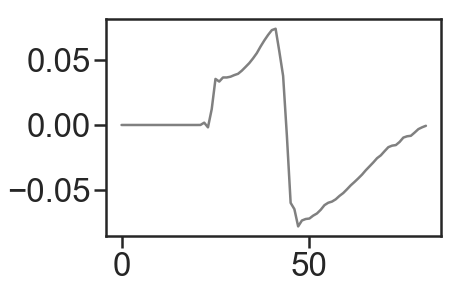

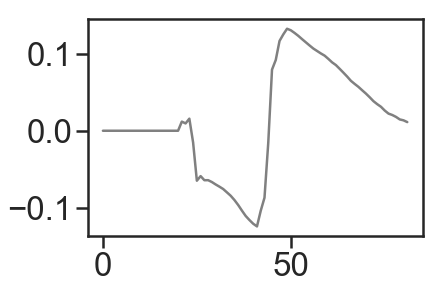

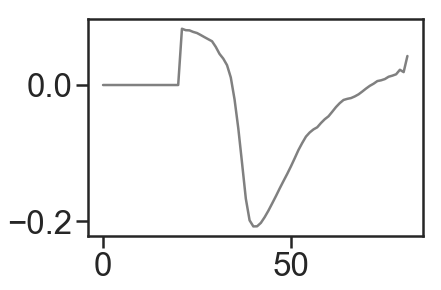

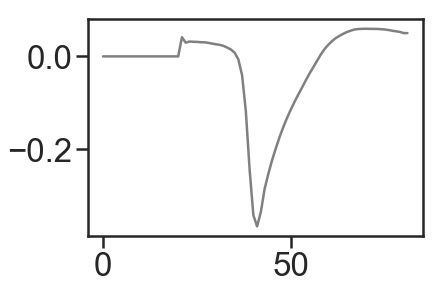

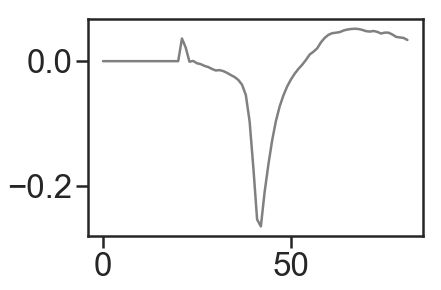

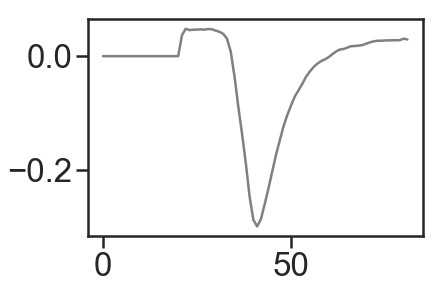

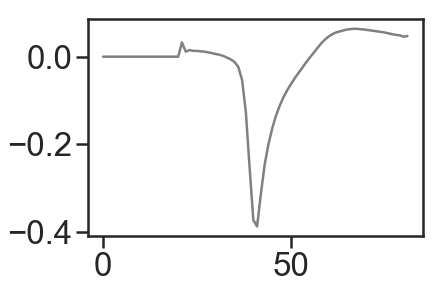

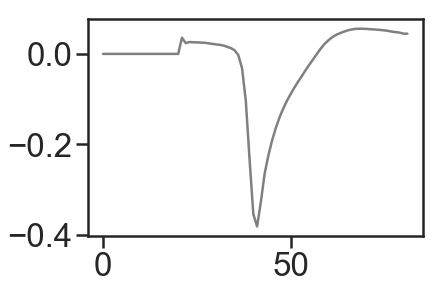

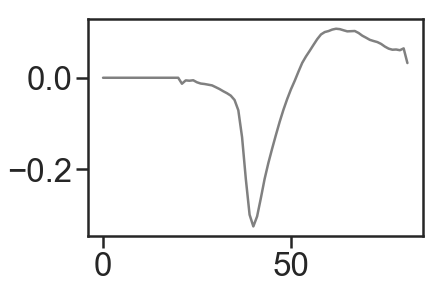

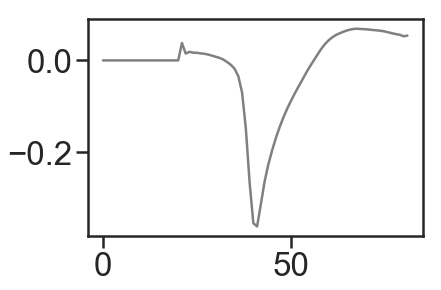

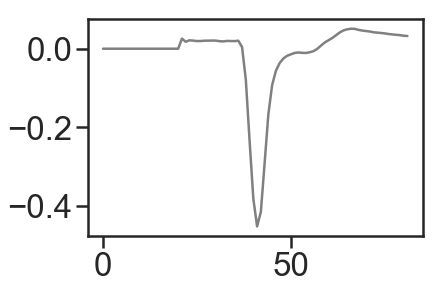

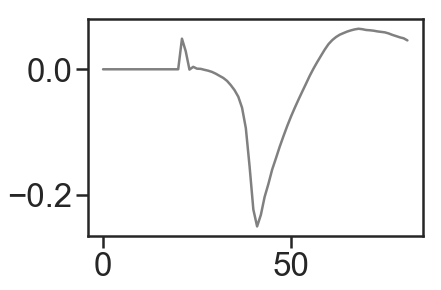

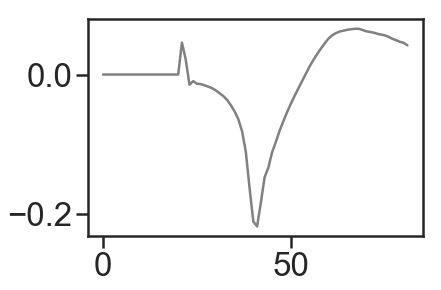

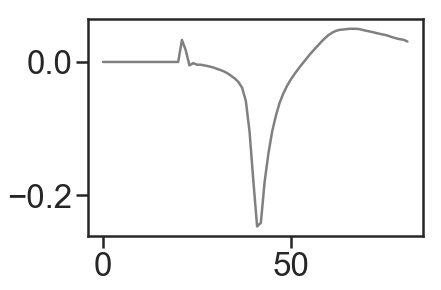

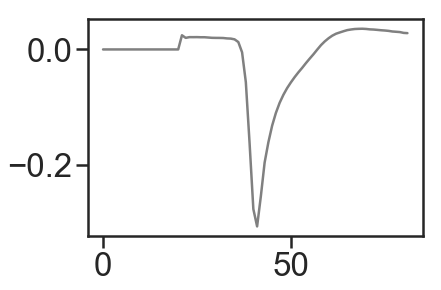

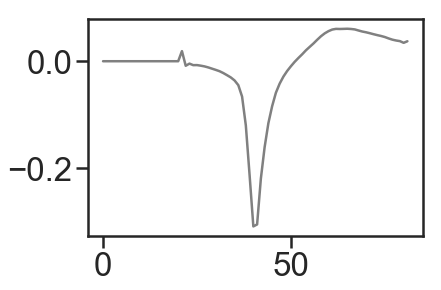

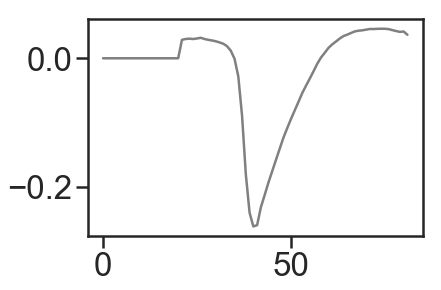

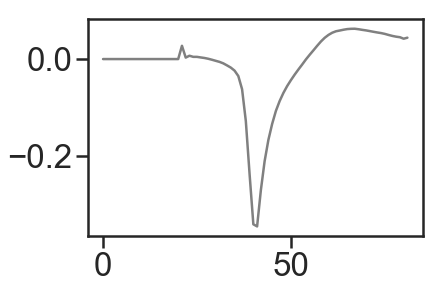

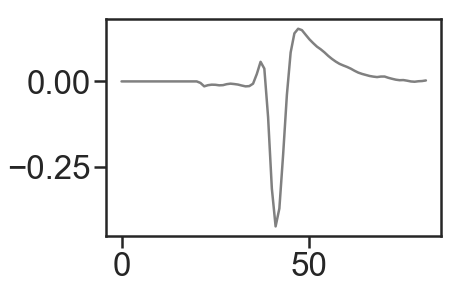

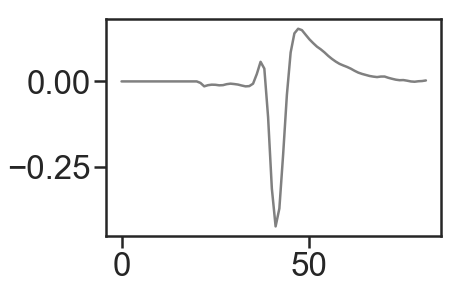

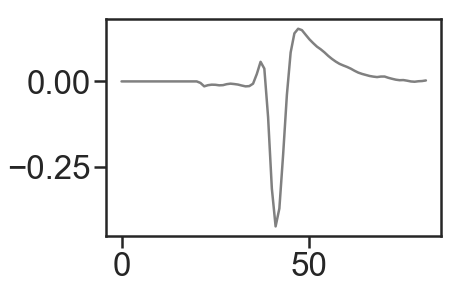

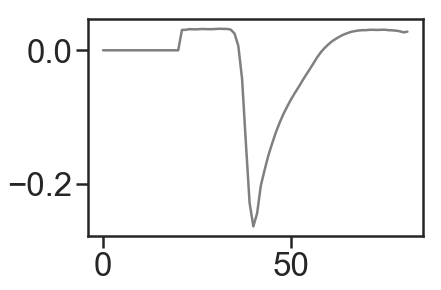

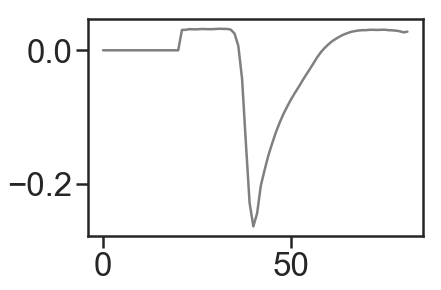

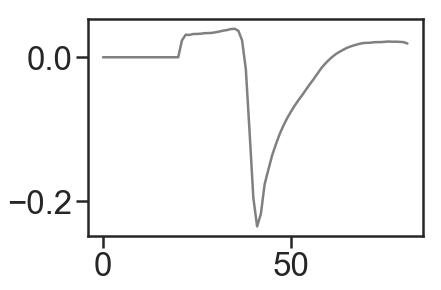

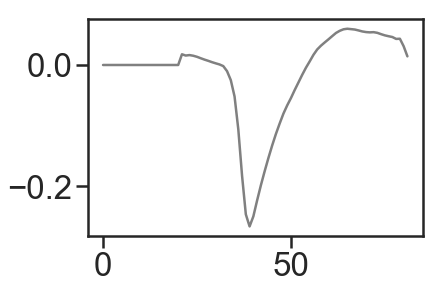

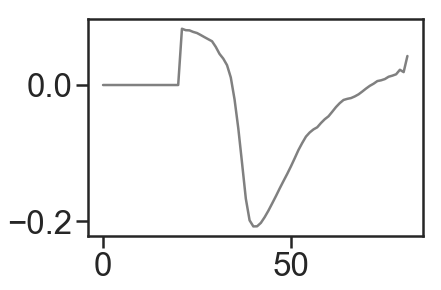

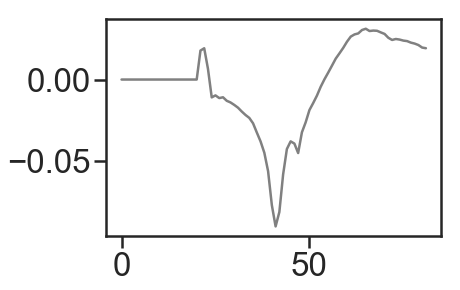

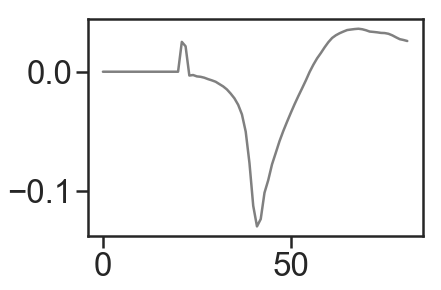

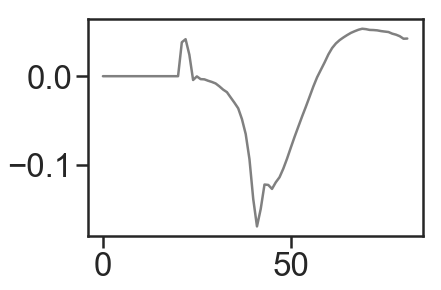

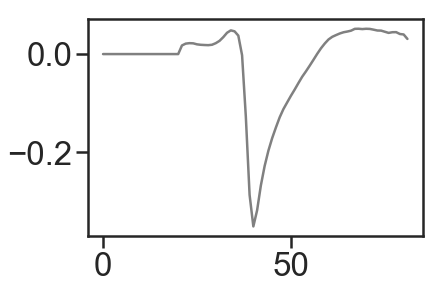

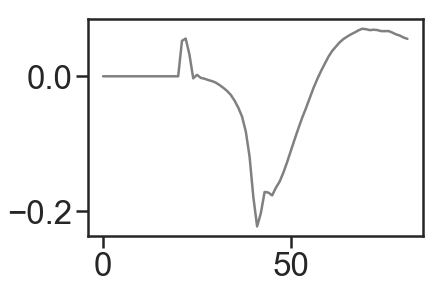

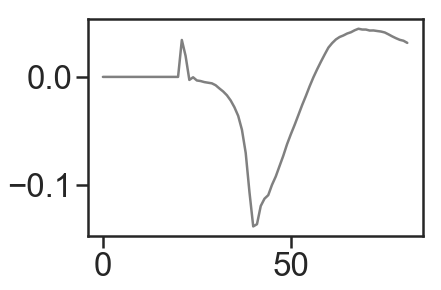

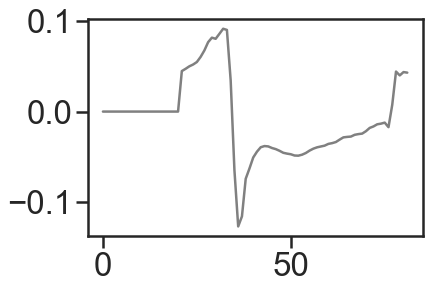

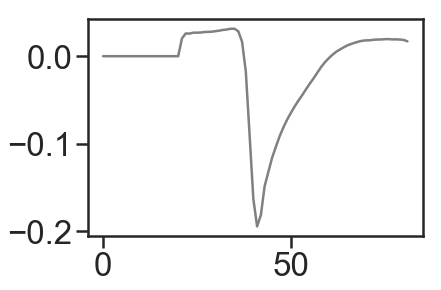

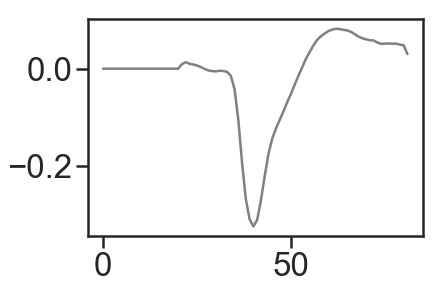

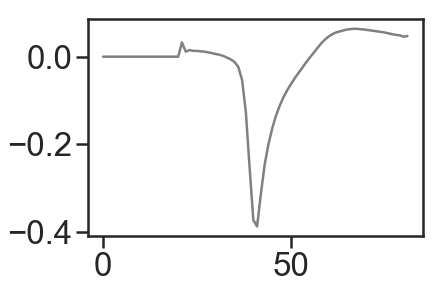

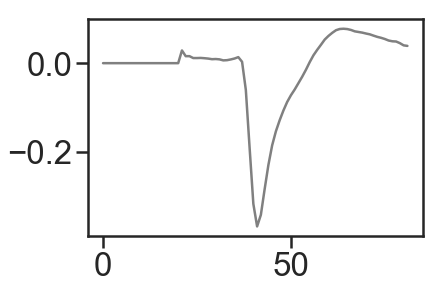

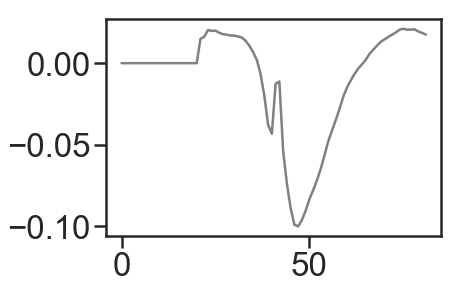

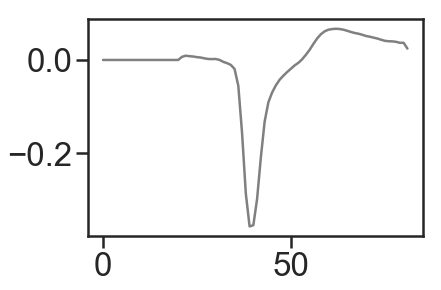

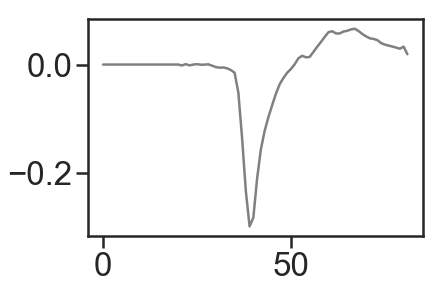

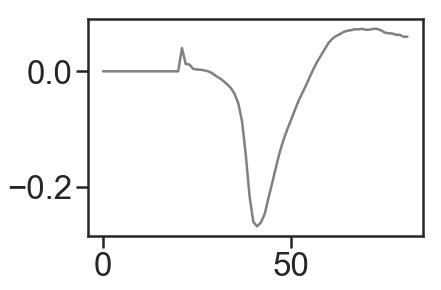

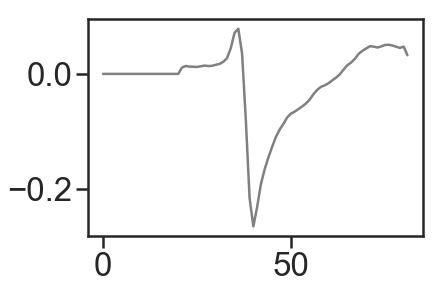

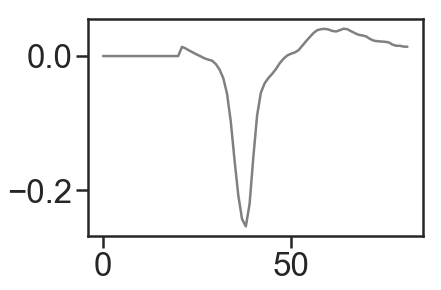

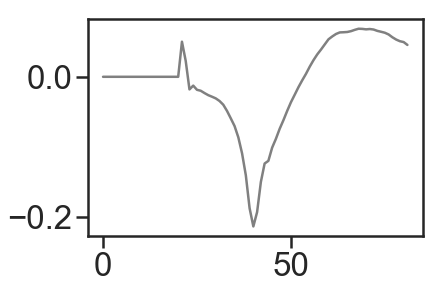

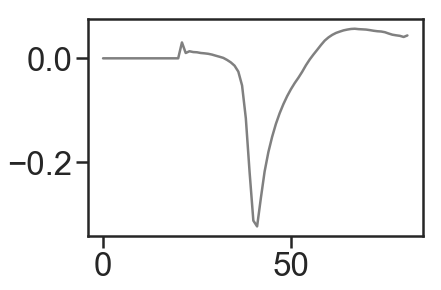

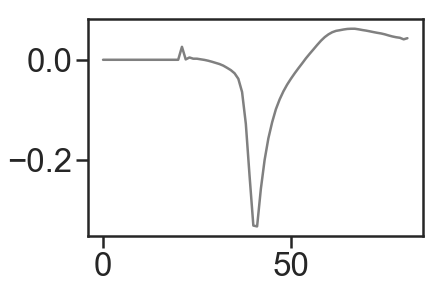

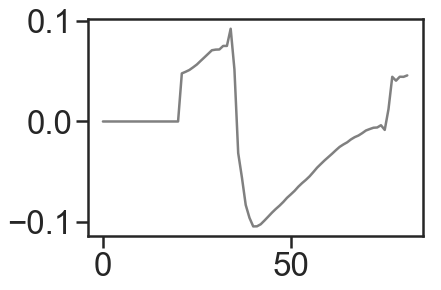

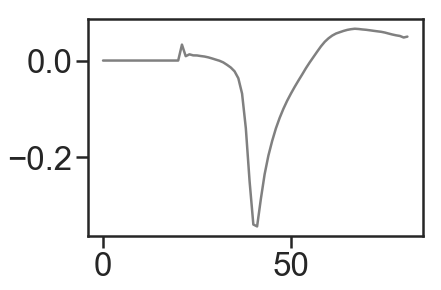

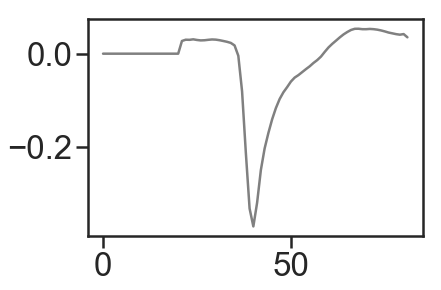

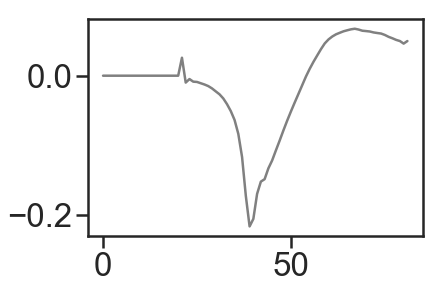

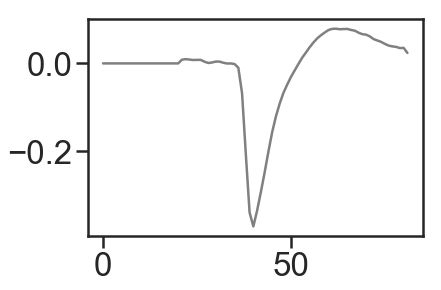

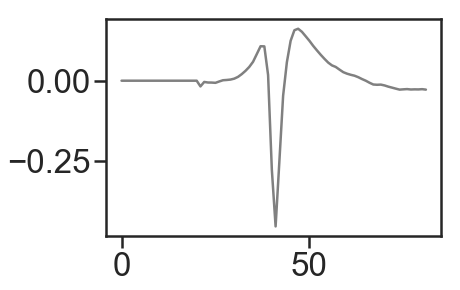

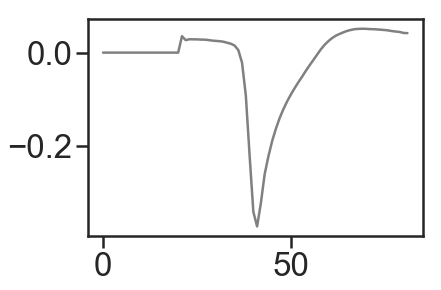

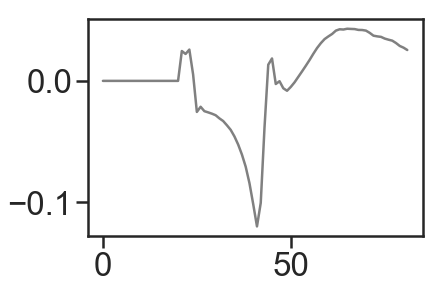

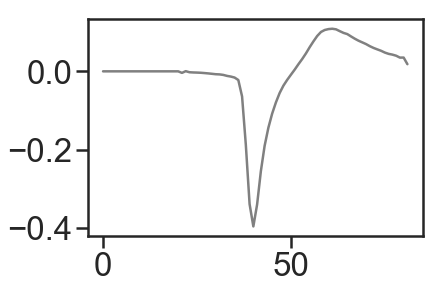

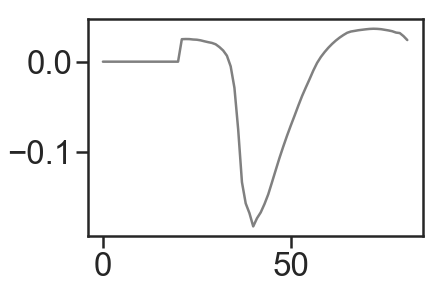

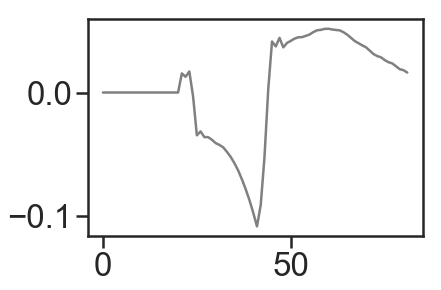

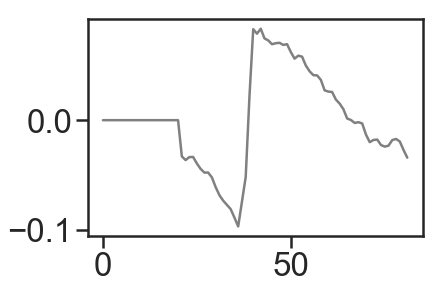

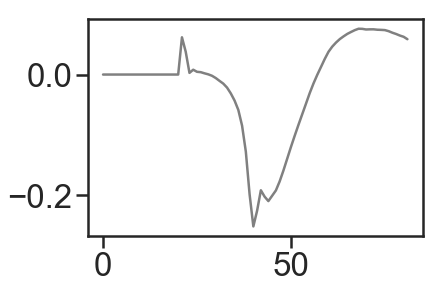

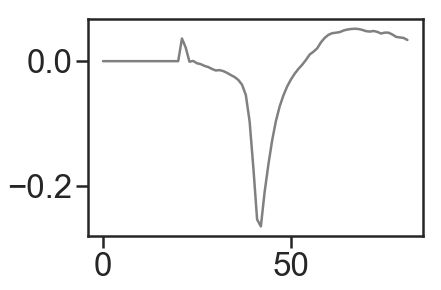

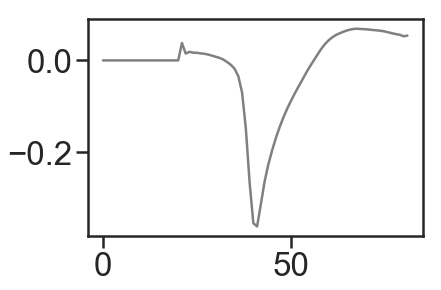

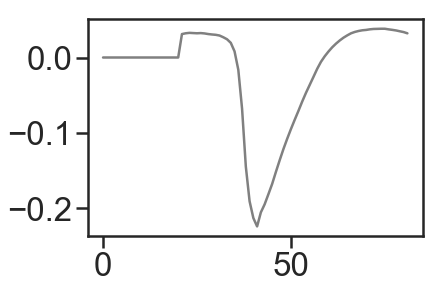

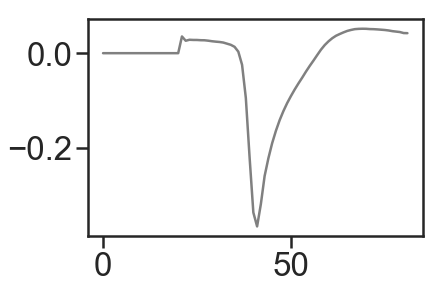

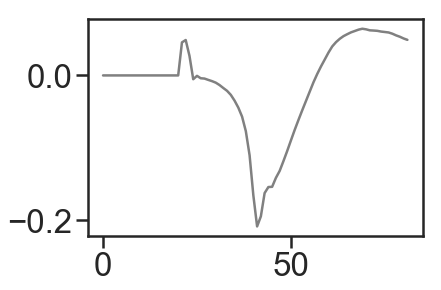

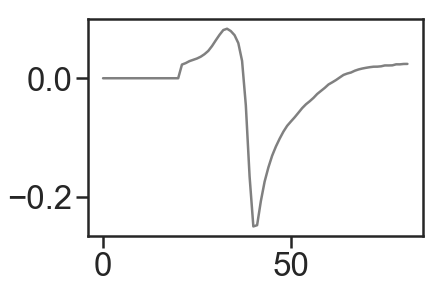

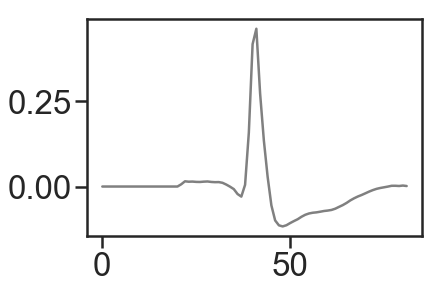

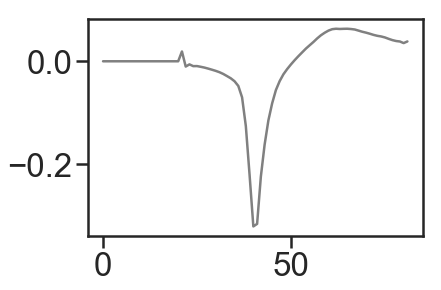

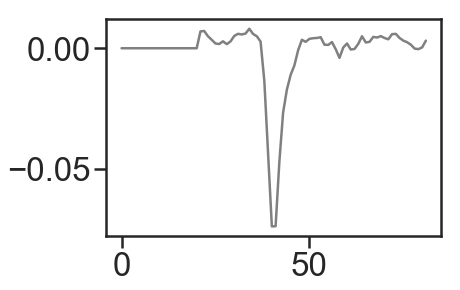

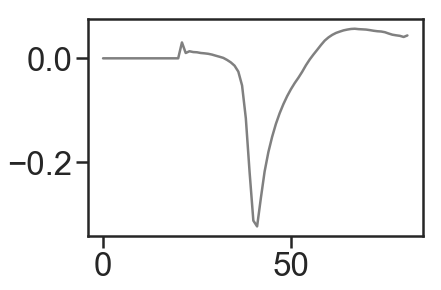

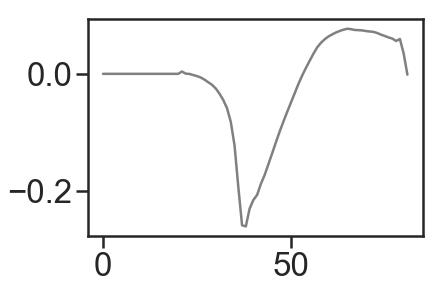

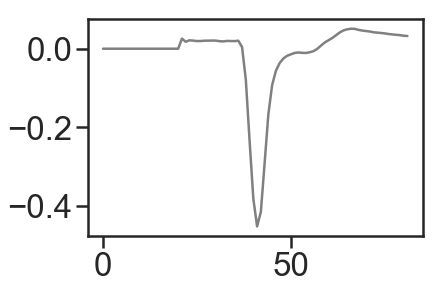

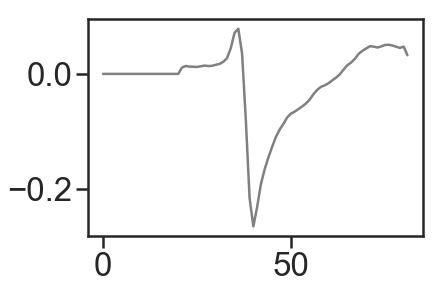

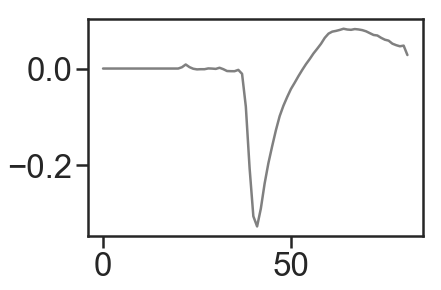

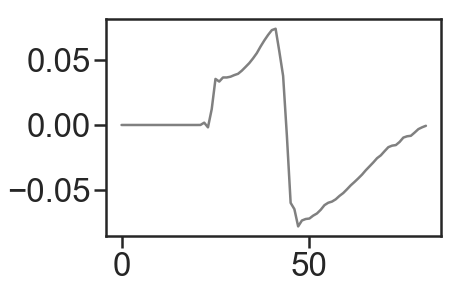

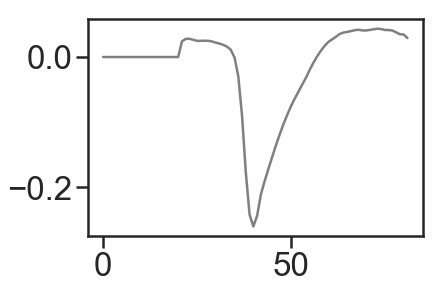

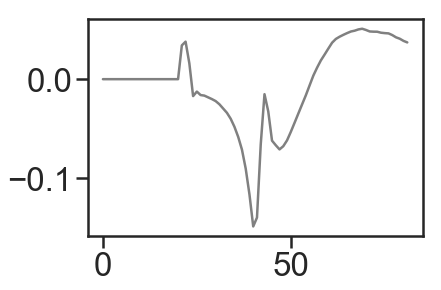

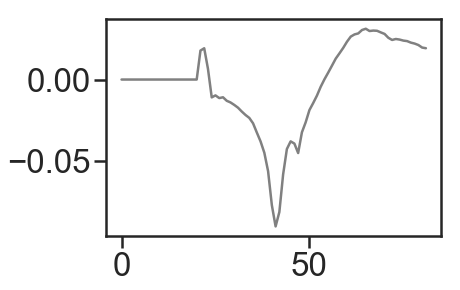

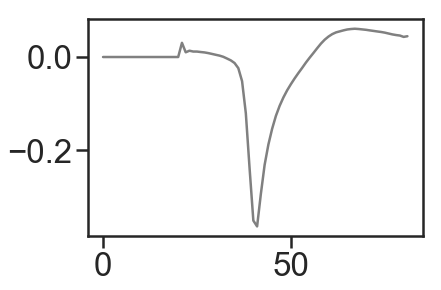

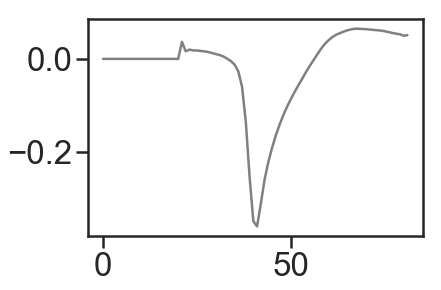

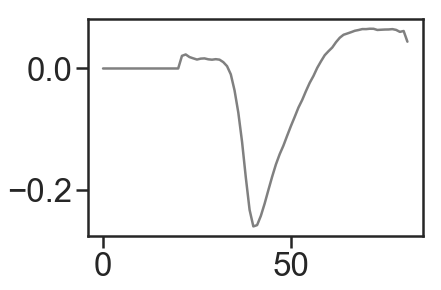

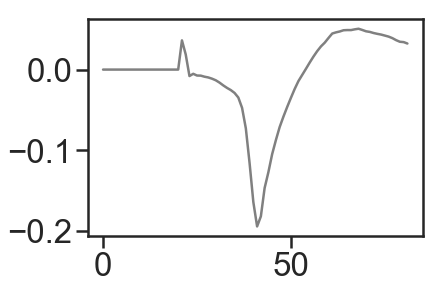

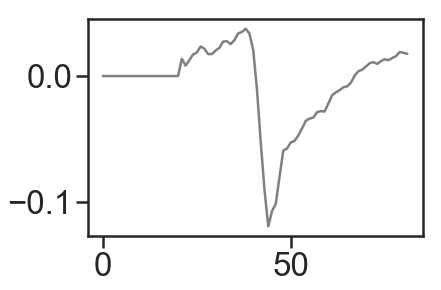

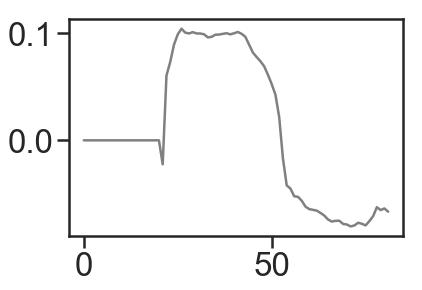

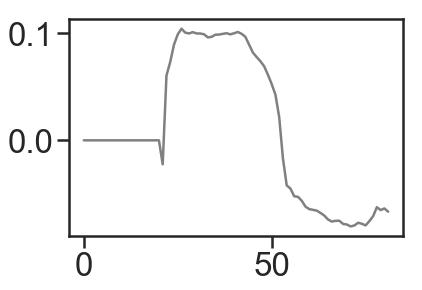

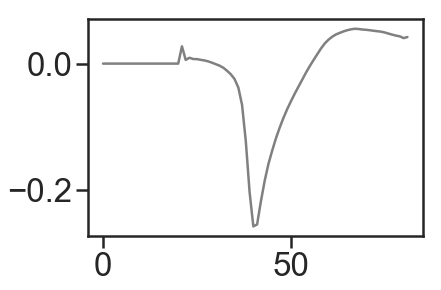

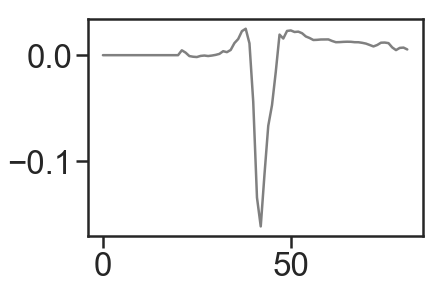

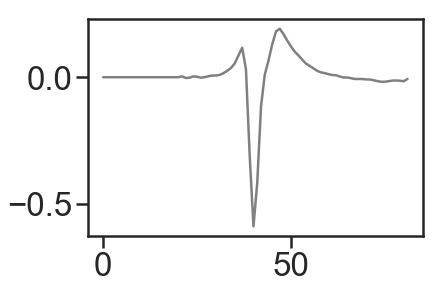

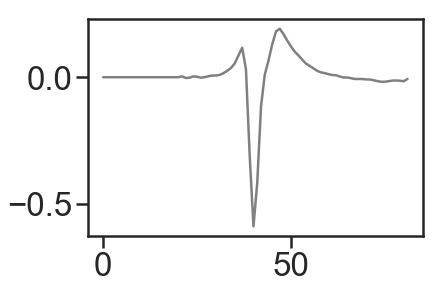

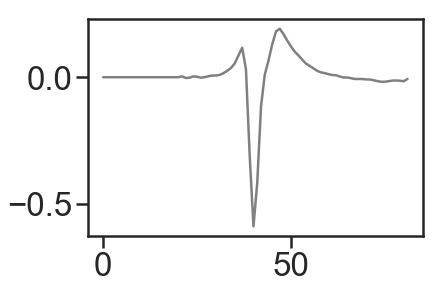

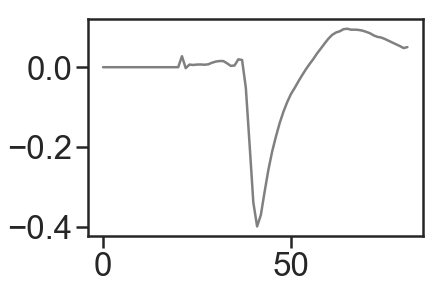

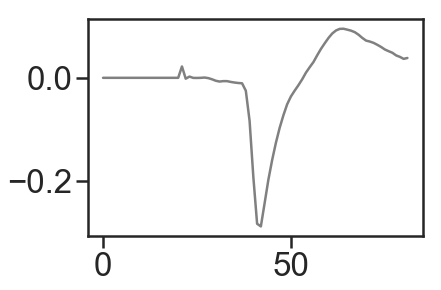

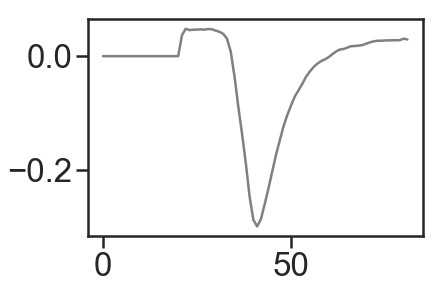

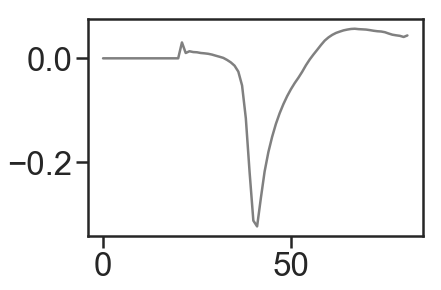

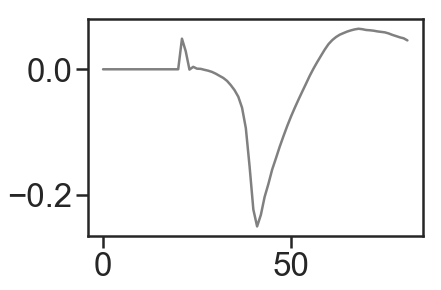

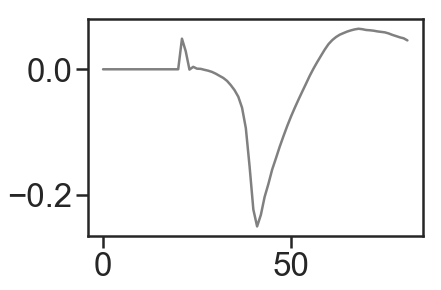

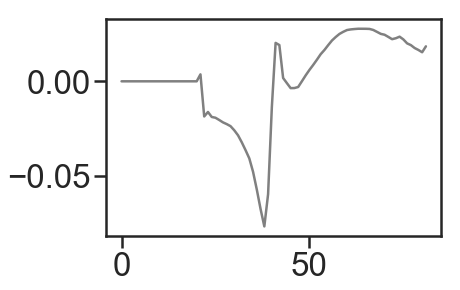

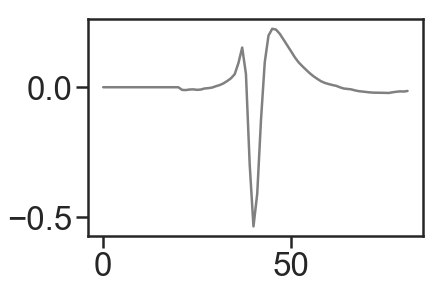

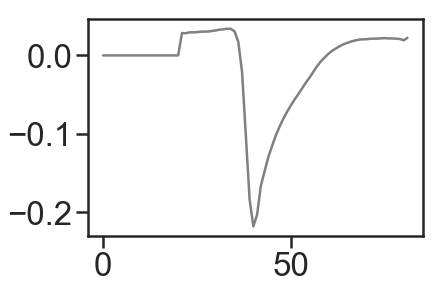

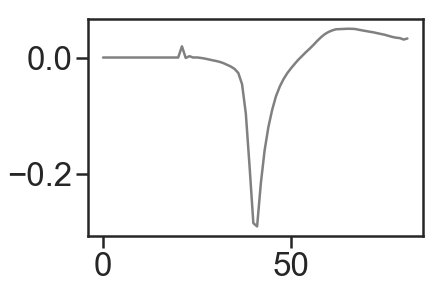

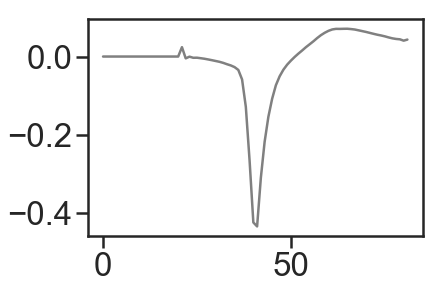

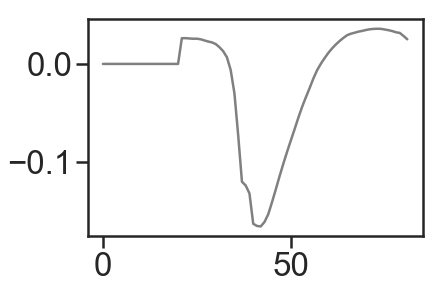

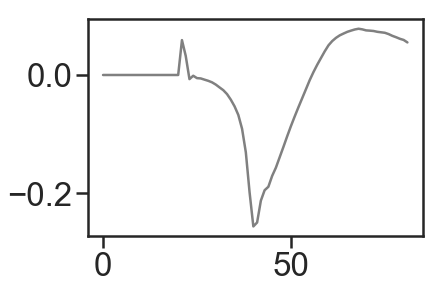

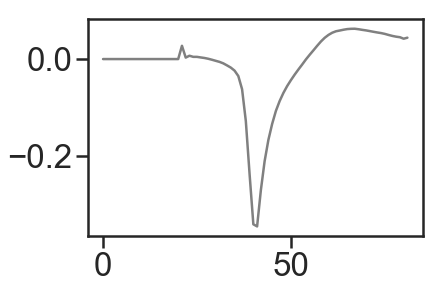

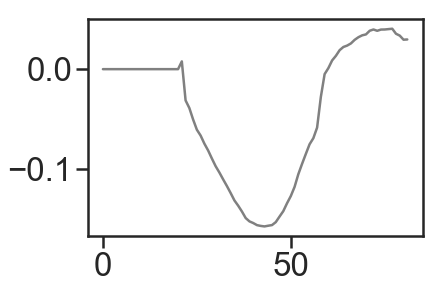

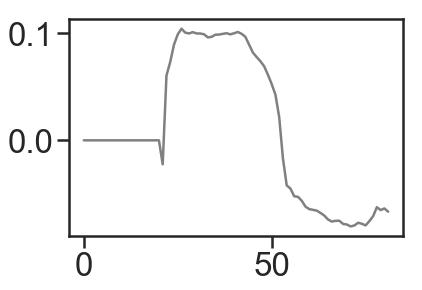

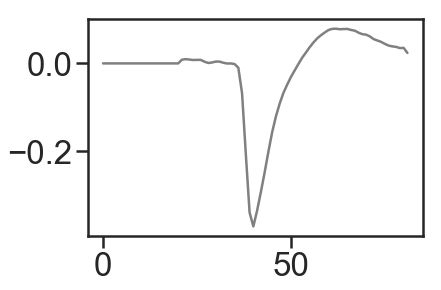

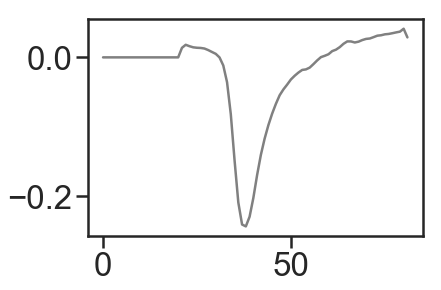

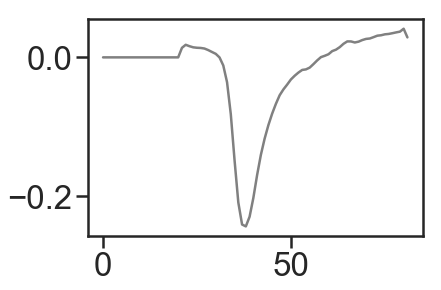

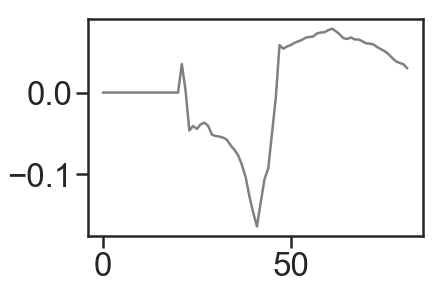

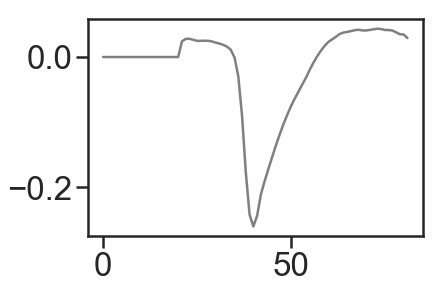

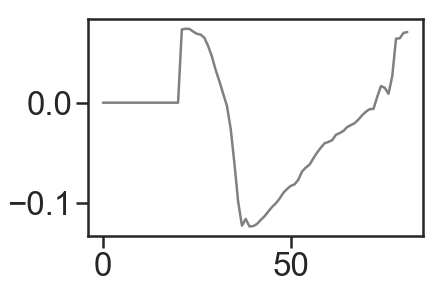

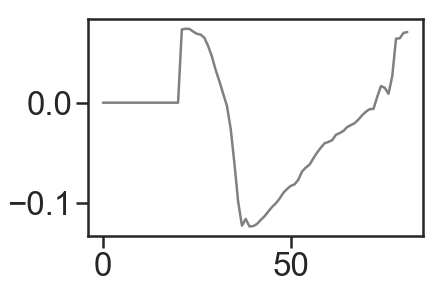

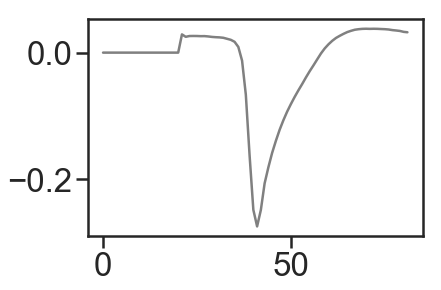

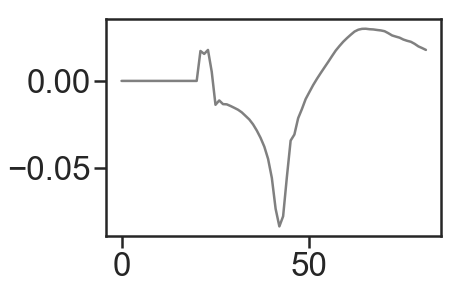

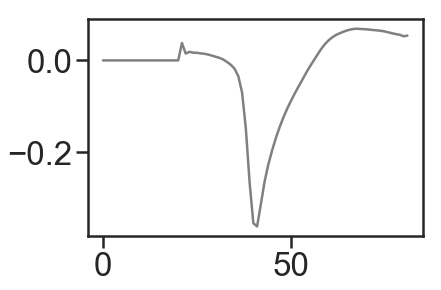

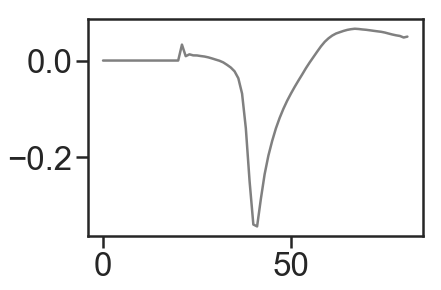

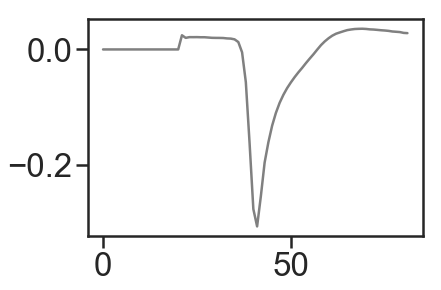

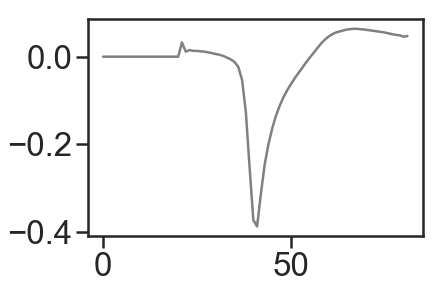

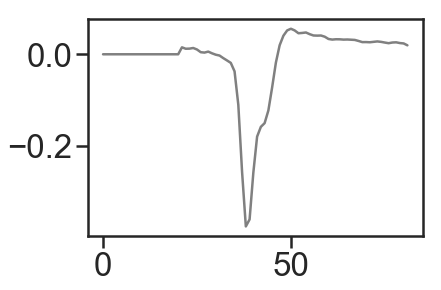

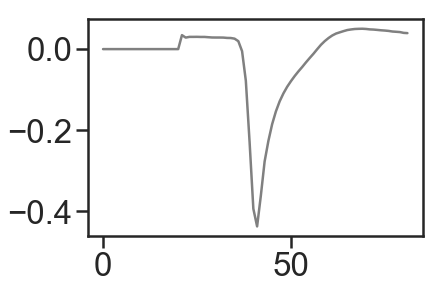

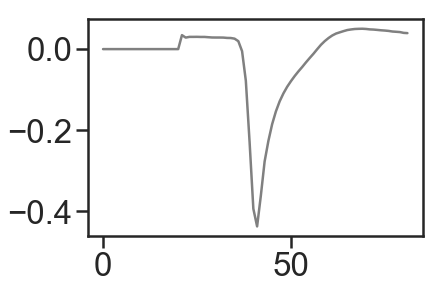

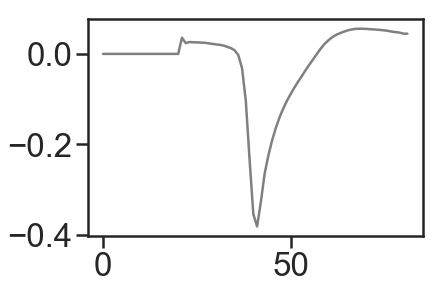

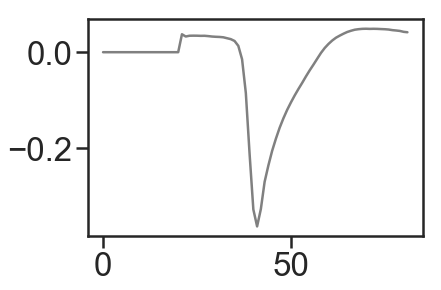

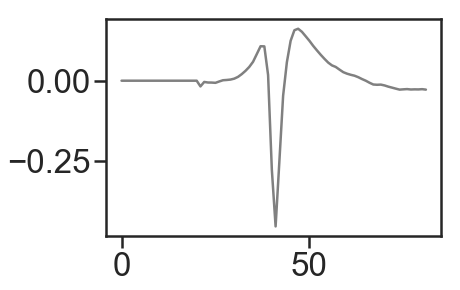

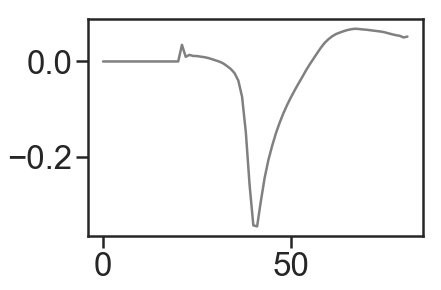

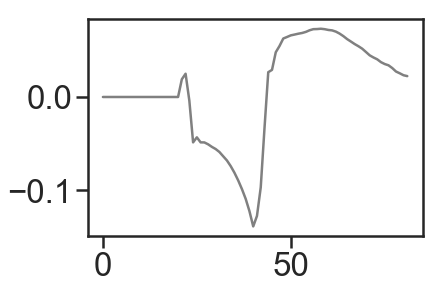

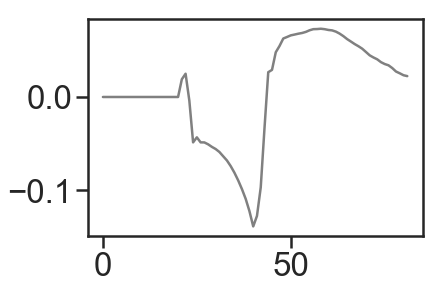

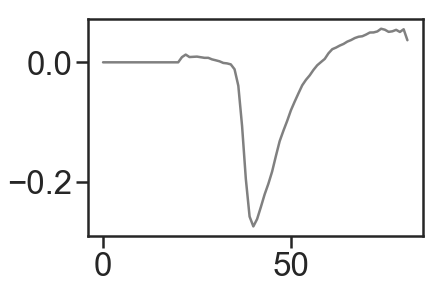

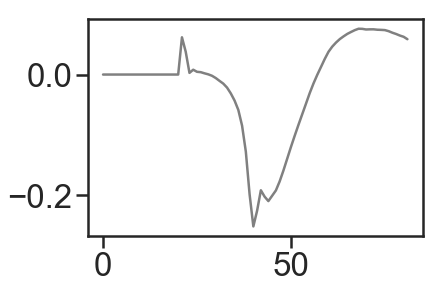

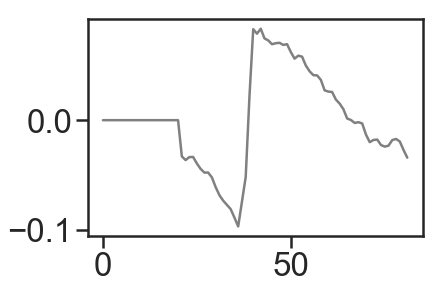

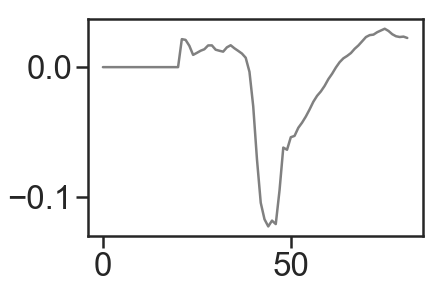

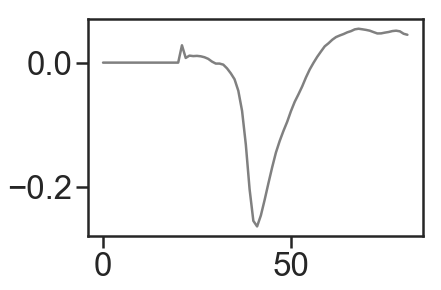

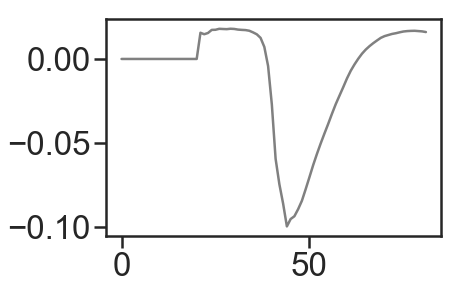

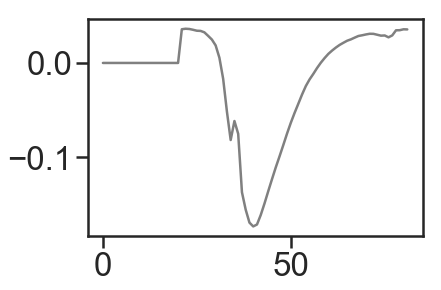

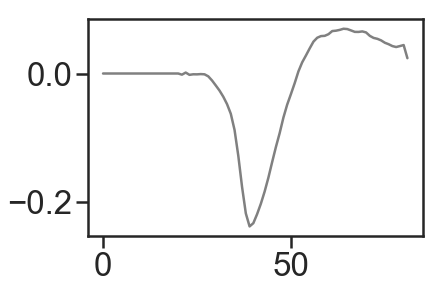

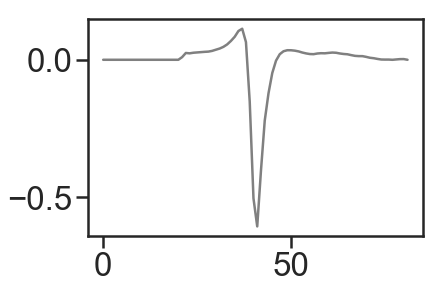

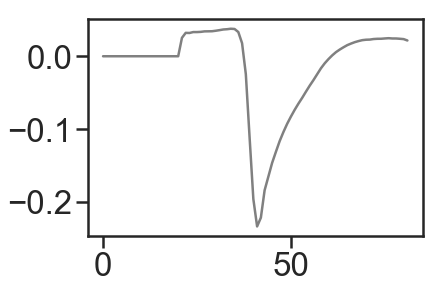

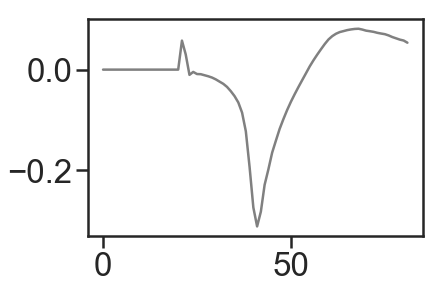

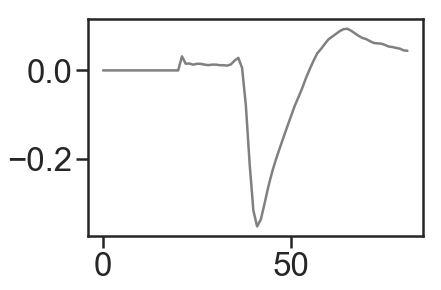

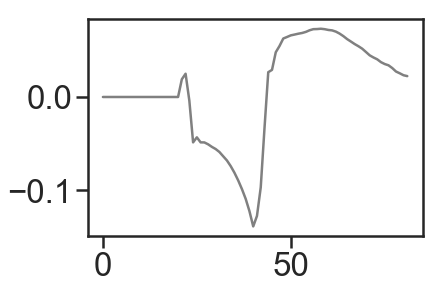

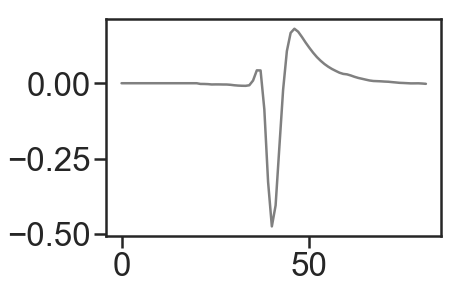

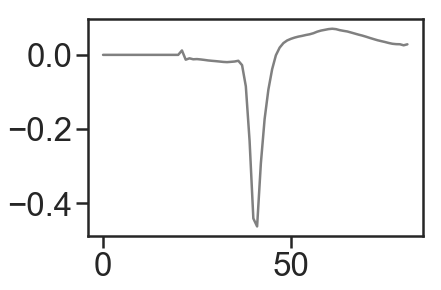

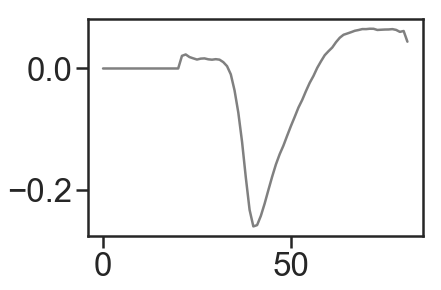

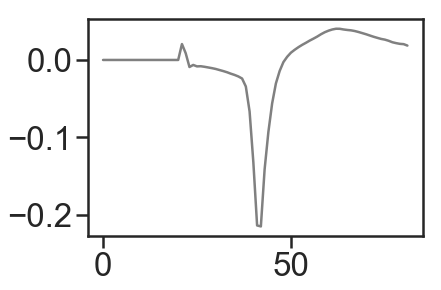

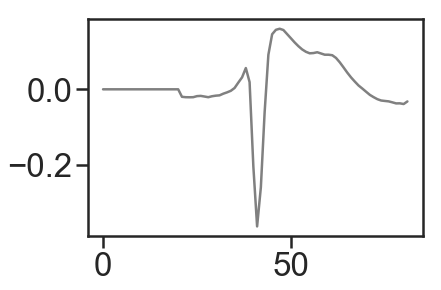

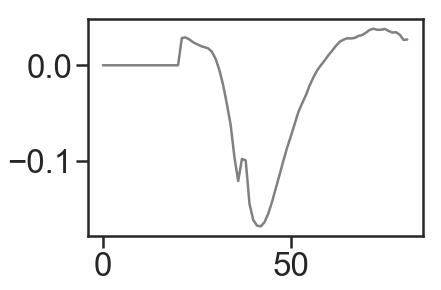

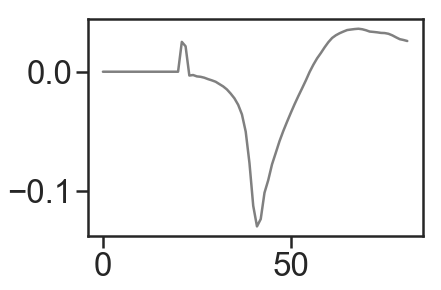

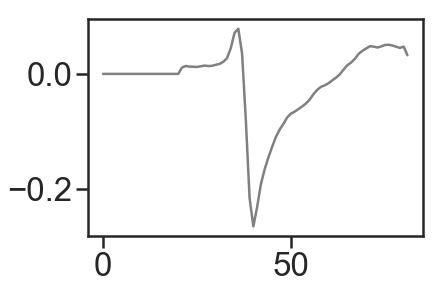

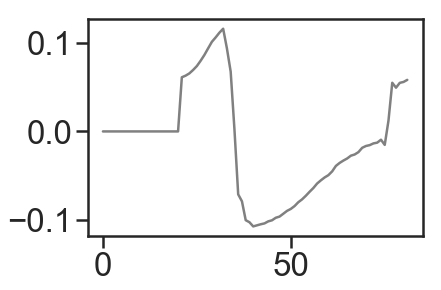

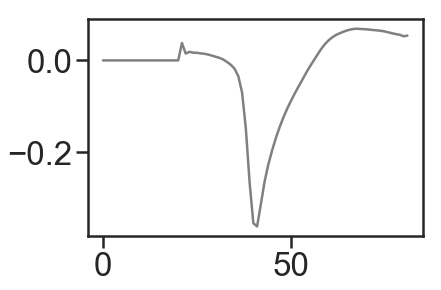

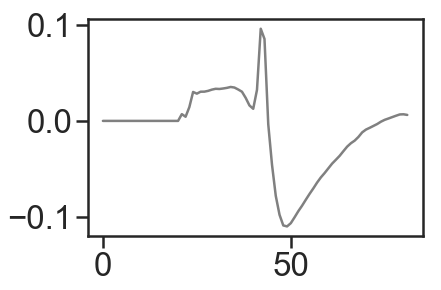

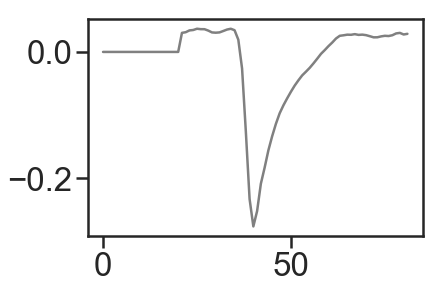

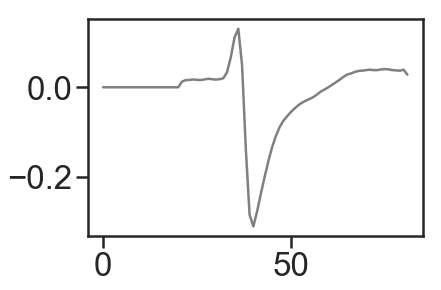

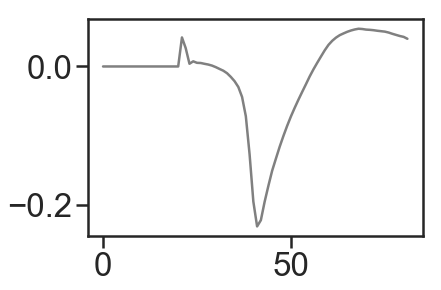

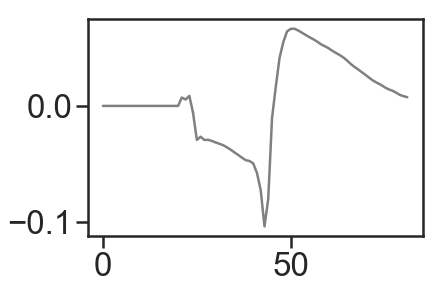

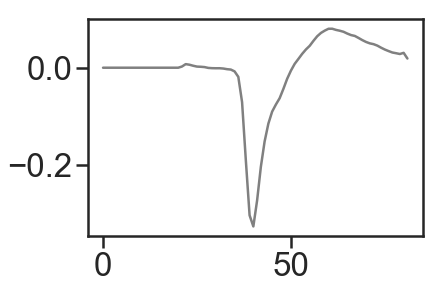

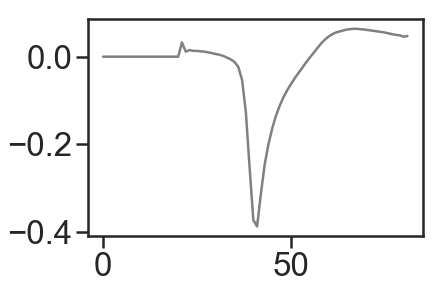

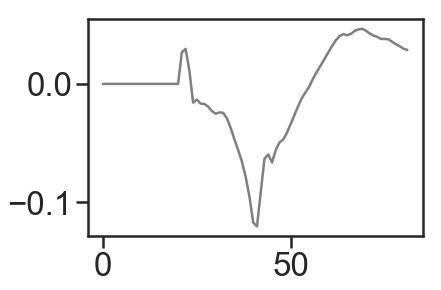

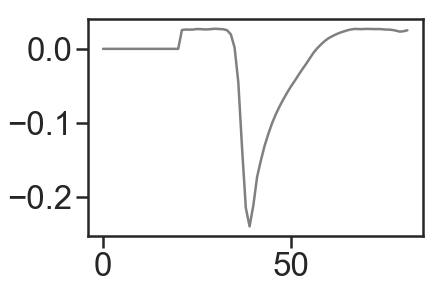

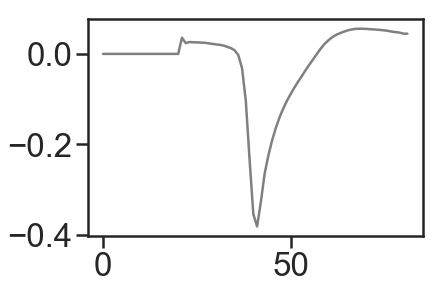

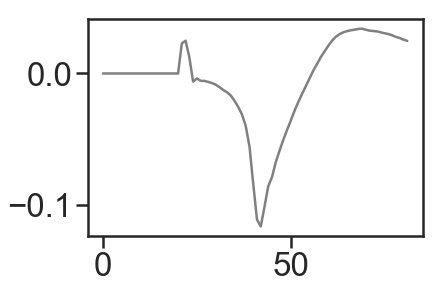

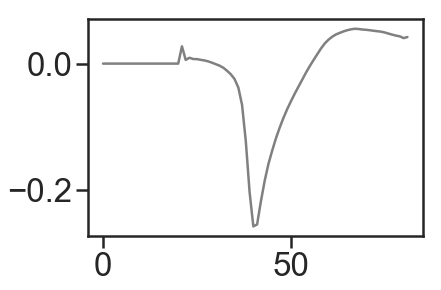

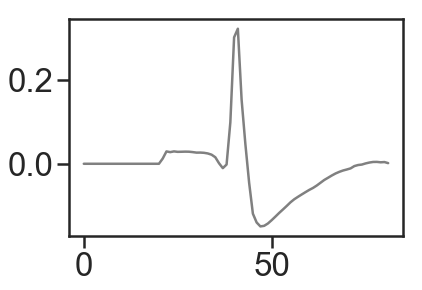

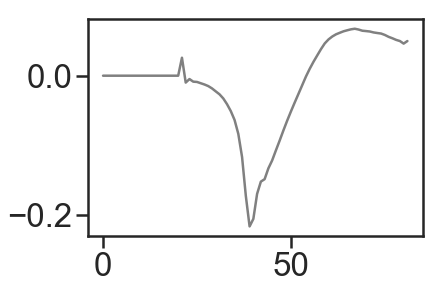

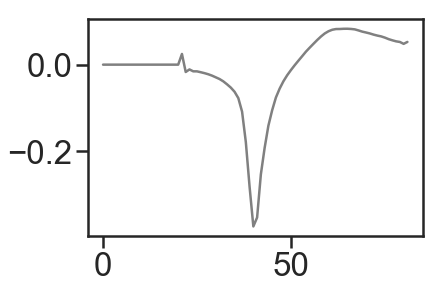

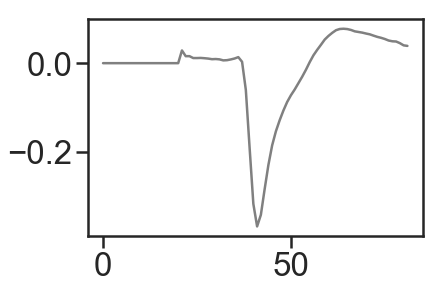

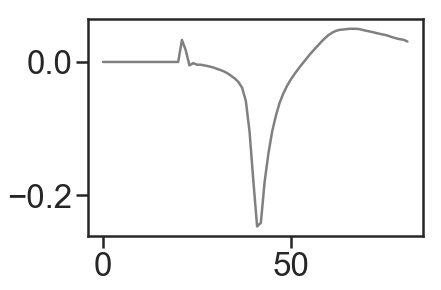

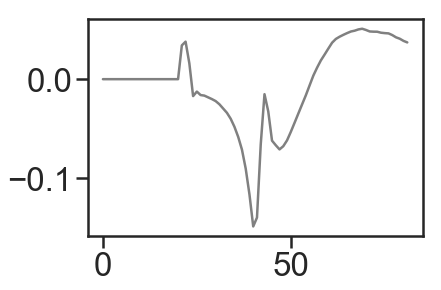

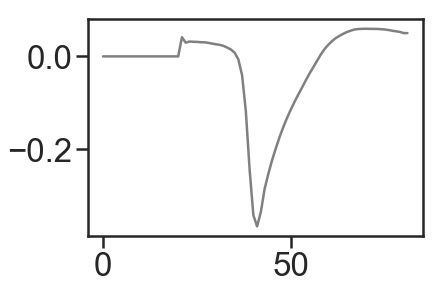

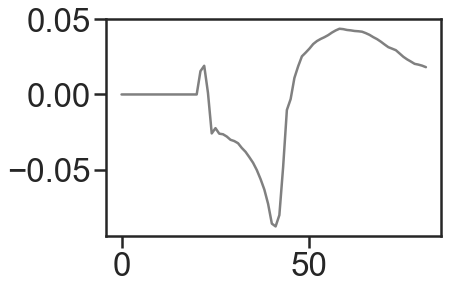

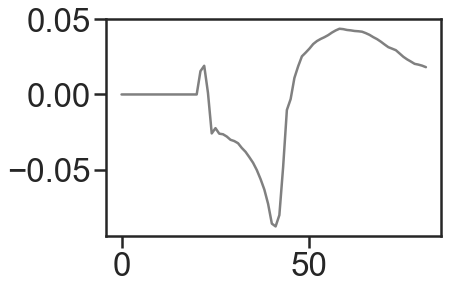

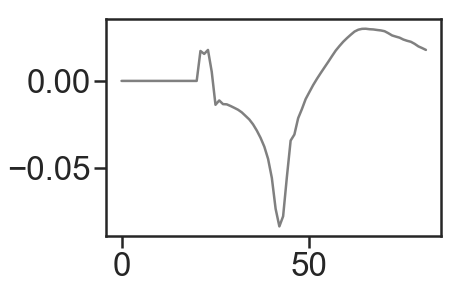

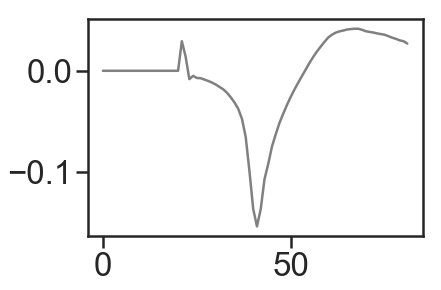

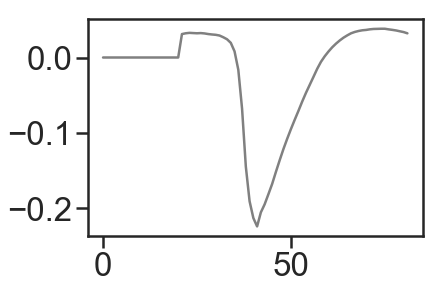

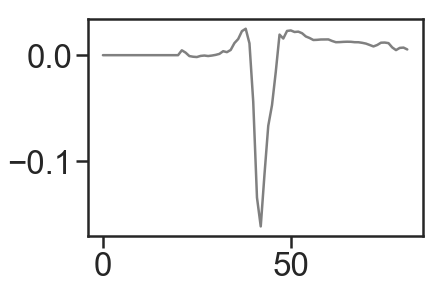

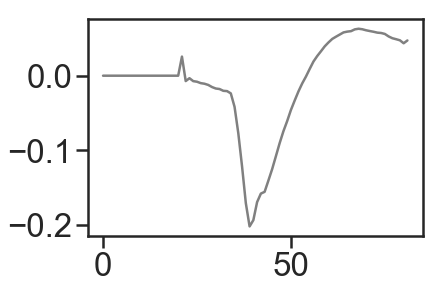

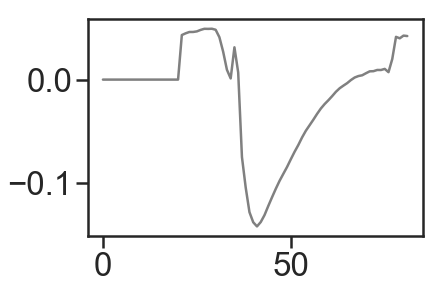

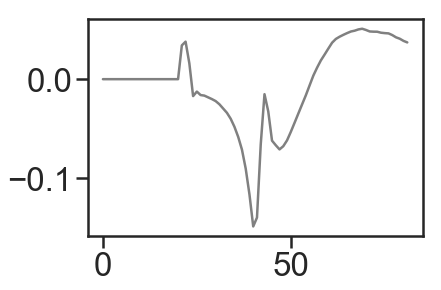

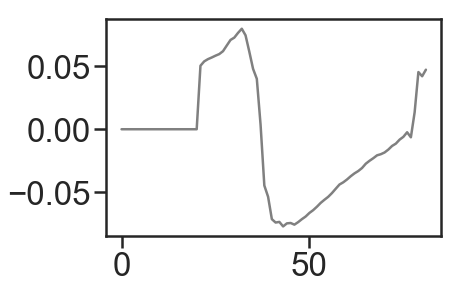

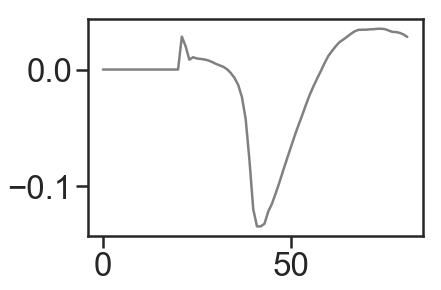

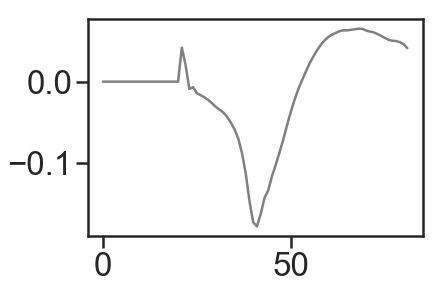

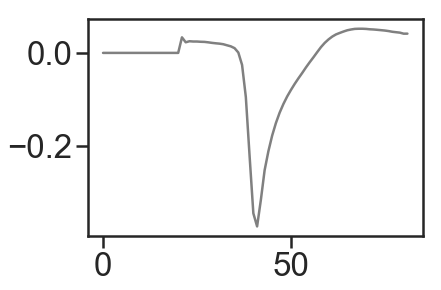

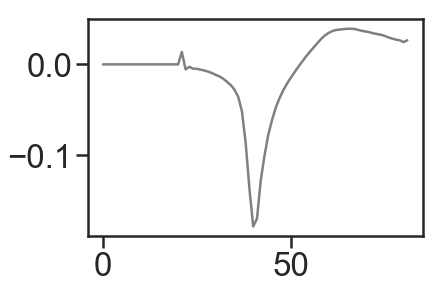

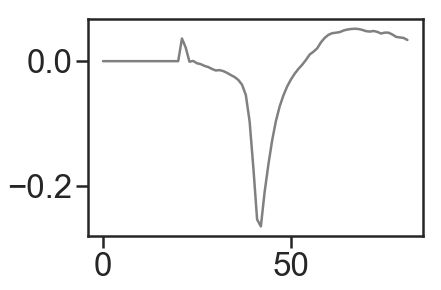

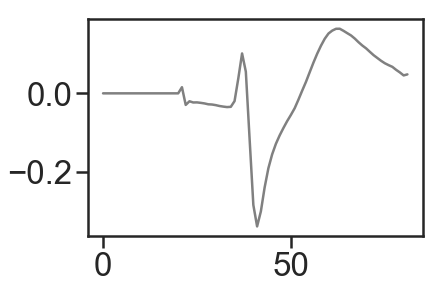

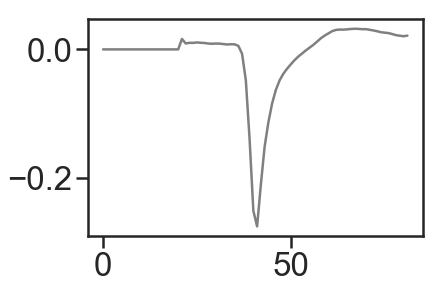

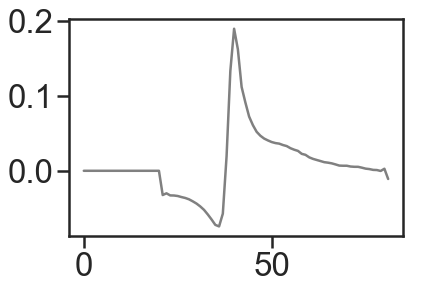

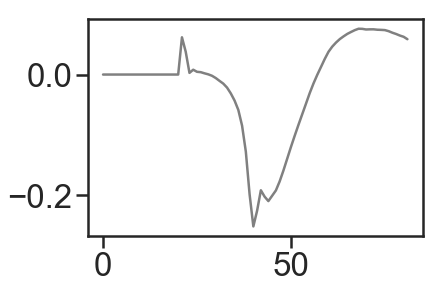

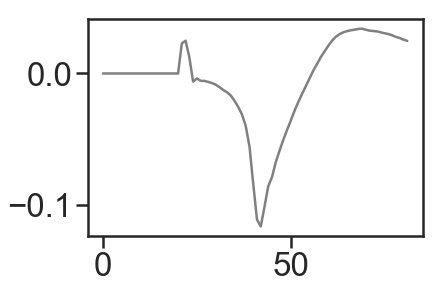

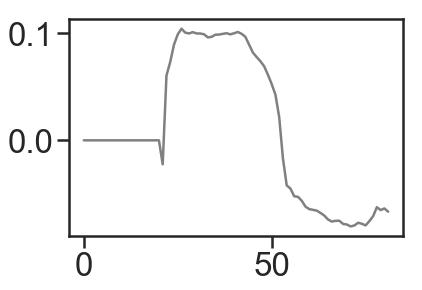

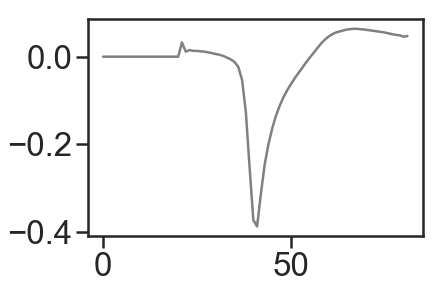

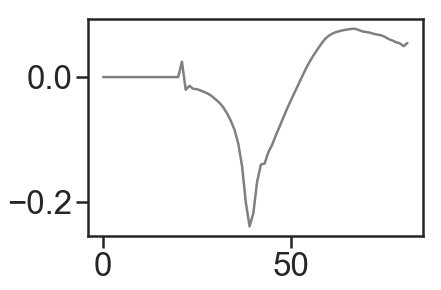

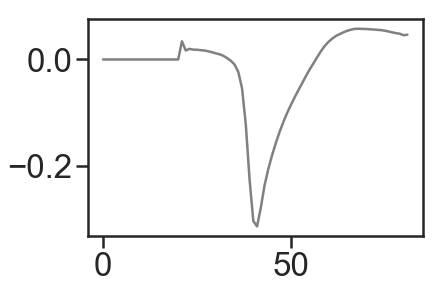

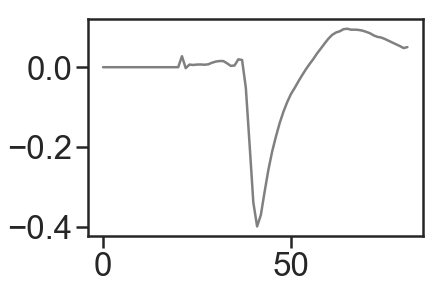

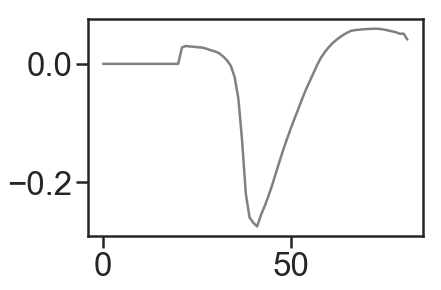

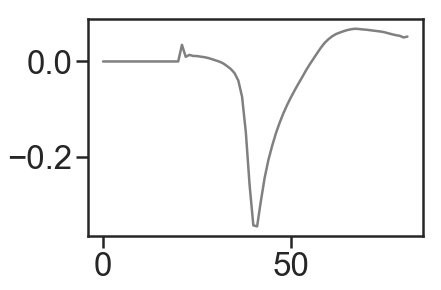

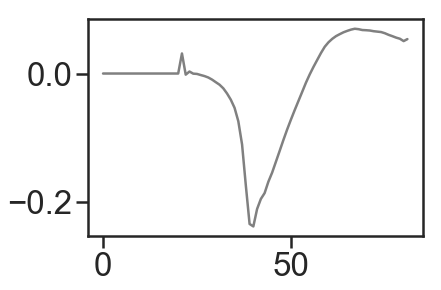

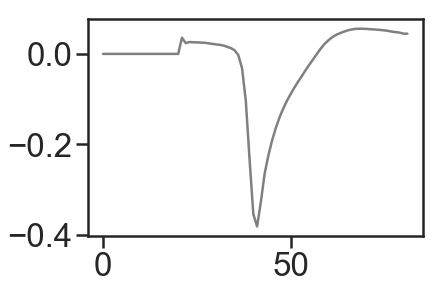

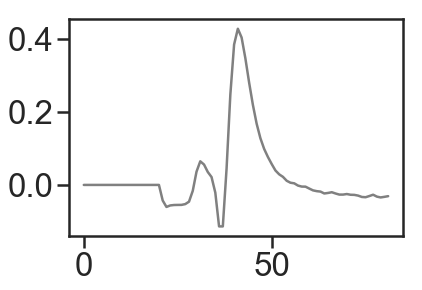

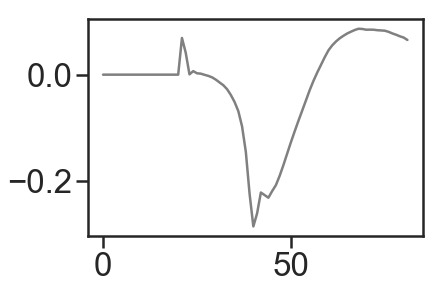

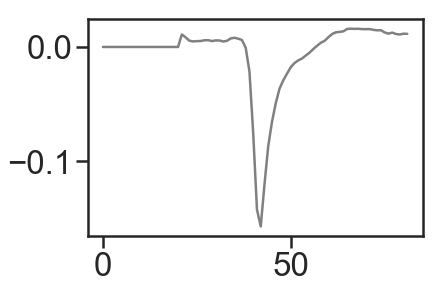

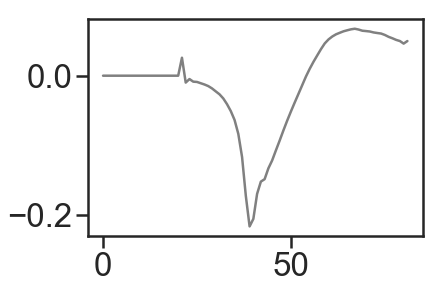

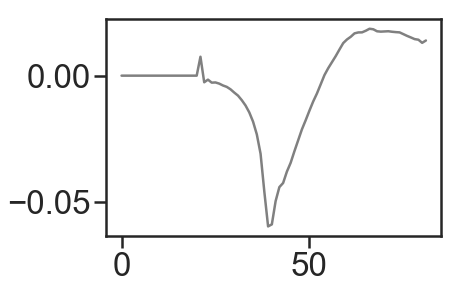

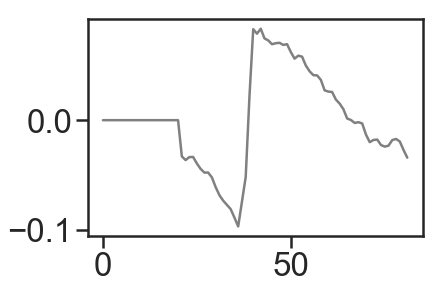

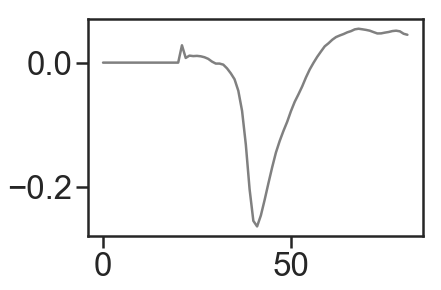

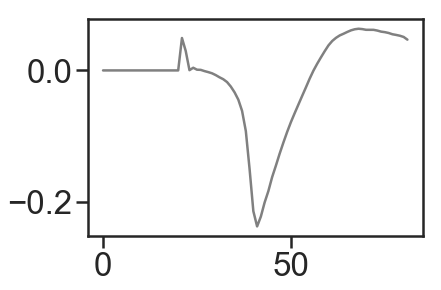

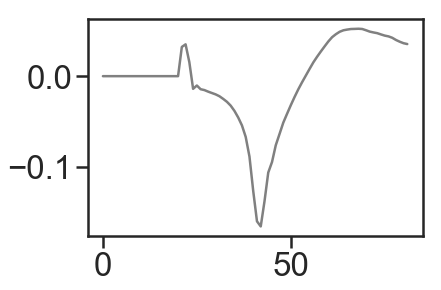

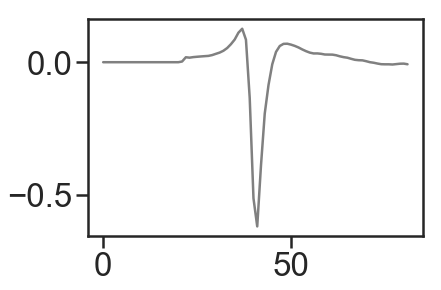

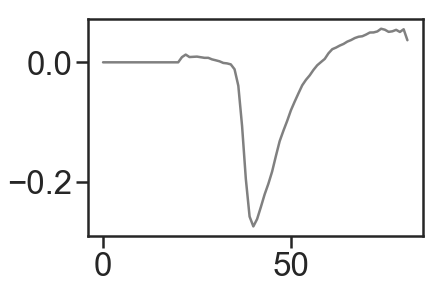

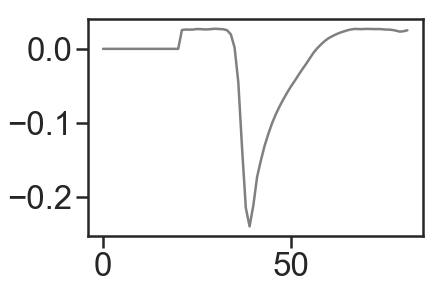

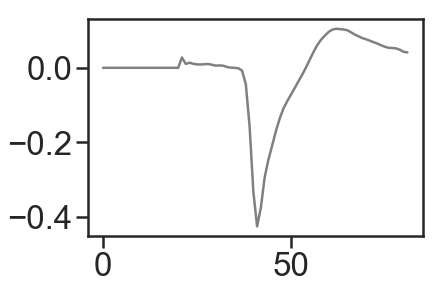

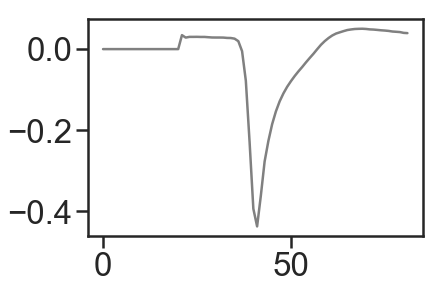

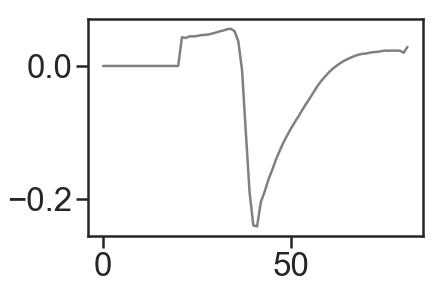

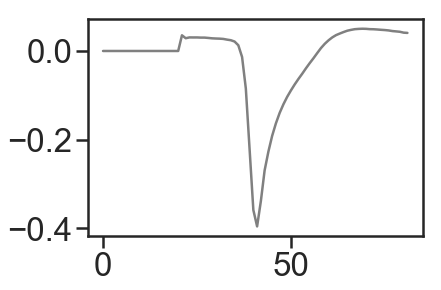

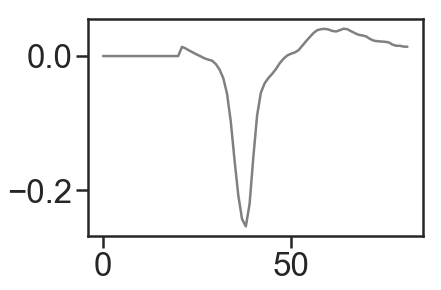

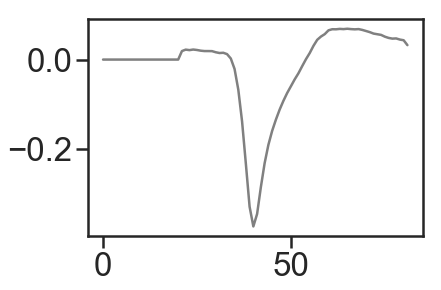

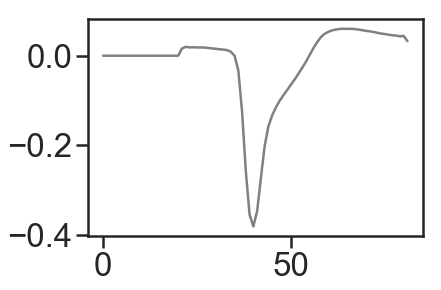

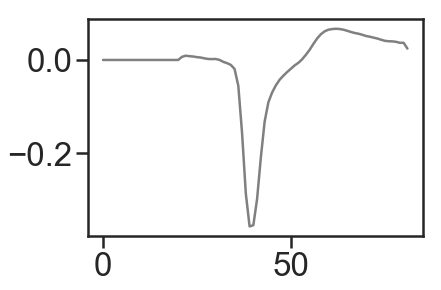

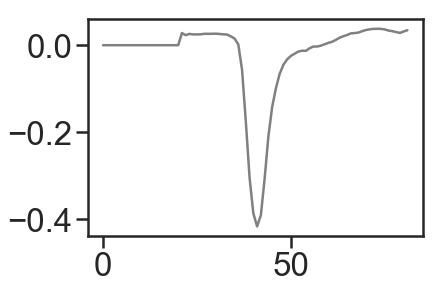

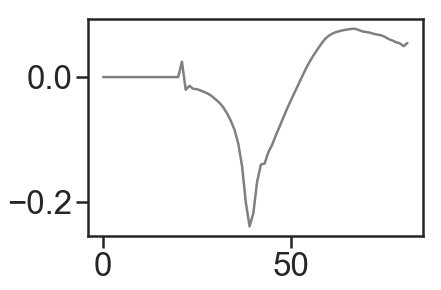

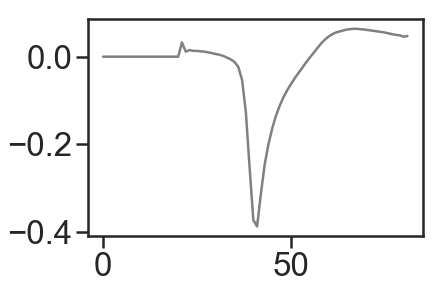

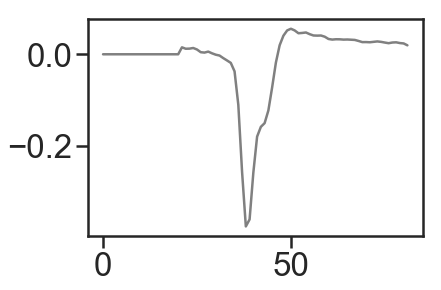

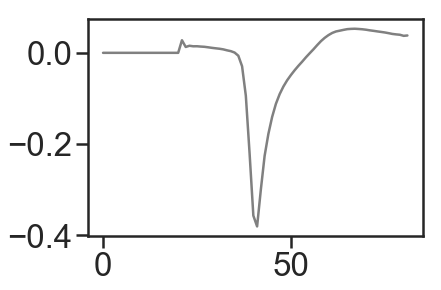

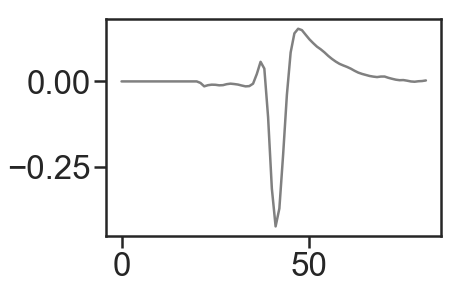

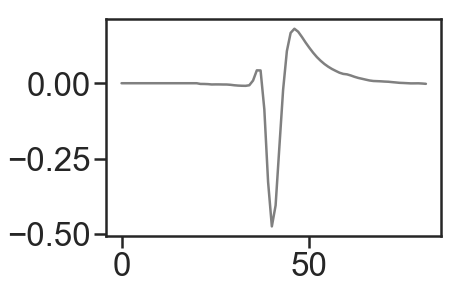

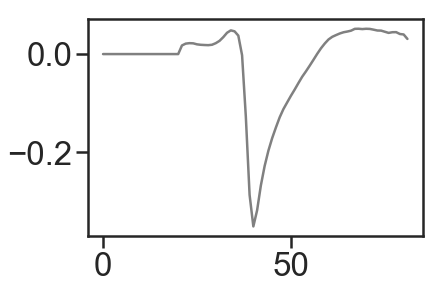

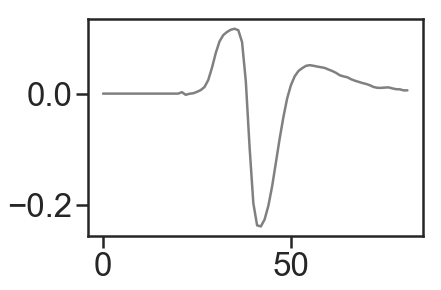

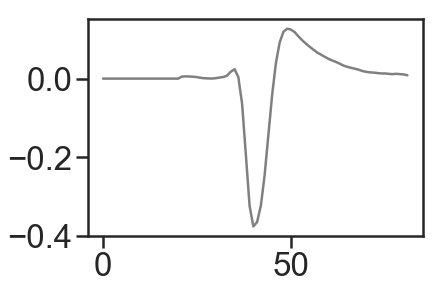

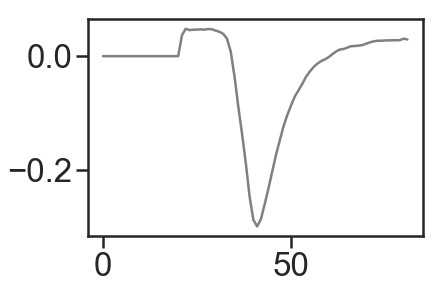

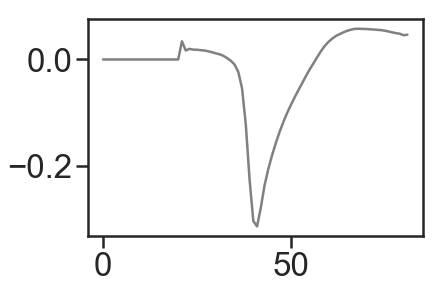

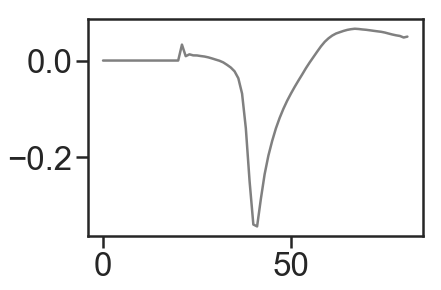

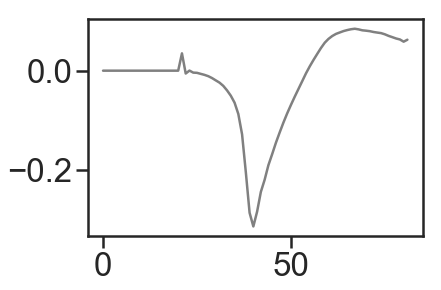

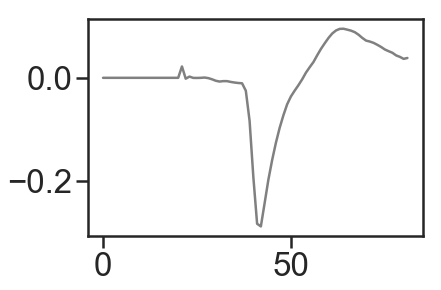

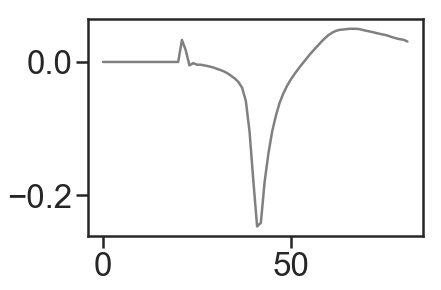

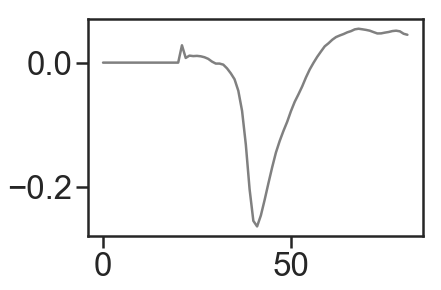

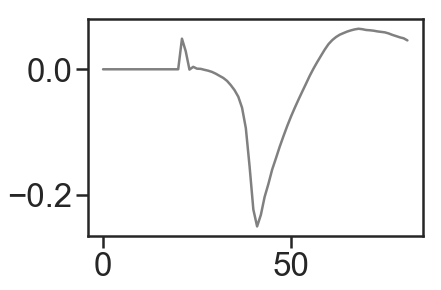

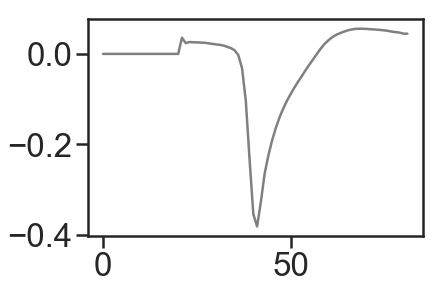

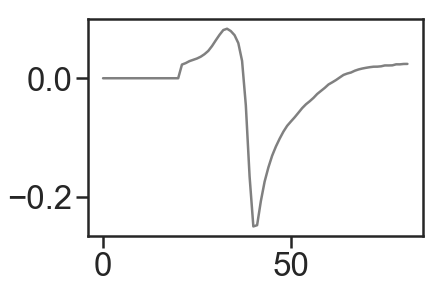

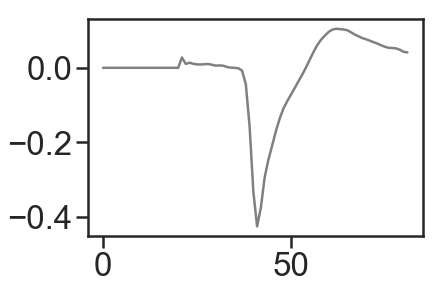

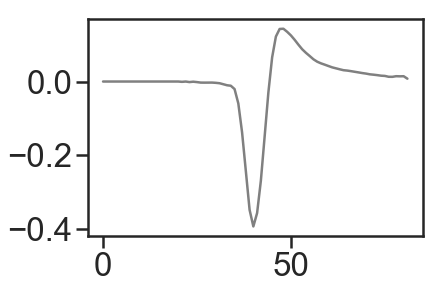

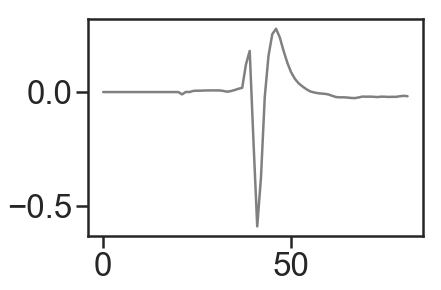

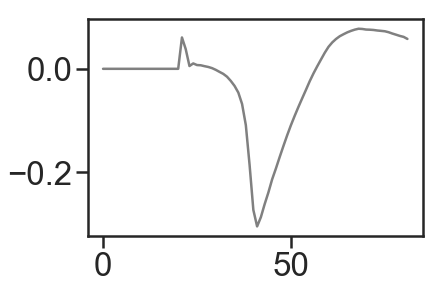

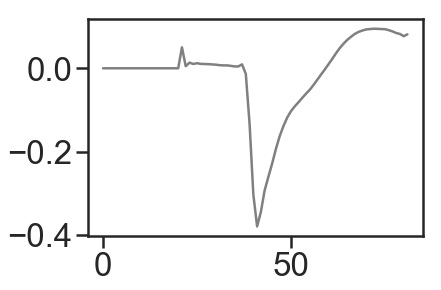

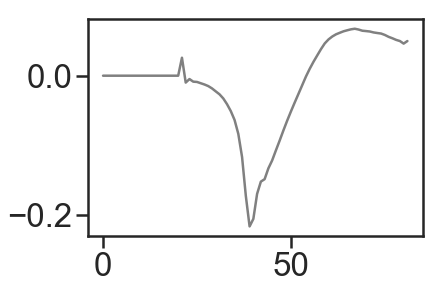

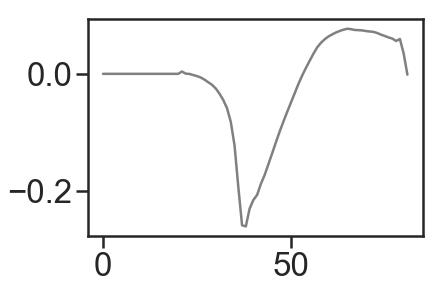

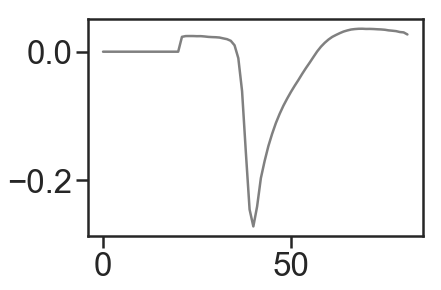

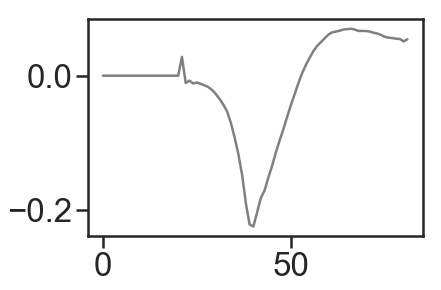

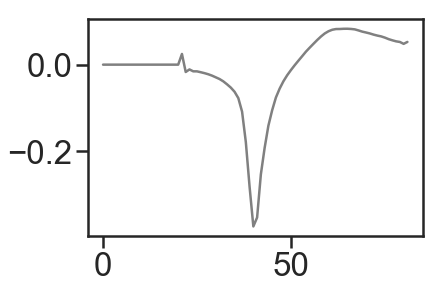

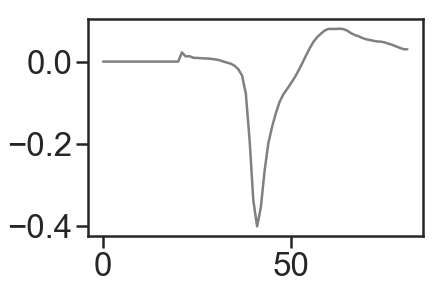

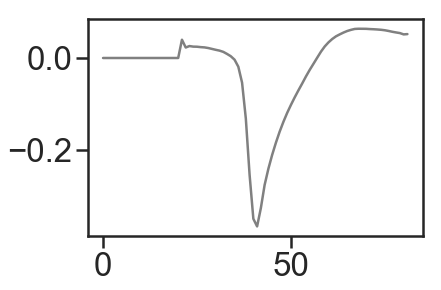

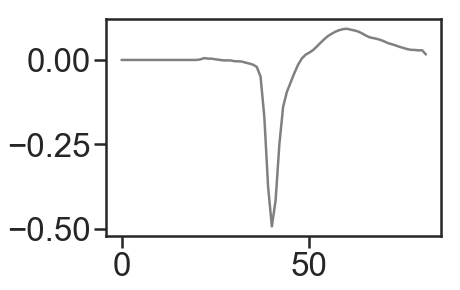

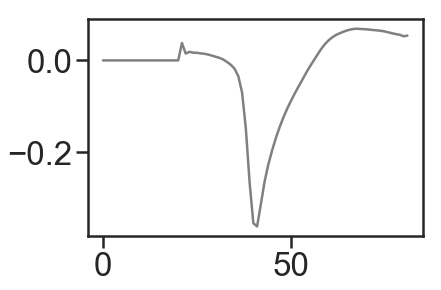

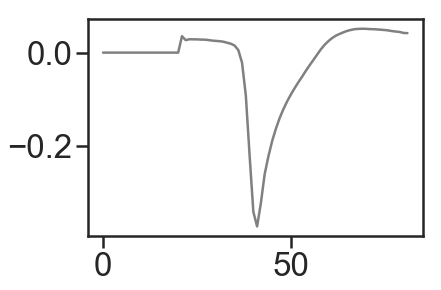

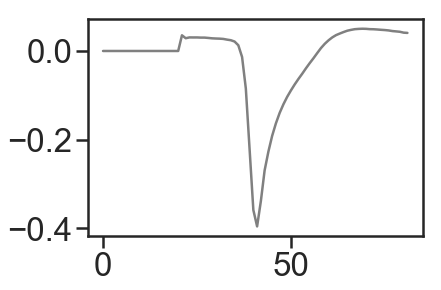

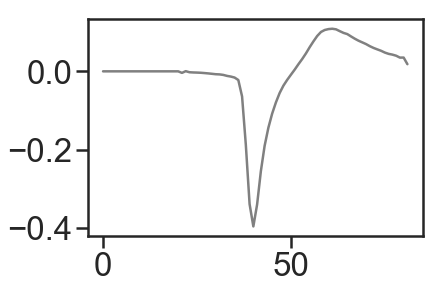

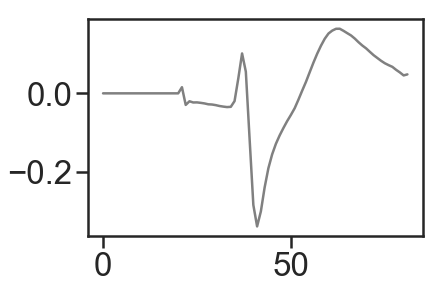

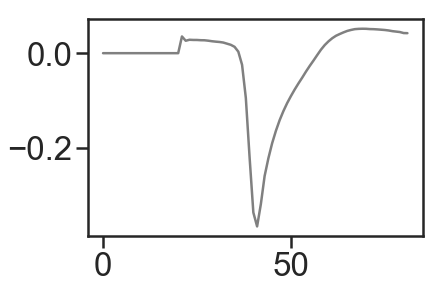

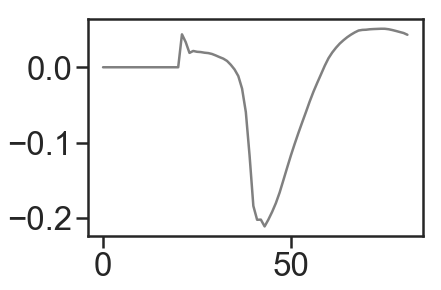

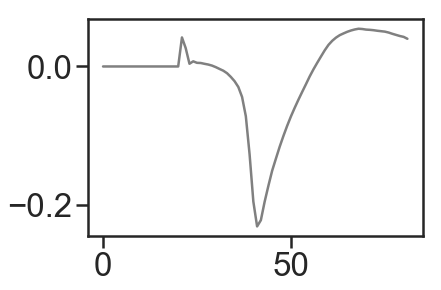

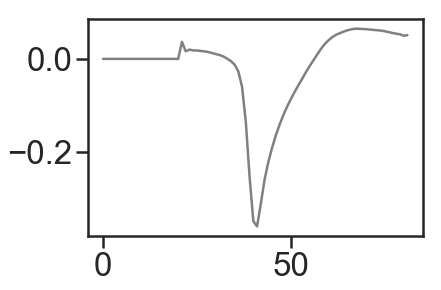

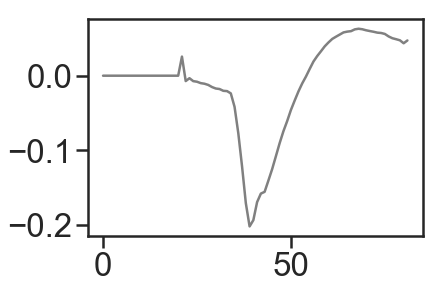

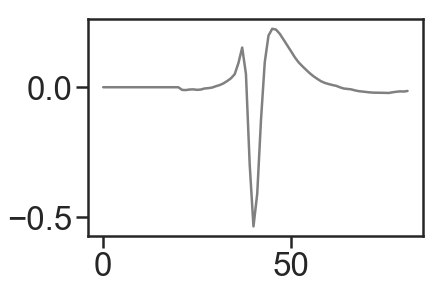

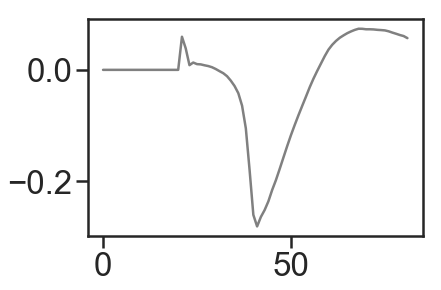

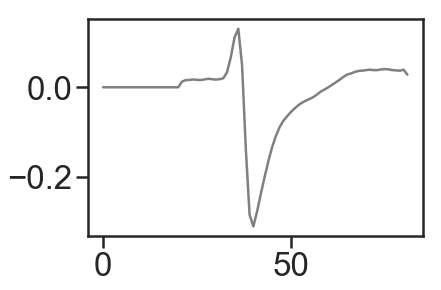

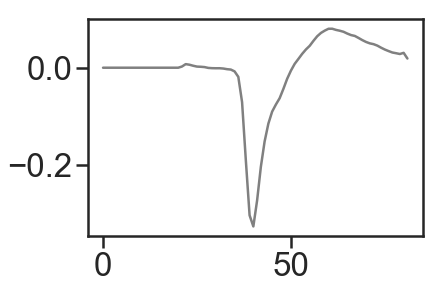

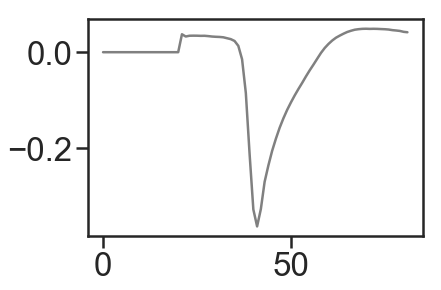

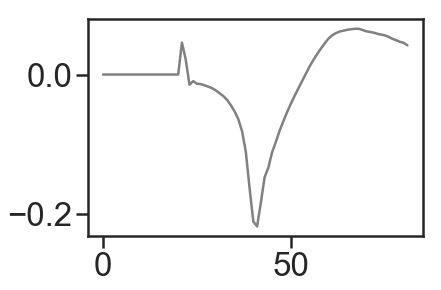

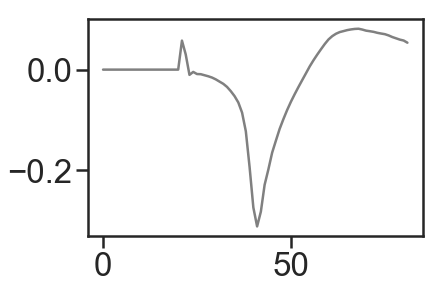

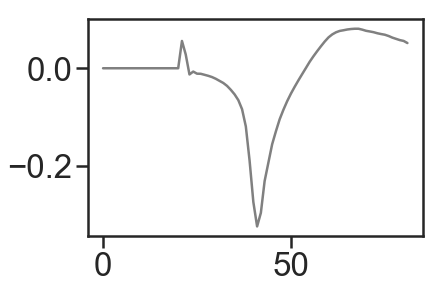

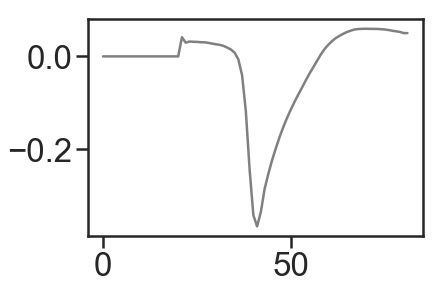

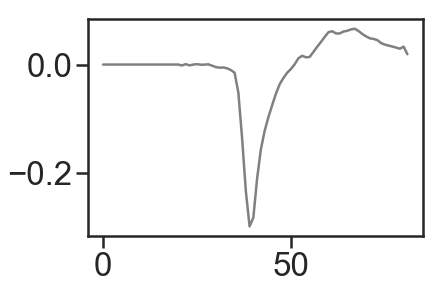

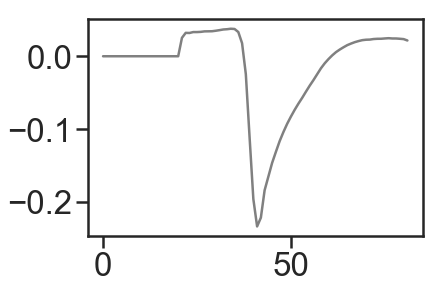

In [1472]:
for unit in df_tmt.cluster_id.unique():
    df_tmt[df_tmt.cluster_id == unit].tmt.plot()
    plt.show()

In [249]:
print d_psth[paradigm].shape
print d_psth[paradigm].stim1.unique()
print d_psth[paradigm].cluster_id.unique().size

(138900, 13)
['0.0625' '0.125' '0.25' '0.5' '1.0']
285


In [256]:
df_sert = 0
df_sert = pd.concat(d_psth.values()).reset_index(drop = True)

In [257]:
df_sert['group'] =  df_sert.et.map(groups)
print df_sert['group'].unique()

['wt']


In [1217]:
df_sert[df_sert.group == 'het'].groupby(['group', 'et', 'training']).path.unique().values

array([array(['U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Males\\set2\\006-left2\\conc'],
      dtype=object),
       array(['U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Males\\set2\\007-left2\\conc'],
      dtype=object),
       array(['U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Males\\set2\\007-right1\\conc'],
      dtype=object),
       array(['U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Males\\set2\\008-left2\\conc'],
      dtype=object),
       array(['U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Males\\set2\\008-right1\\conc'],
      dtype=object),
       array(['U:\\Data\\pak6\\OpenEphys\\probe_64DA\\SERT KO\\stim1 training\\Females\\set1\\377 post\\conc'],
      dtype=object),
       array(['U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Fenales\\set3\\931 post\\conc'],
      dtype=object),
       array(['U:\\Data\\pak6\\OpenE

In [258]:
conditions = [
    (df_sert['depth'] <= 600) & (df_sert['depth'] >= 400),
    (df_sert['depth'] < 400) ,
    (df_sert['depth'] > 600)]
choices = ['l4', 'l5/6', 'l2/3']
df_sert['layer'] = np.select(conditions, choices)

In [5]:
path = r"U:\Data_Analysis\pak6\Analysis of units\sert_psth_master.pkl"
df_sert = pd.read_pickle(path)

0.0027333333333333333

In [8]:
def compute_ztc(data):
    if 'G' in data.paradigm.unique()[0]:
        base_fr = data[(data.times > 0) & (data.times < 0.5)].Hz.values
    else:
        base_fr = data[(data.times > 0) & (data.times < 0.3)].Hz.values
    mean = np.mean(base_fr)
    std = np.std(base_fr)
    if mean == 0:
        std=1
    ztc = (data.Hz.values - mean)/std
    data['ztc'] = ztc
    return data

In [9]:
def get_vis_resp(data):    
    tmp = data[data.stim1 == 'G-1']
    base_fr = tmp[(tmp.times > 0.05) & (tmp.times < 0.35)].Hz.values
    dev_fr = tmp[(tmp.times > 0.55) & (tmp.times < 0.85) ].Hz.values
    exc_inh = np.mean(dev_fr) - np.mean(base_fr)
    p_resp = sstat.wilcoxon(dev_fr, base_fr)
    if p_resp[1] < 0.05:
        if exc_inh > 0:
            data['resp_sig'] = 'exc'
        else:
            data['resp_sig'] = 'inh'
    else:
        data['resp_sig'] = 'ns'
    return data

In [10]:
df_sert = df_sert.groupby(('cluster_id', 'paradigm' ,'stim1')).apply(compute_ztc)

In [122]:
df_sert = df_sert.groupby(('cluster_id', 'paradigm' ,'stim1')).apply(_duration_peaks)

KeyboardInterrupt: 

In [1518]:
df_sert['n_type'] = df_sert.cluster_id.map(neuron_type)

[Text(68,0.5,u'416'), Text(0.5,21.5,u'')]

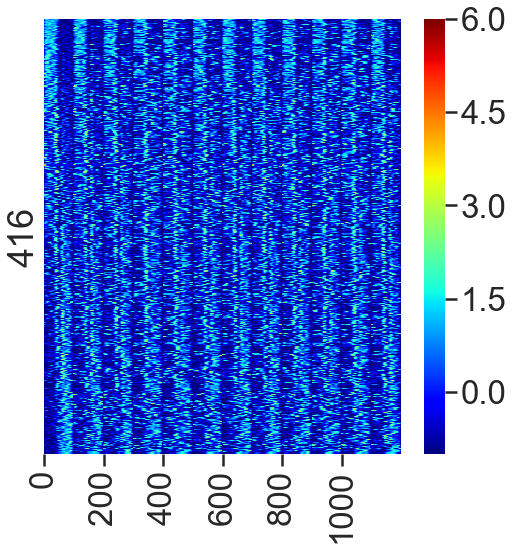

In [1545]:
# %matplotlib notebook
f, ax = plt.subplots(figsize = (8, 8), facecolor = 'w')
idx = 13

_data = df_sert

data = _data[(_data.paradigm == '12-drifting' )
              & (_data.training == 'post') 
#                 & (_data.group == 'ko') 
#              & (_data.n_type == 'fs') 
#                 & (_data.resp_sig == 'exc')
               ]  
high_ztc_units = data[data.ztc > 400].cluster_id.unique()
data = data[~data.cluster_id.isin(high_ztc_units)]


# data = data[(data.et != '378') & (data.et != '377')]

# data = data.dropna()
# data = data[ (data.times >= 0.05) & (data.times < 2.5)]

hm = data.pivot('cluster_id', 'abs_times', 'zscore')
hm = hm.dropna()
good_units = hm.index.values
hm2 = hm.values[ np.argsort(np.mean(hm.values[:,50:100], axis = 1) )]

sns.heatmap(hm2, cmap = 'jet',  annot=False, xticklabels = 200, vmax = 6,
            vmin = -1, robust = True, yticklabels=False, ax = ax, cbar = True )
ax.set(xlabel='', ylabel= hm.shape[0])
# plt.savefig('hm-sert_het_units-g1-pre.png')

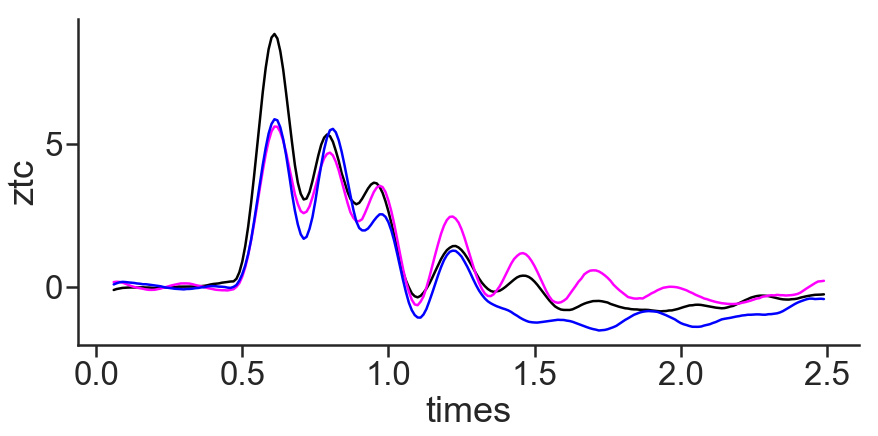

In [1521]:
zsc = 'ztc'

fig, ax = plt.subplots(figsize= (14,6))
# data = _data[ (_data.paradigm == 'sf_tuning') & (_data.cluster_id.isin(good_units)) ]
# data = _data[ (_data.paradigm.str.contains('odd')) | (_data.stim1.str.contains('ctr2'))]
data = data[ data.cluster_id.isin(good_units)]

# data = data[data.side.str.contains('left')]
fig_inp = data[(data.times > 0.05) & (data.times < 2.5)]
# target_units = df_odd[df_odd.resp_sig == 'inh'].cluster_id.unique()

fig_inp = fig_inp.sort_values(by = ['group',], ascending=False)

# f, ax = plt.subplots(figsize = (12, 8), facecolor = 'w

sns.lineplot(data=fig_inp, x = 'times', y = zsc, ci = None,
              legend = False, hue = 'group', 
             palette = ['k', 'magenta', 'blue'],
      estimator=np.nanmean)
sns.despine()

# for i in range(5):
#     plt.axvspan(0.35 +i, 0.8+i, alpha=0.2, color='gray')
    
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.axvspan(0.5, 0.9, color='gray', alpha = 0.2)
# plt.savefig('line-sert-contrast-post.pdf')

In [260]:
df_sert.loc[((df_sert.paradigm.str.contains('G')) ), 'times'] = df_sert.loc[((df_sert.paradigm.str.contains('G'))), 'times'] - 0.50
df_sert = df_sert.round({'times': 3})

In [255]:

for i,v in enumerate((sorted(df_sert[ (df_sert.et.str.startswith('S'))].et.unique()))[:]):
    print v
    df_sert.loc[((df_sert.et == v) & (df_sert.training == 'post')), 'times'] = df_sert.loc[((df_sert.et == v) & (df_sert.training == 'post')), 'times'] - 0.50
df_sert = df_sert.round({'times': 3})

S-WT1
S-WT2
S-WT3
S-WT4


In [68]:
colors_training = ['gray', 'crimson']
colors_group = [ 'k', 'blue', 'magenta']

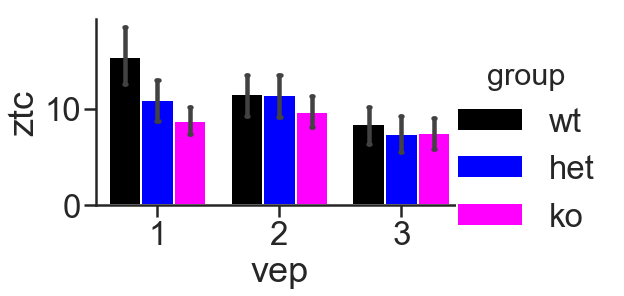

In [993]:
# _data = mmn_exp[mmn_exp.paradigm =='paired-oddball']
_data = data

vep1 = _data[(_data.times>0.53) & (_data.times<0.63)]
vep1 = vep1.groupby([ 'group' ,'cluster_id']).ztc.mean().reset_index()

vep1.loc[:, 'vep'] = 1

vep2 = _data[(_data.times > 0.73) & (_data.times < 0.83)]
vep2 = vep2.groupby([ 'group' ,'cluster_id']).ztc.mean().reset_index()

vep2.loc[:, 'vep'] = 2

vep3 = _data[(_data.times > 0.93) & (_data.times < 1.03)]
vep3 = vep3.groupby([ 'group' ,'cluster_id']).ztc.mean().reset_index()

vep3.loc[:, 'vep'] = 3

out = pd.concat([vep1, vep2, vep3])
# __data = band_df
g = sns.factorplot(x = "vep", y= "ztc", hue ='group',  data=out,  kind = 'bar', ci = 68, 
                   palette = colors_group, hue_order = ['wt', 'het', 'ko'],
                   capsize = 0.02, saturation = 1,
                   size = 5, aspect=1.5 )

# plt.savefig('bar-sert-g1-pre.pdf', transparent=True)

In [978]:
vep2.shape

(416, 4)

In [987]:
cond = 'vep'
val = 'ztc'
_inp = out
for l in sorted(_inp[cond].unique()):
    stat_inp = _inp[_inp[cond] == l]
    stat_inp = stat_inp.groupby(['group', 'cluster_id']).mean().reset_index()
    
    x1 = stat_inp[(stat_inp.group == 'wt')   ][val].dropna().values
    x2 = stat_inp[(stat_inp.group == 'het')   ][val].dropna().values
    x3 = stat_inp[(stat_inp.group == 'ko')   ][val].dropna().values

    print '\t', l
    print 'wt mean sem', np.mean(x1), sstat.sem(x1)
    print 'het mean sem', np.mean(x2), sstat.sem(x2)
    print 'ko mean sem', np.mean(x3), sstat.sem(x3)
    print len(x1), len(x2), len(x3)
    
    print sstat.kruskal(x1, x2, x3)
    print sstat.mannwhitneyu(x1, x2)
    print sstat.mannwhitneyu(x1, x3)
    print sstat.mannwhitneyu(x2, x3)
    print '------------------------'

	1
wt mean sem 15.368487875092294 2.8966062456515114
het mean sem 10.845751481704966 2.0841119869209064
ko mean sem 8.745696846717356 1.3938372782388464
110 96 93
KruskalResult(statistic=4.7922966666249955, pvalue=0.0910680423885087)
MannwhitneyuResult(statistic=4752.0, pvalue=0.10823961470164034)
MannwhitneyuResult(statistic=4196.5, pvalue=0.013856600231824572)
MannwhitneyuResult(statistic=4150.5, pvalue=0.20255623366362263)
------------------------
	2
wt mean sem 11.481000162650703 2.151243269342271
het mean sem 11.40422382377587 2.2640770147928606
ko mean sem 9.684867381855577 1.6248461876191818
110 96 93
KruskalResult(statistic=0.9680648459612784, pvalue=0.6162932195252224)
MannwhitneyuResult(statistic=5263.0, pvalue=0.4845808679541401)
MannwhitneyuResult(statistic=4814.0, pvalue=0.23558366586957147)
MannwhitneyuResult(statistic=4089.5, pvalue=0.15993195508202335)
------------------------
	3
wt mean sem 8.36001183981176 1.999141406636376
het mean sem 7.369397483469328 1.84628476103

In [1106]:
df_sert.loc[((df_sert.et == '380') & (df_sert.training == 'pre')), 'times'] = df_sert.loc[((df_sert.et == '380') 
                                               & (df_sert.training == 'pre')), 'times'] - 0.50
df_sert = df_sert.round({'times': 3})

In [714]:
from detect_peaks import detect_peaks
def _duration_peaks(df):
    ls = []
    thres = np.std(df[(df.times > 0) & (df.times < 0.3)])
    data = df[(df.times > 0) & (df.times < 1)].zscore
    peakind = detect_peaks(data, mph=1.5, mpd=10)
    if peakind.size>0:
        if peakind.size>1:#what if I change this to >2? to make it so in pre, if only one peak is detected then unit not considered oscillatory
            if peakind[0] > 30 and peakind[0] < 60:
            #if peakind[0]>50 and peakind[0]<70: #to be considered, first peak of unit must be found within the cycle 1 period
                mask = np.array(np.diff(peakind)<50)
                for ind, val in enumerate(mask):
                    if val == False:
                        mask[ind:] = False
                mask = np.insert(mask, 0, True)
                peakind = peakind[mask]
                dur = (peakind[-1]/100.0)- 0.3
            else:   
                dur = np.nan
        elif peakind[0] > 30 and peakind[0] < 60:
        #elif peakind[0]>50 and peakind[0]<70: #to be considered, first peak of unit must be found within the cycle 1 period  
            dur = (peakind[0]/100.0)- 0.3
        else:
            dur = np.nan
        if dur<0 or dur>1:
            dur = np.nan
    else:
            dur = np.nan
    df['dur'] = dur
    return df

In [1207]:
_data = df_sert

data = _data[(_data.paradigm == '12-drifting' )
              & (_data.training == 'post') 
#                 & (_data.group == 'ko') 
#                 & (_data.resp_sig == 'exc')
               ]  
data = data.groupby(['group', 'cluster_id', 'stim1']).apply(_duration_peaks)

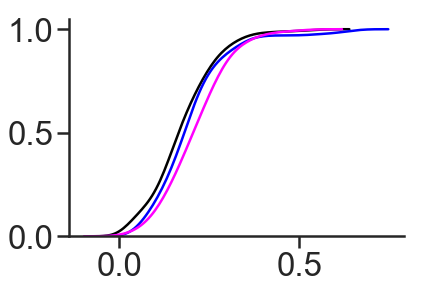

In [1208]:
tmp = data.groupby(['group','cluster_id']).mean().reset_index()

x = tmp[tmp.group == 'wt'].dur.dropna().values
x2 = tmp[tmp.group == 'het'].dur.dropna().values
x3 = tmp[tmp.group == 'ko'].dur.dropna().values

sns.kdeplot(x, cumulative=True,  color = colors_group[0])
sns.kdeplot(x2, cumulative=True,  color = colors_group[1])
sns.kdeplot(x3, cumulative=True,  color = colors_group[2])
sns.despine()
# plt.savefig('cdf-dur_sert-contrast-bystims-post.pdf', transparent=True)

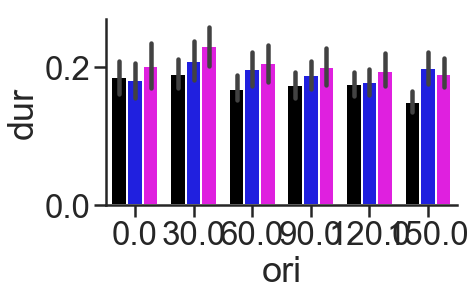

In [1131]:
tmp = data.groupby(['group','cluster_id', 'stim1' ]).mean().reset_index()
tmp['ori'] = tmp.stim1.astype('float')*30%180
sns.factorplot(x = 'ori', y = 'dur', hue = 'group', kind = 'bar' , data = tmp,
              size = 5, aspect = 1.5, hue_order = ['wt', 'het', 'ko'], legend = False,
               palette = colors_group)
# plt.savefig('bar-dur_sert-ori-post-bystim.pdf', transparent=True)

In [1211]:
x

array([0.28      , 0.24333333, 0.36666667, 0.04      , 0.14      ,
       0.03      , 0.03      , 0.02      , 0.20833333, 0.105     ,
       0.09416667, 0.266     , 0.17875   , 0.095     , 0.18142857,
       0.17      , 0.16      , 0.1975    , 0.18444444, 0.15      ,
       0.11888889, 0.155     , 0.0675    , 0.03      , 0.25666667,
       0.01      , 0.125     , 0.15181818, 0.28833333, 0.10666667,
       0.12333333, 0.2075    , 0.17583333, 0.13583333, 0.184     ,
       0.08333333, 0.13571429, 0.17166667, 0.1       , 0.11      ,
       0.118     , 0.272     , 0.225     , 0.225     , 0.17      ,
       0.02      , 0.135     , 0.07      , 0.06      , 0.21      ,
       0.23333333, 0.01      , 0.25      , 0.11      , 0.21      ,
       0.28      , 0.22428571, 0.32888889, 0.05      , 0.01      ,
       0.26333333, 0.368     , 0.31      , 0.21      , 0.23857143,
       0.08333333, 0.272     , 0.20083333, 0.15083333, 0.275     ,
       0.12714286, 0.13666667, 0.15333333, 0.228     , 0.17   

In [1210]:
print np.mean(x), sstat.sem(x)
print np.mean(x2), sstat.sem(x2)
print np.mean(x3), sstat.sem(x3)

print len(x), len(x2), len(x3)

print sstat.kruskal(x, x2, x3)
print sstat.ks_2samp(x, x2)
print sstat.ks_2samp(x, x3)
print sstat.ks_2samp(x2, x3)

0.17077323268041092 0.0065369972825855835
0.1924362091059851 0.00918152051673123
0.207208596449422 0.008483918871358027
202 134 109
KruskalResult(statistic=12.7661705475297, pvalue=0.0016899010978111853)
Ks_2sampResult(statistic=0.1317422787054825, pvalue=0.11231650472218627)
Ks_2sampResult(statistic=0.22490689435916061, pvalue=0.0012339891511121727)
Ks_2sampResult(statistic=0.17574969190743528, pvalue=0.04286602395429518)


## Direction tuning

In [58]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
def double_gaus(x, base, theta_pref, rp, rn, sigma):
    y = []
    for idx in range(x.size):
        pref = min(abs(x[idx] - theta_pref), abs(x[idx] - theta_pref+360), abs(x[idx] - theta_pref-360)) 
        null = min(abs(x[idx] - theta_pref+180), abs(x[idx] - theta_pref+180+360), abs(x[idx] - theta_pref+180-360))

        y.append( base + rp * np.exp( - (pref**2)/(2*(sigma**2))) + rn * np.exp( -(null**2)/(2*(sigma**2))  ))
        
    return np.array(y)

In [59]:
def single_gaus(x, base, theta_pref, rp, sigma):
    y = []
    for idx in range(x.size):
        pref = min(abs(x[idx] - theta_pref), abs(x[idx] - theta_pref+180), abs(x[idx] - theta_pref-180)) 
        

        y.append( base + rp * np.exp( - (pref**2)/(2*(sigma**2))) )
        
    return np.array(y)

In [60]:
def ang_diff(a1, a2):
    return 180 - abs(abs(a1 - a2) - 180)

In [61]:
def dir2ori(angle):   
    if angle>180:
        angle = angle - 180
    return angle
    

In [62]:
def compute_odsi(data):
    val = 'Hz'
    pref_dir = data.pref.iloc[0]
    null_ang_fr = data[data.dir == (pref_dir+180)%360][val].values[0]
    ort_ang = (pref_dir + 90)%360, ((pref_dir + 90)%360 + 180)%360
    pref_ang_fr = data[data.dir == pref_dir][val].values[0]
    pref_ori = (null_ang_fr + pref_ang_fr)/2.0
    ort_ang_fr = (data[data.dir == ort_ang[0]][val].values[0] + data[data.dir == ort_ang[1]][val].values[0])/2.0
    
    osi = (pref_ori - ort_ang_fr)/pref_ori 
    dsi = (pref_ang_fr - null_ang_fr)/pref_ang_fr 
    data['osi'] = osi
    data['dsi'] = dsi
    return data

In [63]:
def compute_cv_odsi(data):
    fr = data.Hz.values
    angles = np.deg2rad(data.dir.values)
    
    cv_dir = abs(np.dot(fr, np.exp(1j*angles))/np.sum(abs(fr)))
    cv_ori = abs(np.dot(fr, np.exp(2j*angles))/np.sum(abs(fr)))
    data['cv_ori'] = cv_ori
    data['cv_dir'] = cv_dir
    return data

In [142]:
fig_inp.group.unique()

array(['wt', 'ko', 'het'], dtype=object)

413


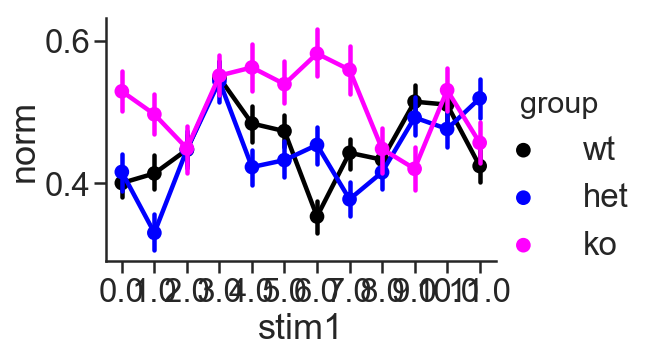

In [1546]:

data = df_sert[(df_sert.paradigm == '12-drifting') ]
# df_vmmn['n_type'] = df_vmmn.cluster_id.map(neuron_type)
data = data[data.cluster_id.isin(good_units)]

fig_inp = data[(data.times > 0.35) & (data.times < 0.8) ]
fig_inp = fig_inp.groupby([ 'group', 'training' , 'layer', 'n_type', 'cluster_id', 'stim1']).mean().reset_index()
tuning_good_units = fig_inp.pivot('cluster_id', 'stim1', 'Hz').dropna().index.values.tolist()

base = data[(data.times > 0) & (data.times < 0.3)  ].groupby(['group' , 'training', 'layer', 'n_type',
                            'cluster_id', 'stim1']).mean().reset_index().Hz.values
fig_inp.loc[:,'bc_fr'] = fig_inp['Hz'] - base

# fig_inp = fig_inp[fig_inp.cluster_id.isin(tuning_good_units)]

fig_inp['norm'] = fig_inp.groupby('cluster_id')['bc_fr'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
fig_inp['stim1'] = fig_inp.stim1.astype('float')

fig_inp = fig_inp.sort_values(by = ['stim1', 'training', 'group'], ascending= [True, False, False])
print fig_inp.cluster_id.unique().size
ax = sns.catplot(x="stim1", y = "norm", data = fig_inp,  kind = 'point', ci = 68, hue= 'group',
                    palette = colors_group, hue_order = ['wt', 'het', 'ko'],
#                  col = 'group', col_wrap = 1,
#                    capsize = 0.02, saturation = 1,
                   height = 5, aspect=1.5 )
# plt.savefig('bar-contrast-tuning-pre-35-08.pdf')

In [28]:
fig_inp.times.unique()

array([0.57])

In [1547]:
dir_df = fig_inp.sort_values('Hz', ascending=False).groupby('cluster_id', as_index=False).first()
pref_d = dict(zip(dir_df.cluster_id, dir_df.stim1*30))

fig_inp['pref'] = fig_inp.cluster_id.map(pref_d)
fig_inp['dir'] = fig_inp.stim1*30
fig_inp['ori'] = fig_inp['dir']%180
fig_inp['pref_ori'] = fig_inp['pref']%180
fig_inp = fig_inp.groupby('cluster_id').apply(compute_odsi)
fig_inp = fig_inp.groupby('cluster_id').apply(compute_cv_odsi)

In [1526]:
fig_inp.head()

group training layer n_type      cluster_id  stim1     index        Hz  \
2820    wt     post     0     rs  273etS-WT1post    0.0  559857.5  5.800754   
2832    wt     post     0     rs  274etS-WT1post    0.0  558357.5  1.407884   
2844    wt     post     0     rs  276etS-WT1post    0.0  560557.5  0.153627   
2856    wt     post     0     rs  283etS-WT3post    0.0  550257.5  2.802271   
2868    wt     post     0     rs  284etS-WT3post    0.0  550157.5  0.420528   

      abs_times  depth    ...        bc_fr      norm   pref  dir  ori  \
2820      0.575    NaN    ...     3.145942  0.696852  150.0  0.0  0.0   
2832      0.575    NaN    ...    -2.483177  0.056744  240.0  0.0  0.0   
2844      0.575    NaN    ...    -0.079462  0.118772  300.0  0.0  0.0   
2856      0.575    NaN    ...     1.527980  1.000000    0.0  0.0  0.0   
2868      0.575    NaN    ...    -1.305303  0.488708  120.0  0.0  0.0   

      pref_ori       osi       dsi    cv_ori    cv_dir  
2820     150.0  0.692062  0.617123  0.328509  0.167617  
2832      60.0  0.105471  0.727972  0.105438  0.203353  
2844     120.0  0.757222  0.145152  0.443577  0.124872  
2856       0.0  0.816163  0.224992  0.299397  0.104894  
2868     120.0  0.514655  0.578912  0.093184  0.110140  

[5 rows x 23 columns]

In [858]:
sf_df = fig_inp.sort_values('norm', ascending=False).groupby('cluster_id', as_index=False).first()
# sf_list = sf_df.stim1.str.split('r', expand = True)[1].values.astype('int')
pref_d = dict(zip(sf_df.cluster_id, sf_df.stim1))

# sf_df = fig_inp[fig_inp.opto == 1].sort_values('ztc', ascending=False).groupby('cluster_id', as_index=False).first()
# pref_opto_d = dict(zip(sf_df.cluster_id, sf_df.stim1))

fig_inp['pref'] = fig_inp.cluster_id.map(pref_d)

In [72]:
import cmath

0.22262130998800356 0.18230512589162184


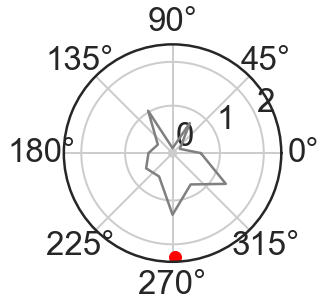

0.09575566647135696 0.06951425045268274


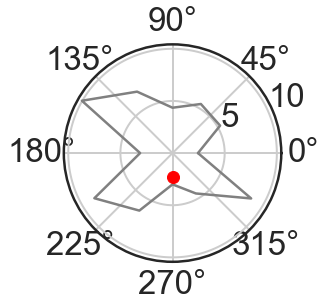

0.03713013714874093 0.40018242855969266


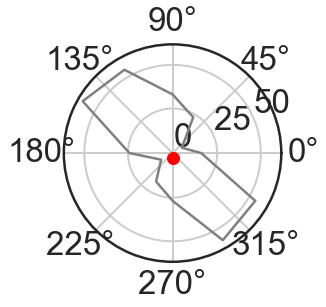

0.07244019043140658 0.03606198275956733


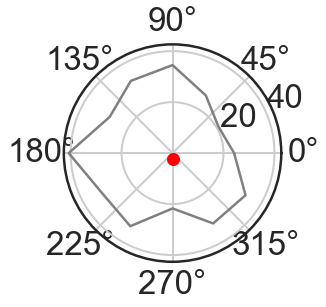

0.03185388540748846 0.567209259291785


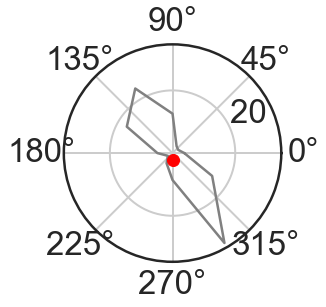

0.08870084187835593 0.15394280707548388


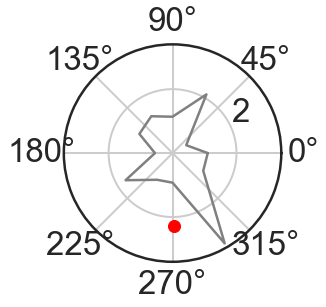

0.029997968693693703 0.06350854138205175


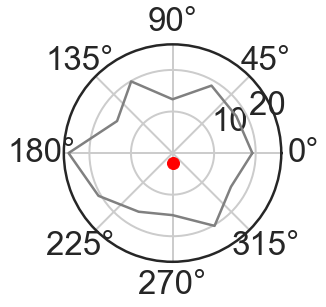

0.056092652525827076 0.07616709326691416


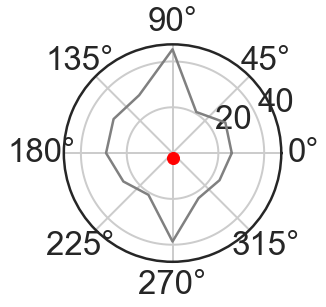

0.4413106617200547 0.22172302102285138


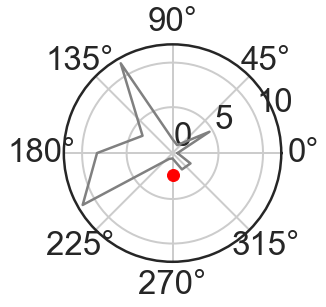

0.0032410835792076147 0.00804013220013754


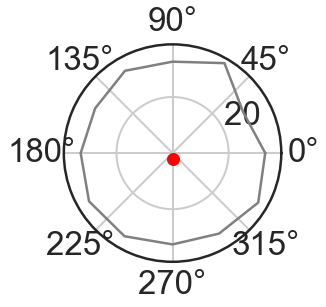

0.0682218012441785 0.0782593006106857


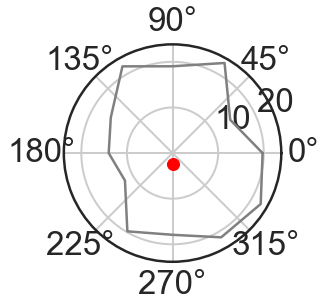

0.10128292995216659 0.143459095798503


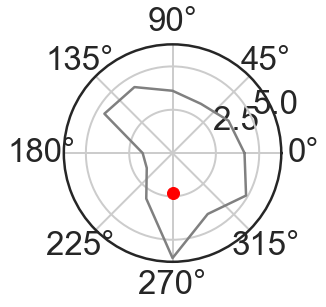

0.009136649771983132 0.2047378333851446


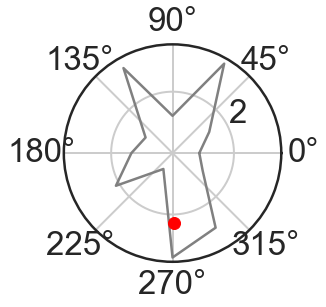

0.12869025503223097 0.06092707879379898


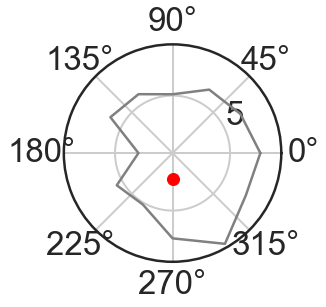

0.08559652472703493 0.05893082192466359


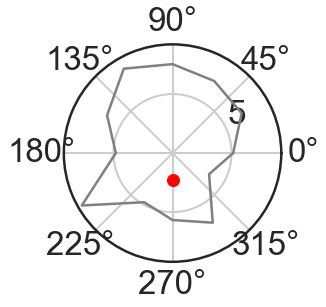

0.027973673170467967 0.01768573293040196


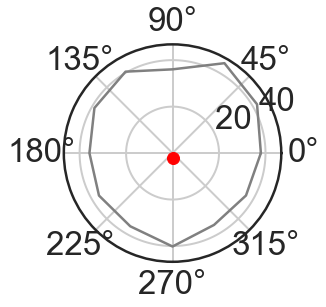

0.06270855032623995 0.22113496711129788


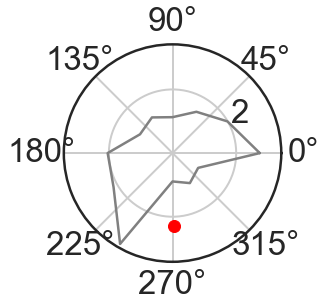

0.4078362666541463 0.5018774395403245


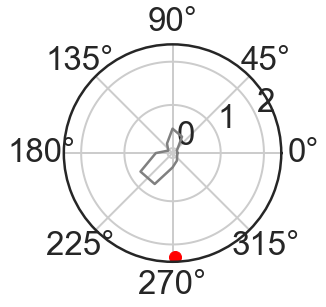

0.2837795536588305 0.17003209392588864


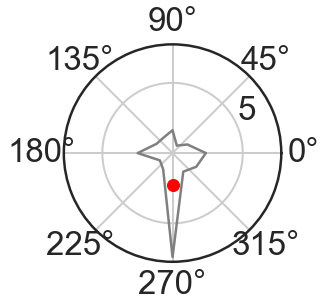

0.13671672628548698 0.1661175652223685


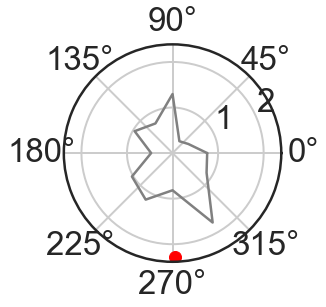

0.2823777845295498 0.45569746044465365


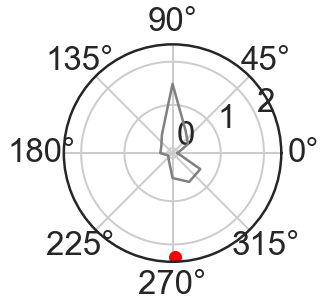

0.030467803122920575 0.15664868018933806


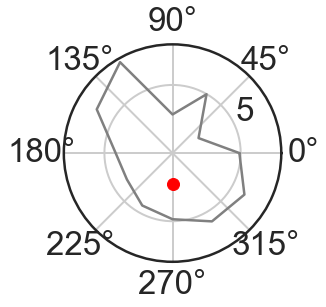

0.0634169892714177 0.09458611329017658


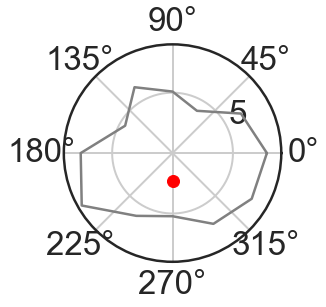

0.05868494384459587 0.1614756958241423


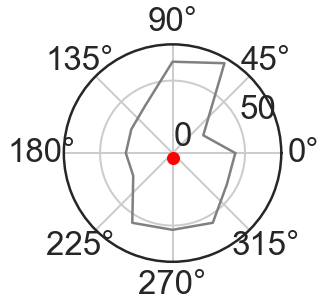

0.3168787902273292 0.15489598213277592


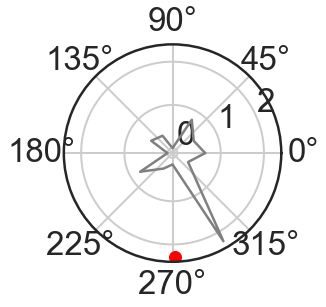

0.2095698828072372 0.36918546180222506


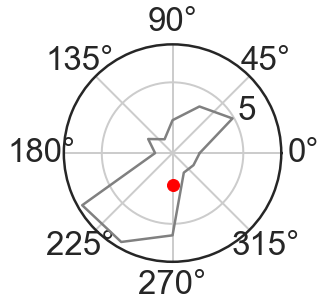

0.2962245928200017 0.5404613315792756


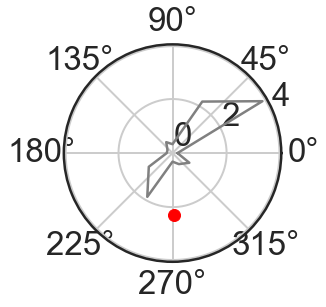

0.034648929508321574 0.04158236365648289


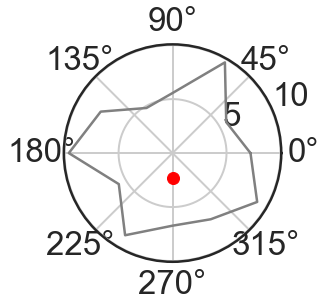

0.16394236421048264 0.4083226435113665


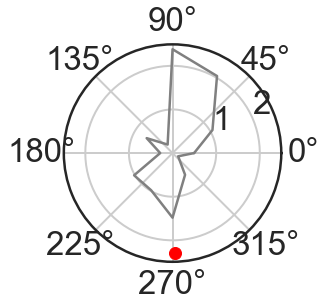

0.11479460377089411 0.17803149636437582


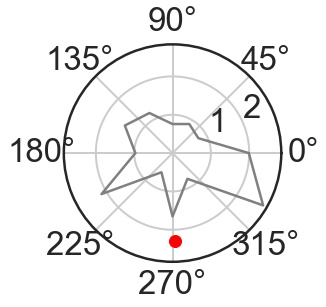

0.09854100802221305 0.2729160091104111


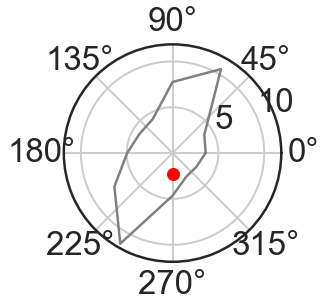

0.051056874865069414 0.3936200386232519


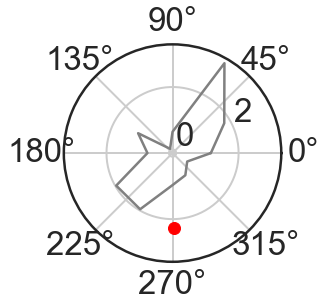

0.0481997376414064 0.07181550755445641


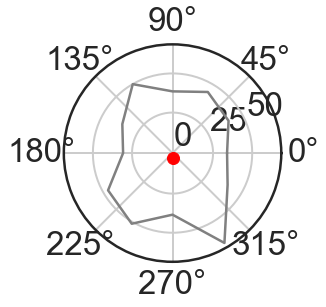

0.10909952131117841 0.38650143021313643


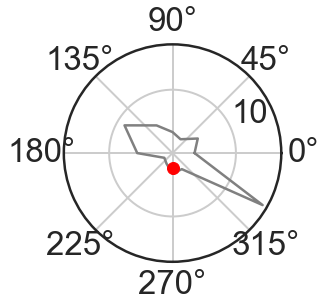

0.12275207049954295 0.47263969798782823


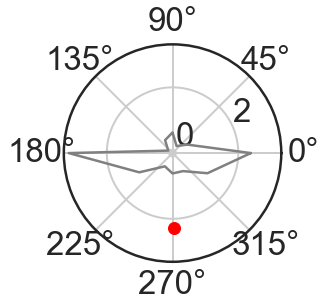

In [92]:
for unit in fig_inp.cluster_id.unique()[15:50]:
    data = fig_inp[fig_inp.cluster_id == unit]
    ax = plt.subplot(111, projection='polar')
    angles = data.dir.values
    fr = data.Hz.values
#     a = np.deg2rad(angles) 
    a = np.deg2rad(angles)
    cv_dir = abs(np.dot(fr, np.exp(1j*a))/np.sum(abs(fr)))
    
    cv_ori = abs(np.dot(fr, np.exp(2j*a))/np.sum(abs(fr)))


#     cir_mean = cmath.polar(r)

    print cv_dir, cv_ori
    
#     ax.set_theta_zero_location("N")
#     ax.set_theta_direction(-1)
    fr = np.append(fr, fr[0])
    a = np.append(a, a[0])
    ax.plot(a, fr)
    ax.plot(mean[1], mean[0], 'ro')
    plt.show()

In [771]:
angles = angles/360*2*pi;
r = (rates * exp(i*angles)') / sum(abs(rates));
cv = 1-abs(r);

((0.5376037972624026, 0.6349968867659544),
 (0.4328105938836856+0.3188931367292276j))

In [207]:
fig_inp.head()

group training layer      cluster_id  stim1   level_0     index  \
1404    wt     post     0  273etS-WT1post      0  559857.5  559857.5   
1416    wt     post     0  274etS-WT1post      0  558357.5  558357.5   
1428    wt     post     0  284etS-WT3post      0  550157.5  550157.5   
1440    wt     post  l2/3  135etS-WT4post      0  552257.5  552257.5   
1452    wt     post  l2/3  140etS-WT4post      0  553057.5  553057.5   

             Hz  abs_times  depth  times    zscore       ztc   dur     bc_fr  \
1404   5.800754      0.575    NaN  0.575  0.700188  1.753192  0.11  3.145942   
1416   1.407884      0.575    NaN  0.575 -0.591805 -1.374652   NaN -2.483177   
1428   0.420528      0.575    NaN  0.575 -0.436281 -1.848568   NaN -1.305303   
1440  11.095210      0.575  650.0  0.575  0.626522  3.593815   NaN  3.687482   
1452   6.436498      0.575  750.0  0.575  0.592738  6.436498   NaN  6.436498   

          norm  
1404  0.696852  
1416  0.056744  
1428  0.488708  
1440  0.242358  
1452  0.546902

In [208]:
data = data.groupby()

level_0   index        Hz  abs_times      cluster_id  \
546600   546600  546600  0.562015       0.00  247etS-WT3post   
546601   546601  546601  0.539978       0.01  247etS-WT3post   
546602   546602  546602  0.498463       0.02  247etS-WT3post   
546603   546603  546603  0.442097       0.03  247etS-WT3post   
546604   546604  546604  0.376730       0.04  247etS-WT3post   

                                         cuid  depth     et group layer  \
546600  247etS-WT3postetS-WT3012-driftingpost  150.0  S-WT3    wt  l5/6   
546601  247etS-WT3postetS-WT3012-driftingpost  150.0  S-WT3    wt  l5/6   
546602  247etS-WT3postetS-WT3012-driftingpost  150.0  S-WT3    wt  l5/6   
546603  247etS-WT3postetS-WT3012-driftingpost  150.0  S-WT3    wt  l5/6   
546604  247etS-WT3postetS-WT3012-driftingpost  150.0  S-WT3    wt  l5/6   

           paradigm                                               path sex  \
546600  12-drifting  U:\Data\pak6\OpenEphys\probe_64DA\SERT KO\stim...   M   
546601  12-drifting  U:\Data\pak6\OpenEphys\probe_64DA\SERT KO\stim...   M   
546602  12-drifting  U:\Data\pak6\OpenEphys\probe_64DA\SERT KO\stim...   M   
546603  12-drifting  U:\Data\pak6\OpenEphys\probe_64DA\SERT KO\stim...   M   
546604  12-drifting  U:\Data\pak6\OpenEphys\probe_64DA\SERT KO\stim...   M   

       stim1  times training    zscore resp_sig       ztc   dur  
546600     0   0.00     post  0.032555      exc  1.591363  0.44  
546601     0   0.01     post -0.009770      exc  1.484747  0.44  
546602     0   0.02     post -0.089508      exc  1.283893  0.44  
546603     0   0.03     post -0.197769      exc  1.011192  0.44  
546604     0   0.04     post -0.323317      exc  0.694945  0.44

In [51]:
fr

array([2.40204778, 0.4361476 , 0.1502126 , 0.55337797, 0.37065201,
       0.05061755, 3.21982634, 1.12546798, 0.38300642, 0.54520936,
       0.55999306, 1.18448529])

In [64]:
np.dot(fr, angles_complex)

(5.189713949972353-0.0614127299194237j)

### Fit a double Gaus to 12 directions

In [1548]:
# fit double gaus to the firing rate of individual units
sigma = [15, 30, 40, 60, 90]
tot_error = []
fit_err = {}
pref_ori = {}
ori_tuning_w = {}
dir_tuning_w = {}
pref_ang = {}
xnew = np.arange(0, 340, 15)

tmp = fig_inp[(fig_inp.group != 'o') 
#             & (fig_inp.training == 'post')
#             & (fig_inp.fit_err < 0.5) 
             ]

for unit in tmp.cluster_id.unique()[:]:
    
    data = fig_inp[fig_inp.cluster_id == unit]
    m = data.Hz.max()
    fr = data.Hz.values
    theta_pref = data.pref.iloc[0]
    angles = np.deg2rad(data.dir.values)
    si_ori = np.sqrt(np.dot(fr, np.sin(angles*2))**2 + 
                          np.dot(fr, np.cos(angles*2))**2)/np.sum(fr)
    si_dir = np.sqrt(np.dot(fr, np.sin(angles))**2 + 
                          np.dot(fr, np.cos(angles))**2)/np.sum(fr)
    
    cv_dir = abs(np.dot(fr, np.exp(1j*angles))/np.sum(abs(fr)))
    cv_ori = abs(np.dot(fr, np.exp(2j*angles))/np.sum(abs(fr)))
    
    rp = data[data['dir']== theta_pref].Hz.values[0]
    rn =  data[data['dir']==ang_diff(theta_pref, 180)].Hz.values[0]
   
    x = data.dir.unique()
    
    y = data.Hz.values
#     y_std = data['fr_std'].values +0.001
    
   
    init_params = [0, theta_pref, m, sigma[2] ]
    try:
        # fir single gaus for orientatio, double for direction tuning
#         bound_params = ([0, 0, 0,15], [m, 361, m*3, 180])
#         popt, pcov = curve_fit(single_gaus, x, y, bounds = bound_params , p0 = init_params, sigma = y_std, absolute_sigma=True)

        init_params_double = [0, theta_pref, m, m, sigma[2] ]
        bound_params_double = ([0, 0, 0, 0,15], [m, 361, m*3, m*3, 180])
        popt_double, pcov_double = curve_fit(double_gaus, x, y, bounds = bound_params_double , p0 = init_params_double)
        perr_double = np.sqrt(np.diag(pcov_double))

        fit_double = double_gaus(x, *popt_double)
        fit_error_double = sum((y-fit_double)**2)  /  sum((y-y.mean())**2)
        perr = np.sqrt(np.diag(pcov_double))
    except:
        print('error')
        continue


    fit_err[unit] = fit_error_double
    pref_ang[unit] = popt_double[1]
#     pref_ori[unit] = ang_2ori(popt_double[1])
    
    dir_tuning_w[unit] = round(popt_double[-1], 2)
    #dir_tuning_w[n] = popt_double[-1]
    #print ang_2ori(popt[1]), popt[-1]
#     if fit_error>0.7:


#     print 'error ', fit_error_double, 'pref ' , popt_double[1]
# #     print 'dsi ', data.dsi.values[0], 'osi ', data.osi.values[0]
#     print 'osi', round(cv_ori, 3)
# #     print 'si', round(si_dir, 3), round(si_ori, 3)
#     print 'tuning_w', round(popt_double[-1], 2)
#     f, ax = plt.subplots()
#     sns.despine(ax = ax)
#     f2 = interp1d(x, fit_double, kind = 'quadratic')
#     ax.plot(x, y, 'mo-')
#     ax.plot(xnew, f2(xnew), 'r')
# #     ax.xaxis.set_major_locator(plt.MaxNLocator(6))
#     plt.show()

#         continue
    


# print np.sum(tot_error)
fig_inp['fit_err'] = fig_inp.cluster_id.map(fit_err)
fig_inp['tuning_w'] = fig_inp.cluster_id.map(dir_tuning_w)

# fig_inp['pref_ang'] = fig_inp.cluster_id.map(pref_ang)
# df_ori0['pref_ori'] = df_ori0.cuid.map(pref_ori)
# plt.savefig( str(unit) + 'ko.pdf')

error


In [809]:
ls = []
tmp = fig_inp[(fig_inp.group == 'ko') 
            & (fig_inp.training == 'post')
#             & (fig_inp.fit_err < 0.5) 
             ]
for unit in tmp.cluster_id.unique()[:]:
    data = tmp[tmp.cluster_id == unit]
#     ax = plt.subplot(111, projection='polar')
    fr = data.Hz.values
    pref_dir = data.pref.iloc[0]
    angles = data.dir.values
    angles = (angles - pref_dir + 360)%360
    idx = np.argsort(angles)
    ls.append(fr[idx]) 
    a = np.deg2rad(angles) 
#     print pref_dir
#     ax.set_theta_zero_location("N")
#     ax.set_theta_direction(-1)
#     fr = np.append(fr, fr[0])
#     a = np.append(a, a[0])
#     ax.plot(a, fr, 'gray')
#     plt.show()
print len(ls)

97


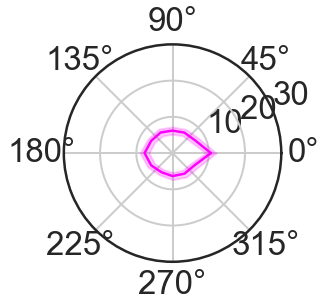

In [811]:
fr = np.mean(ls, axis = 0)
std = sstat.sem(ls, axis = 0)

angles = np.arange(0, 350, 30)
a = np.deg2rad(angles)
a = np.append(a, a[0])
fr = np.append(fr, fr[0])
std = np.append(std, std[0])
std1 = fr - std
std2 = fr + std
ax = plt.subplot(111, projection='polar')

ax.plot(a, fr, 'magenta')
ax.fill_between(a, std1, std2, alpha=0.2, color = 'magenta')
ax.set_ylim(0, 30)
# plt.savefig( 'polar_sert_ko_12-dir-post.pdf')

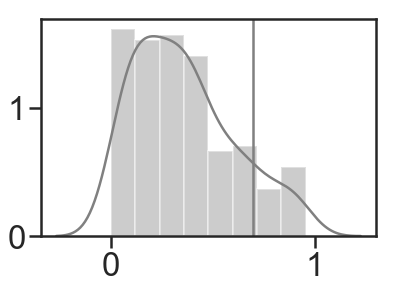

In [111]:
sns.distplot(fig_inp.groupby('cluster_id').mean().fit_err.values)
plt.axvline(x = 0.7)

In [1549]:
fig_inp[fig_inp.stim1 == 0].groupby(['group', 'n_type']).cluster_id.count()

group  n_type
het    fs         15
       rs        111
       un         13
ko     fs          9
       rs         76
       un         11
wt     fs         10
       rs        143
       un         25
Name: cluster_id, dtype: int64

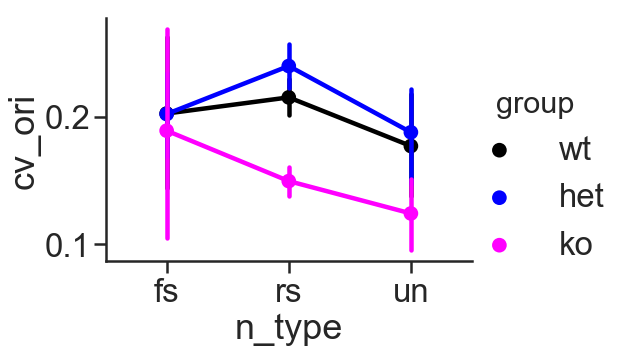

In [1551]:
tmp = fig_inp[(fig_inp.fit_err < 1) & (fig_inp.depth > -1 )].groupby(['group', 'training' ,
                                                    'layer' , 'n_type' ,'cluster_id']).mean().reset_index()
tmp = tmp.sort_values(by = ['training', 'group'], ascending= [False, False])

ax = sns.catplot(x = "n_type", y = "cv_ori", hue = 'group' , data = tmp,  kind = 'point', ci = 68, 
                  palette = colors_group, hue_order = ['wt', 'het', 'ko'],
#                  col = 'layer', col_wrap = 1,
                    height = 5, aspect = 1.5
                    )
# plt.savefig( 'bar_12dir_sigma_pre.pdf')

In [1199]:
val = 'cv_ori'
x = tmp[tmp.group == 'wt'][val].dropna().values
x2 = tmp[tmp.group == 'het'][val].dropna().values
x3 = tmp[tmp.group == 'ko'][val].dropna().values

print np.mean(x), sstat.sem(x)
print np.mean(x2), sstat.sem(x2)
print np.mean(x3), sstat.sem(x3)

print len(x), len(x2), len(x3)
print sstat.kruskal(x, x2, x3)
print sstat.mannwhitneyu(x, x2)
print sstat.mannwhitneyu(x, x3)
print sstat.mannwhitneyu(x2, x3)

0.21110388206711286 0.012859728361268705
0.23039689620595827 0.014381246113469436
0.15164912514237136 0.012667502962289622
172 136 96
KruskalResult(statistic=16.142817150312112, pvalue=0.00031234301245527935)
MannwhitneyuResult(statistic=10425.0, pvalue=0.050813779467036344)
MannwhitneyuResult(statistic=6562.0, pvalue=0.0026883353143165164)
MannwhitneyuResult(statistic=4542.0, pvalue=4.0157130417174695e-05)


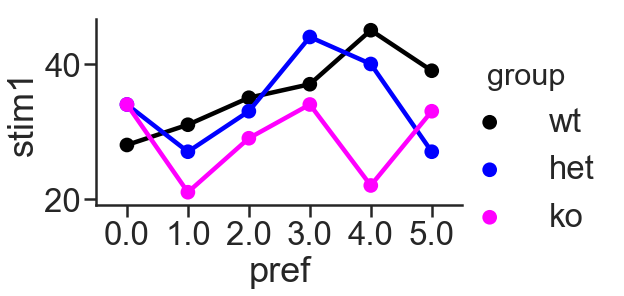

In [860]:
tmp = fig_inp.groupby(['group', 'training' ,'cluster_id']).mean().reset_index().groupby(['group',
                                                       'training', 'pref']).count().reset_index()
tmp = tmp.sort_values(by = ['group', 'training'], ascending= [False, False])

ax = sns.catplot(x = "pref", y = "stim1",   data = tmp,  kind = 'point', ci = 68, 
                  palette = colors_group, hue = 'group',  
                 hue_order = ['wt', 'het', 'ko'],
#                  col = 'group', col_wrap = 1,
                    size = 5, aspect = 1.5
                    )
# plt.savefig('bar-prefsf_count_post.pdf', transparent=True)

## Fit DOG to SF tuning curve

In [394]:
def diff_of_gaus(x, base, k_exc, mu_exc, sigma_exc, k_inh, mu_inh, sigma_inh):
    y_hat = []
    for idx in range(x.size):

        y_hat.append( base + k_exc * np.exp( - ((x[idx] - mu_exc)**2)/(2*(sigma_exc**2))) - 
                     k_inh * np.exp( -((x[idx] - mu_inh)**2)/(2*(sigma_inh**2))  ))
        
    return np.array(y_hat)

def exc_comp(x, base, k_exc, mu_exc, sigma_exc):
    y_hat = []
    for idx in range(x.size):
        y_hat.append( base + k_exc * np.exp( - ((x[idx] - mu_exc)**2)/(2*(sigma_exc**2))))
    return np.array(y_hat)
    
def inh_comp(x, base, k_inh, mu_inh, sigma_inh):
    y_hat = []
    for idx in range(x.size):
        y_hat.append( k_inh * np.exp( -((x[idx] - mu_inh)**2)/(2*(sigma_inh**2))  ))
    return np.array(y_hat)

In [418]:
def lsfs(data):
    lsf_fr = data[data.stim1 == 0].Hz
    pref_fr = data.Hz.max()
    data['lsfs'] = lsf_fr/pref_fr
    return data

In [939]:
x = np.array([0.625, 0.125, 0.25, 0.5, 1])
d_k_exc = {}
d_mu_exc = {}
d_sigma_exc = {}
d_k_inh = {}
d_mu_inh = {}
d_sigma_inh = {}
d_fit_error = {}
x = np.array([7.5e-3, 0.015, 0.03, 0.06, 0.12, 0.24])
x_new = np.arange(7.5e-3, 0.24, 0.015)
for unit in fig_inp[fig_inp.group != 't'].cluster_id.unique()[:]:
    tmp = fig_inp[fig_inp.cluster_id == unit]
#     x  = tmp.stim1.values.astype('float')
    y = tmp.Hz
    m = tmp.Hz.max()
    try:
        init_params = [1, 1, 0.01, 0.01, 0.01, 0.01, 0.01 ]
        bound_params = ([0, 0, 0, 0, 0, 0, 0], [m*2, m*2, 1, 1, m*2, 1, 1])
        popt, pcov = curve_fit(diff_of_gaus, x, y, bounds = bound_params , p0 = init_params)
        perr = np.sqrt(np.diag(pcov_double))

        fit = diff_of_gaus(x, *popt)
        fit_exc = exc_comp(x, *popt[:4] )
        fit_inh = inh_comp(x, popt[0], *popt[4:])
        fit_error = sum((y-fit)**2)  /  sum((y-y.mean())**2)
        perr = np.sqrt(np.diag(pcov))

        d_k_exc[unit] = popt[1]
        d_mu_exc[unit] = popt[2]
        d_sigma_exc[unit] = popt[3]
        d_k_inh[unit] = popt[4]
        d_mu_inh[unit] = popt[5]
        d_sigma_inh[unit] = popt[6]
        d_fit_error[unit] =  round(fit_error, 3)
        
    except:
        print unit
        continue
    

#     print 's_exc', round(popt[3], 3)
#     print 's_inh', round(popt[6], 3)
#     f, ax = plt.subplots()
#     sns.despine(ax = ax)

#     f2 = interp1d(x, fit, kind = 'quadratic')
#     f3 = interp1d(x, fit_exc, kind = 'quadratic')
#     f4 = interp1d(x, fit_inh, kind = 'quadratic')
#     ax.plot(x, y, 'ko-')
#     ax.plot(x_new, f2(x_new), 'r-')
    
#     ax.plot(x_new, f3(x_new), 'r--')
#     ax.plot(x_new, f4(x_new), 'b--')
#     plt.show()
    
fig_inp['k_exc'] = fig_inp.cluster_id.map(d_k_exc)
fig_inp['mu_exc'] = fig_inp.cluster_id.map(d_mu_exc)
fig_inp['s_exc'] = fig_inp.cluster_id.map(d_sigma_exc)
fig_inp['k_inh'] = fig_inp.cluster_id.map(d_k_inh)
fig_inp['mu_inh'] = fig_inp.cluster_id.map(d_mu_inh)
fig_inp['s_inh'] = fig_inp.cluster_id.map(d_sigma_inh)
fig_inp['fit_err'] = fig_inp.cluster_id.map(d_fit_error)

# plt.savefig(str(unit) + 'sf_wt.pdf', transparent=True)

277et005post
280et005post
192et488post
222etS-WT1post
236et942post
256etS-WT4post
47etS-WT3post
57et488post
72et942post
86etS-WT3post
93etS-WT3post
106et942post
108et942post
113et005post
120etS-WT2post
20et942post
237et488post
241etS-WT4post
243etS-WT3post
253etS-WT1post
260etS-WT3post
113etS-WT2post
172etS-WT2post
199et488post
25etS-WT3post
261etS-WT1post
26etS-WT3post
42etS-WT3post
45et942post
54et005post
13et958post
157et010post
171et378post
57et958post
86et380post
90et378post
99et010post
107et380post
142et378post
147et378post
17et369post
253et010post
121et369post
19et958post
27et378post
28et009post
30et010post
142et959post
143et931post
145et931post
169et377post
169et944post
188et377post
201et008post
235et959post
60et931post
62et944post
7et959post
100et008post
114et959post
119et944post
133et944post
134et377post
147et931post
17et377post
228et959post
198et959post
209et944post
221et959post
22et377post
248et008post
35et377post
36et008post
50et377post


In [941]:
fig_inp = fig_inp.groupby('cluster_id').apply(lsfs)

In [942]:
fig_inp['fwhm'] = 2.355*fig_inp['s_exc']

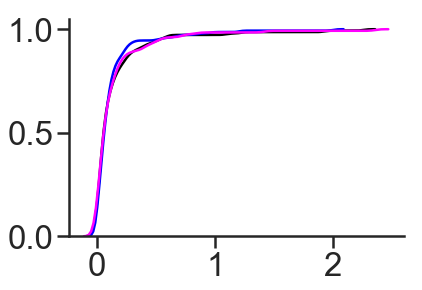

In [944]:
val = 'fwhm'
tmp = fig_inp[(fig_inp.fit_err < 0.7) & (fig_inp.depth > -1 )].groupby(['group',
                                            'cluster_id']).mean().reset_index()

x = tmp[tmp.group == 'wt'][val].dropna().values
x2 = tmp[tmp.group == 'het'][val].dropna().values
x3 = tmp[tmp.group == 'ko'][val].dropna().values


sns.kdeplot(x, cumulative=True,  color = colors_group[0])
sns.kdeplot(x2, cumulative=True,  color = colors_group[1])
sns.kdeplot(x3, cumulative=True,  color = colors_group[2])
sns.despine()
plt.savefig('cdf-fwhm_sert-sf-post.pdf', transparent=True)

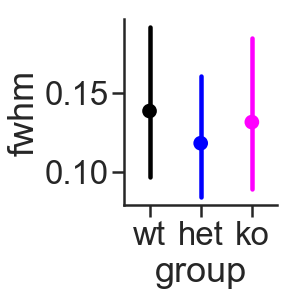

In [945]:
sns.factorplot(x = 'group', y = val, data  = tmp,  palette=colors_group, 
              order = ['wt', 'het', 'ko'], height = 5)
sns.despine()
plt.savefig('point-fwhm_sert-sf-post.pdf', transparent=True)

In [946]:
print np.mean(x), sstat.sem(x)
print np.mean(x2), sstat.sem(x2)
print np.mean(x3), sstat.sem(x3)

print len(x), len(x2), len(x3)

print sstat.kruskal(x, x2, x3)
print sstat.mannwhitneyu(x, x2)
print sstat.mannwhitneyu(x, x3)
print sstat.mannwhitneyu(x2, x3)

0.13843782322953807 0.02436492150803703
0.1180565192659071 0.01919342007662105
0.13143673812708317 0.024524077443730644
145 147 128
KruskalResult(statistic=0.4979013891397699, pvalue=0.7796184118582022)
MannwhitneyuResult(statistic=10448.0, pvalue=0.3860198324608169)
MannwhitneyuResult(statistic=9002.0, pvalue=0.33495392216482145)
MannwhitneyuResult(statistic=8948.0, pvalue=0.24243653459407521)


In [487]:
fig_inp[fig_inp.cluster_id == '244et009post']

group training layer    cluster_id  stim1     index         Hz  abs_times  \
666    ko     post  l2/3  244et009post    0.0  235542.0   4.115346       0.42   
667    ko     post  l2/3  244et009post    1.0  267842.0   3.419074       1.42   
668    ko     post  l2/3  244et009post    2.0  300142.0   5.706084       2.42   
669    ko     post  l2/3  244et009post    3.0  333442.0   7.542716       3.42   
670    ko     post  l2/3  244et009post    4.0  364842.0   6.214078       4.42   
671    ko     post  l2/3  244et009post    5.0  396142.0  15.925205       5.42   

      depth  times    ...     pref      k_exc    mu_exc     s_exc  \
666  1025.0   0.42    ...      5.0  31.850409  0.473713  0.165469   
667  1025.0   0.42    ...      5.0  31.850409  0.473713  0.165469   
668  1025.0   0.42    ...      5.0  31.850409  0.473713  0.165469   
669  1025.0   0.42    ...      5.0  31.850409  0.473713  0.165469   
670  1025.0   0.42    ...      5.0  31.850409  0.473713  0.165469   
671  1025.0   0.42    ...      5.0  31.850409  0.473713  0.165469   

            k_inh  mu_inh     s_inh  fit_err      fwhm      lsfs  
666  1.360033e-08   0.995  0.801874    0.079  0.389681  0.258417  
667  1.360033e-08   0.995  0.801874    0.079  0.389681       NaN  
668  1.360033e-08   0.995  0.801874    0.079  0.389681       NaN  
669  1.360033e-08   0.995  0.801874    0.079  0.389681       NaN  
670  1.360033e-08   0.995  0.801874    0.079  0.389681       NaN  
671  1.360033e-08   0.995  0.801874    0.079  0.389681       NaN  

[6 rows x 24 columns]

## Fit CRF to contrast tuning

In [233]:
def h_ratio(x, max_fr, c50, n):
    y_hat = []
    for idx in range(x.size):
        y_hat.append(max_fr*(x[idx]**n/(x[idx]**n + c50**n)))  
    return np.array(y_hat)

In [918]:
x = np.array([0.625, 0.125, 0.25, 0.5, 1])
d_c50 = {}
d_exp = {}
d_fit_error = {}

for unit in fig_inp[fig_inp.group != 't'].cluster_id.unique()[:]:
    tmp = fig_inp[fig_inp.cluster_id == unit]
    x  = tmp.stim1.values.astype('float')
    y = tmp.norm
    try:
        init_params = [1, 0.2, 2 ]
        bound_params = ([0, 0, 0], [1.5, 1, 10])
        popt, pcov = curve_fit(h_ratio, x, y, bounds = bound_params , p0 = init_params)
        perr = np.sqrt(np.diag(pcov_double))

        fit = h_ratio(x, *popt)
        fit_error = sum((y-fit)**2)  /  sum((y-y.mean())**2)
        perr = np.sqrt(np.diag(pcov))

        d_c50[unit] =  round(popt[1], 3)
        d_exp[unit] =  round(popt[-1], 3)
        d_fit_error[unit] =  round(fit_error, 3)
        
#         print 'c50', round(popt[1], 3)
#         print 'n', round(popt[-1], 3)
#         print 'fit err', round(fit_error, 3)
    except:
        continue
#     if fit_error < 0.7:
#         f, ax = plt.subplots()
#         sns.despine(ax = ax)

#         f2 = interp1d(x, fit, kind = 'quadratic')
#         ax.plot(x, y, 'mo-')
#         ax.plot(x, f2(x), 'r')
#         plt.show()
    
fig_inp['c50'] = fig_inp.cluster_id.map(d_c50)
fig_inp['n_exp'] = fig_inp.cluster_id.map(d_exp)
fig_inp['fit_err'] = fig_inp.cluster_id.map(d_fit_error)

# plt.savefig(str(unit) + 'ko.pdf', transparent=True)

In [919]:
fig_inp.head()

group training layer     cluster_id   stim1    index         Hz  \
1570    wt      pre     0  271etS-WT1pre  0.0625  70257.5   1.762836   
1575    wt      pre  l2/3   10etS-WT1pre  0.0625  70157.5  11.040505   
1580    wt      pre  l2/3   10etS-WT3pre  0.0625  74057.5   2.409037   
1585    wt      pre  l2/3  119etS-WT1pre  0.0625  70557.5   6.705500   
1590    wt      pre  l2/3  119etS-WT3pre  0.0625  73657.5   3.420861   

      abs_times  depth  times    zscore       ztc     bc_fr      norm    c50  \
1570      0.575    NaN  0.575  0.185452  0.584483  0.209288  0.113409  0.563   
1575      0.575  775.0  0.575  0.723818  2.953379  6.605456  0.343029  0.058   
1580      0.575  775.0  0.575 -0.146746 -0.258787 -0.204508  1.000000  0.000   
1585      0.575  650.0  0.575  0.485865  1.281717  1.744569  0.922109  1.000   
1590      0.575  650.0  0.575  0.162180  5.140802  2.214413  0.000000  0.527   

       n_exp  fit_err  
1570   3.814    0.018  
1575  10.000    0.964  
1580   0.000    1.000  
1585   0.383    0.928  
1590   0.699    0.507

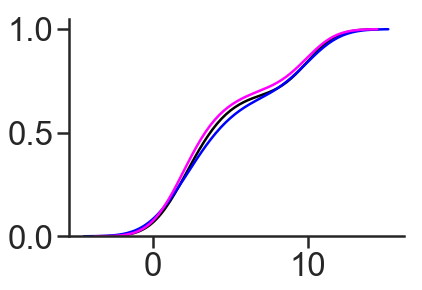

In [924]:
val = 'n_exp'
tmp = fig_inp[(fig_inp.fit_err < 0.7) & (fig_inp.depth > -1 )].groupby(['group',
                                            'cluster_id']).mean().reset_index()

x = tmp[tmp.group == 'wt'][val].dropna().values
x2 = tmp[tmp.group == 'het'][val].dropna().values
x3 = tmp[tmp.group == 'ko'][val].dropna().values

sns.kdeplot(x, cumulative=True,  color = colors_group[0])
sns.kdeplot(x2, cumulative=True,  color = colors_group[1])
sns.kdeplot(x3, cumulative=True,  color = colors_group[2])
sns.despine()
# plt.savefig('cdf-c50_sert-contrast-pre.pdf', transparent=True)

In [925]:
print np.mean(x), sstat.sem(x)
print np.mean(x2), sstat.sem(x2)
print np.mean(x3), sstat.sem(x3)

print len(x), len(x2), len(x3)
print sstat.kruskal(x, x2, x3)
print sstat.mannwhitneyu(x, x2)
print sstat.mannwhitneyu(x, x3)
print sstat.mannwhitneyu(x2, x3)

4.85043119266055 0.3492878971001539
4.978879310344827 0.48293334393784093
4.555392523364486 0.3473996583422256
109 58 107
KruskalResult(statistic=1.0629924500279166, pvalue=0.5877249427227298)
MannwhitneyuResult(statistic=3106.0, pvalue=0.42656132541964686)
MannwhitneyuResult(statistic=5426.5, pvalue=0.187538159111723)
MannwhitneyuResult(statistic=2860.5, pvalue=0.20273685583985623)


## Neural decoding

In [994]:
path = r"U:\Data_Analysis\pak6\Analysis of units\SERT KO paper\sert_ko_spikes_probe64da.pkl"
df_spikes_da = pd.read_pickle(path)

path = r"U:\Data_Analysis\pak6\Analysis of units\SERT KO paper\sert_ko_spikes_probe64db.pkl"
df_spikes_db = pd.read_pickle(path)

In [1000]:
# recs with 8 drifitng instead of 12 drifting, 25 trials 8 directions (45 deg)
rec_dir8 = df_spikes_db[df_spikes_db.times > 560].path.unique()


array(['U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Males\\set2\\007-left2\\conc',
       'U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Males\\set2\\008-left2\\conc',
       'U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Males\\set2\\003-right1\\conc',
       'U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Males\\set2\\010-left2\\conc',
       'U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Males\\set2\\005-left2\\conc',
       'U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Males\\set2\\003-left2\\conc',
       'U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Males\\set2\\007-right1\\conc',
       'U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Males\\set2\\010-right1\\conc',
       'U:\\Data\\pak6\\OpenEphys\\probe_64DB\\SERT KO\\stim-1-only-training\\Males\\set2\\006-left2\\conc',
       'U:\\Data

In [1009]:
# recs with 8 drifitng instead of 12 drifting, 25 trials 8 directions (45 deg)

tmp = df_spikes_db
rec_dir8 = tmp[tmp.times > 560].path.unique()

tmp2 = tmp[tmp.path.isin(rec_dir8)]
# tmp2 = df_spikes[df_spikes.path.isin(rec_dir8)]

# 15 trials, 12 directions, 1s trial length
# df3 = tmp[(tmp.loc[:, 'times'] > 160) & (tmp.loc[:, 'times'] < 340)] 
# df3.times = df3.times - 160
# df3.loc[:, 'trial_n'] = df3.loc[:, 'times'] //1.0
# df3.loc[:,'paradigm'] = '12-drifting'
# df3.loc[:,'stim1'] = df3.trial_n.map(d_dir12)

# 25 trials, 8 directions, 1s trial length
df4 = tmp2[(tmp2.loc[:, 'times'] > 160) & (tmp2.loc[:, 'times'] < 360)] 
df4.times = df4.times - 160
df4.loc[:, 'trial_n'] = df4.loc[:, 'times'] //1.0
df4.loc[:,'paradigm'] = '8-drifting'
df4.loc[:,'stim1'] = df4.trial_n.map(d_dir8)

# 20 trials, 6 sf, 1s trial length
# df5 = tmp[(tmp.loc[:, 'times'] > 340) & (tmp.loc[:, 'times'] < 460)] 
# df5.times = df5.times - 340
# df5.loc[:, 'trial_n'] = df5.loc[:, 'times'] //1.0
# df5.loc[:,'paradigm'] = 'sf-tuning'
# df5.loc[:,'stim1'] = df5.trial_n.map(d_sf)

df6 = tmp2[(tmp2.loc[:, 'times'] > 360) & (tmp2.loc[:, 'times'] < 480)] 
df6.times = df6.times - 360
df6.loc[:, 'trial_n'] = df6.loc[:, 'times'] //1.0
df6.loc[:,'paradigm'] = 'sf-tuning'
df6.loc[:,'stim1'] = df6.trial_n.map(d_sf)
df6 = pd.concat([df5, df6])

# 20 trials, 5 contasrts, 1s trial length
# df7 = tmp[(tmp.loc[:, 'times'] > 460) & (tmp.loc[:, 'times'] < 560)] 
# df7.times = df7.times - 460
# df7.loc[:, 'trial_n'] = df7.loc[:, 'times'] //1.0
# df7.loc[:,'paradigm'] = 'contrast-tuning'
# df7.loc[:,'stim1'] = df7.trial_n.map(d_contrast)

df8 = tmp2[(tmp2.loc[:, 'times'] > 480) & (tmp2.loc[:, 'times'] < 580)] 
df8.times = df8.times - 480
df8.loc[:, 'trial_n'] = df8.loc[:, 'times'] //1.0
df8.loc[:,'paradigm'] = 'contrast-tuning'
df8.loc[:,'stim1'] = df8.trial_n.map(d_contrast)


In [1061]:
master_spikes['group'] = master_spikes.et.map(groups)

In [1065]:
master_spikes2.to_pickle('sert_spikes_master_mapped.pkl')

In [1064]:
master_spikes2 = pd.concat([df_wt, master_spikes])

In [1041]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, RepeatedStratifiedKFold, cross_val_score, StratifiedKFold
from collections import defaultdict
from statsmodels.formula.api import ols
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [1561]:
df_sp = master_spikes2[master_spikes2.paradigm == '12-drifting']

In [1562]:
df_sp.loc[:, 'dir'] = df_sp.stim1*30
df_sp.loc[:,'ori'] = df_sp['dir']%180
df_sp.loc[:,'trial_spikes'] = df_sp.times - df_sp.trial_n
df_sp = df_sp[(df_sp.trial_spikes > 0.35) & (df_sp.trial_spikes < 0.8)]

In [1099]:
df_sp.head()

templates     times  unit_id     et training      cluster_id sex  \
302259         69  0.000700       69  S-WT3     post   69etS-WT3post   M   
302263        162  0.003167      162  S-WT3     post  162etS-WT3post   M   
302266         69  0.011167       69  S-WT3     post   69etS-WT3post   M   
302267         16  0.013133       16  S-WT3     post   16etS-WT3post   M   
302271         69  0.018933       69  S-WT3     post   69etS-WT3post   M   

                                                     path  trial_n   paradigm  \
302259  U:\Data\pak6\OpenEphys\probe_64DA\SERT KO\stim...      0.0  sf-tuning   
302263  U:\Data\pak6\OpenEphys\probe_64DA\SERT KO\stim...      0.0  sf-tuning   
302266  U:\Data\pak6\OpenEphys\probe_64DA\SERT KO\stim...      0.0  sf-tuning   
302267  U:\Data\pak6\OpenEphys\probe_64DA\SERT KO\stim...      0.0  sf-tuning   
302271  U:\Data\pak6\OpenEphys\probe_64DA\SERT KO\stim...      0.0  sf-tuning   

       stim1 group  trial_spikes  
302259     2    wt      0.000700  
302263     2    wt      0.003167  
302266     2    wt      0.011167  
302267     2    wt      0.013133  
302271     2    wt      0.018933

In [1572]:
np.array(d_dir12.values())*30%180

array([120,  30,  90,  60, 120,  60,  90, 150,  30,  90, 120,  60,  90,
        60,  30,  60,   0, 120,  90, 150, 120,  90,  30, 150, 120,   0,
        30,  30,  60,  60,  60,  90, 150,  90,   0, 150, 120, 120,  90,
         0,  30, 150,  90, 150,  90, 120, 150,   0,  60,  90, 150, 120,
        60,  60, 150,  60, 120,  90, 150,  30,  30,   0, 120,  90,  30,
       150, 150,  90, 150, 120,  30,  60,  90,   0,  60,  60, 150, 150,
       120,  30,  90,  30, 120,   0,  60, 120,  30,  60,   0, 150,   0,
         0,  60, 150,  30, 120,  90,  60,  90,  30,  60, 120, 150,  90,
       150,  30,  30,  90, 120,  30,  60, 120,   0,  30, 150,  30,   0,
        60,   0, 120, 120, 150,  30,  60, 120,  90, 150,  90,  60,   0,
        90,  60,   0, 150,   0,   0, 120,   0,  30, 120, 150,   0, 120,
         0,  60, 120,  90, 150,  90,   0, 150,  30,  90,  30,   0,   0,
        90,  30,   0, 120, 150,   0, 150,  30,   0, 150,  30, 120,  30,
         0,  60,  60,  90,  60,  60,  90,   0, 120,   0,  30])

In [1573]:
lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto')
# kf = KFold(n_splits = 4)
ls_cond = []
rskf = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 5,
     random_state = 3)
df_sp.loc[:,'trial_spikes'] = df_sp.times - df_sp.trial_n
_data = df_sp
y_ = np.array(d_dir12.values())*30%180

for gr in sorted(_data.group.unique()):
    for tr in (_data.training.unique()):
        
        df2_sub = _data[(_data.training == tr) & (_data.group == gr)]
        resp_units = df2_sub.groupby('cluster_id').times.count().reset_index()
        resp_units = resp_units[resp_units.times > 10].cluster_id.unique()
        tmp = df2_sub[df2_sub.cluster_id.isin(resp_units)].groupby(['cluster_id', 
                                                'trial_n']).trial_spikes.count().reset_index()
        tmp2 = tmp.pivot('trial_n', 'cluster_id', 'trial_spikes')
        tmp2 = tmp2.fillna(0)

        ls = []
    # coef_arr = np.zeros((100,5, _data.cuid.unique().size ))
        print tr, gr

        x_ = tmp2.values
        print x_.shape

        scores = cross_val_score(lda, x_, y_, cv = rskf)
    #         print scores
        tmp_df = pd.DataFrame({'cv': i, 'group': gr, 'training': tr, 'acc': scores})
        ls_cond.append(tmp_df)
out = pd.concat(ls_cond)
out.loc[:,'error'] = 1 - out.acc
out.head()

post het
(180L, 148L)
pre het
(180L, 116L)
post ko
(180L, 109L)
pre ko
(180L, 120L)
post wt
(180L, 204L)
pre wt
(180L, 241L)


acc  cv group training     error
0  0.916667   4   het     post  0.083333
1  0.875000   4   het     post  0.125000
2  0.976190   4   het     post  0.023810
3  0.976190   4   het     post  0.023810
4  0.979167   4   het     post  0.020833

(0, 1)

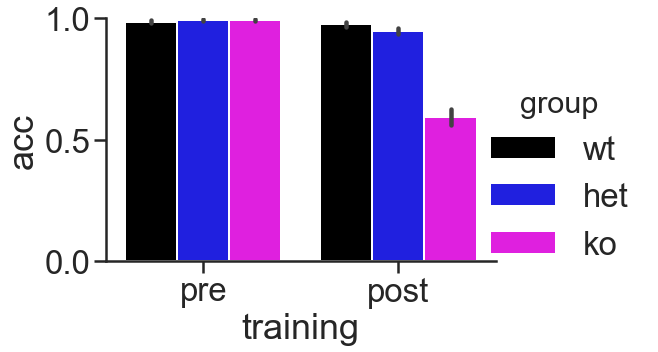

In [1574]:
sns.catplot(x = 'training', y = 'acc', data = out, hue = 'group', 
            kind = 'bar', height = 5, aspect = 1.5, 
            hue_order = ['wt', 'het', 'ko'], order = ['pre', 'post'],
            palette = colors_group , ci = 95)
plt.ylim(0, 1)
# plt.savefig('bar-sert-ctr-decod-lda.pdf')

In [1575]:
out.groupby(['group', 'training']).acc.agg(['mean', 'sem'])

mean       sem
group training                    
het   post      0.949107  0.006755
      pre       0.994345  0.002253
ko    post      0.594345  0.016130
      pre       0.994345  0.002253
wt    post      0.975000  0.006005
      pre       0.986607  0.003411

## Waveform split RS/FS

In [1504]:
import resampy
import scipy.optimize as opt
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [1507]:
result = df_tmt_ms
samples = np.concatenate([np.arange(82)] * result.cluster_id.unique().size)
result['samples'] = samples
spk_width = {}
d_fwhm = {}
tr2peak = {}
neuron_type = {}
ls = []
ls2 = []
ls3 = []
# f, ax = plt.subplots(1,2)
for ii in result.cluster_id.unique()[:]:
#trough-to-peak    
    #tp =  result[(result['cuid'] == ii)  & (result.index > 18)  ].tmt.idxmax() - result[(result['cuid'] == ii)  & (result.index == 18)  ].index
    tmt_data = np.array(result[(result['cluster_id'] == ii) ].tmt)

    y = resampy.resample( tmt_data[::-1] , 1 ,10,  filter='sinc_window',
                                    num_zeros=10, precision=5,
                                    window=ssig.hann)
    trough_idx = y.argmin()
    peak_idx = y[:y.argmin()].argmax()
#     plt.plot(y)
#     plt.axvline(x= trough_idx, color = 'k', linestyle = '--')
#     plt.axvline(x= peak_idx, color = 'r',linestyle = '--')
#     plt.axvline(x= peak_idx-100, color = 'b',linestyle = '--')
#     plt.show()

    tp = abs((trough_idx - peak_idx)/300.0)
    
    x = np.arange(y.size)
    y_gaus = y*(-1)
    popt,pcov = opt.curve_fit(gaus,x,y_gaus,p0=[0.2, y.argmin(), 10])
    fwhm = popt[-1]/300*2.355
    
#     plt.plot(x,y*(-1),'b+:')
#     plt.plot(x,gaus(x,*popt),'r--')
#     plt.show()

    f,pxx = ssig.welch(tmt_data, fs=3e4,  nfft=5096,  nperseg=48,
                          return_onesided=True, scaling='spectrum')

    df = np.vstack((f, pxx))
    df = pd.DataFrame(df)
    idx = df.T[1].idxmax()
    w = df.T[0][idx]
    w = 1/w*1000.0

    ls2.append(w)
    ls.append(tp)
    
    spk_width[ii] = w
    tr2peak[ii] = tp
    
    if tp < 0.45 and w < 1.2:
        neuron_type[ii] = 'fs'
    elif tp > 0.45 and w > 1.2:
        neuron_type[ii] = 'rs'
    else:
        neuron_type[ii] = 'un'

#p/t ratio
#     edge = 100
#     if peak_idx < 100:
#         edge = peak_idx
#     y_slope = y[peak_idx-edge:peak_idx]
#     x_slope = np.arange(y_slope.size)
#     slope, intercept, r_value, p_value, std_err = sstat.linregress(x_slope, y_slope)
#     ls3.append(1e3*(slope))
    
#     plt.plot(x_slope, y_slope, 'o')
#     plt.plot(x_slope, intercept + slope*x_slope, 'r')
#     plt.show()
result['n_type'] = result.cluster_id.map(neuron_type)
result['sp_w'] = result.cluster_id.map(spk_width)
result['fwhm'] = result.cluster_id.map(d_fwhm)
result['tp'] = result.cluster_id.map(tr2peak)

In [1508]:
total = result.cluster_id.unique().size
print total
print result[result['samples'] == 0].groupby('n_type').cluster_id.count()/total


1203
n_type
fs    0.086451
rs    0.808811
un    0.104738
Name: cluster_id, dtype: float64


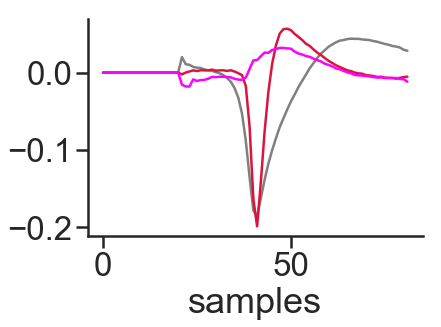

In [1509]:
result[result.n_type == 'rs'].groupby('samples').tmt.mean().plot()
result[result.n_type == 'fs'].groupby('samples').tmt.mean().plot()
result[result.n_type == 'un'].groupby('samples').tmt.mean().plot()
sns.despine()

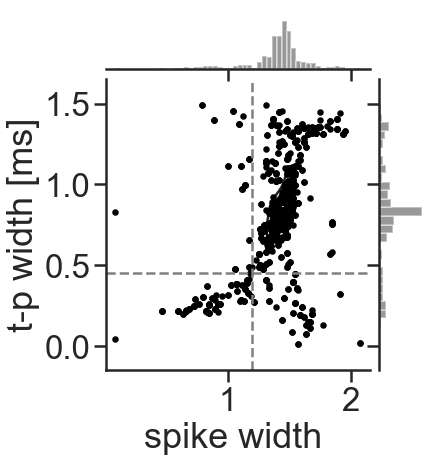

In [1510]:
g = (sns.jointplot(np.array(ls2), np.array(ls), stat_func= None,
             color="k", s = 20)
       .plot_joint(sns.kdeplot, zorder=0, n_levels=6))
g.set_axis_labels('spike width ', 't-p width [ms]')
# plt.axhline(y= 0.45, linestyle = '--')
plt.axvline(x= 1.2, linestyle = '--')
plt.axhline(y= 0.45, linestyle = '--')